In [2]:
# !pip install pandas numpy opencv-python matplotlib scipy requests openpyxl

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks

In [4]:
# Load the video
video_path = '100_waheeda_1.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Determine block size for 10x10 grid
block_width = width // 10
block_height = height // 10

# Initialize a list to hold the average red values for each block
avg_red_values = np.zeros((10, 10, frame_count), dtype=float)

current_frame = 0

while cap.isOpened() and current_frame < frame_count:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to RGB (if not already in RGB format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process each block
    for i in range(10):
        for j in range(10):
            # Define the current block
            block = frame_rgb[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            
            # Calculate the average red value for the block
            avg_red = np.mean(block[:, :, 0])  # 0 index for the red channel
            avg_red_values[i, j, current_frame] = avg_red
            
    current_frame += 1

# Close video file
cap.release()

# Selecting frames 51 to 550 due to noise at the start and end of the video
selected_frames = avg_red_values[:, :, 26:276]
selected_frames


array([[[253.60382909, 253.60990548, 253.60908565, ..., 253.63589892,
         253.63392168, 253.64742477],
        [253.35619213, 253.35619213, 253.34153164, ..., 253.61911651,
         253.60966435, 253.68185764],
        [253.48302469, 253.48302469, 253.46412037, ..., 254.08805941,
         254.06621335, 254.13855131],
        ...,
        [253.69376929, 253.69521605, 253.70780285, ..., 253.93475116,
         253.9220679 , 253.97284915],
        [253.43364198, 253.43364198, 253.43364198, ..., 251.09919946,
         251.10908565, 251.36839313],
        [253.12162423, 253.0226659 , 252.83887924, ..., 246.28641011,
         246.28645833, 246.37369792]],

       [[253.59534144, 253.58945795, 253.57826968, ..., 253.73635224,
         253.71966628, 253.7297936 ],
        [253.48490548, 253.48490548, 253.47299383, ..., 254.13083526,
         254.11115934, 254.14737654],
        [254.17824074, 254.1804591 , 254.13425926, ..., 253.82262731,
         253.82204861, 253.82122878],
        ...,


In [5]:
frame_count

300

In [6]:
avg_red_values.shape

(10, 10, 300)

In [7]:
selected_frames.shape

(10, 10, 250)

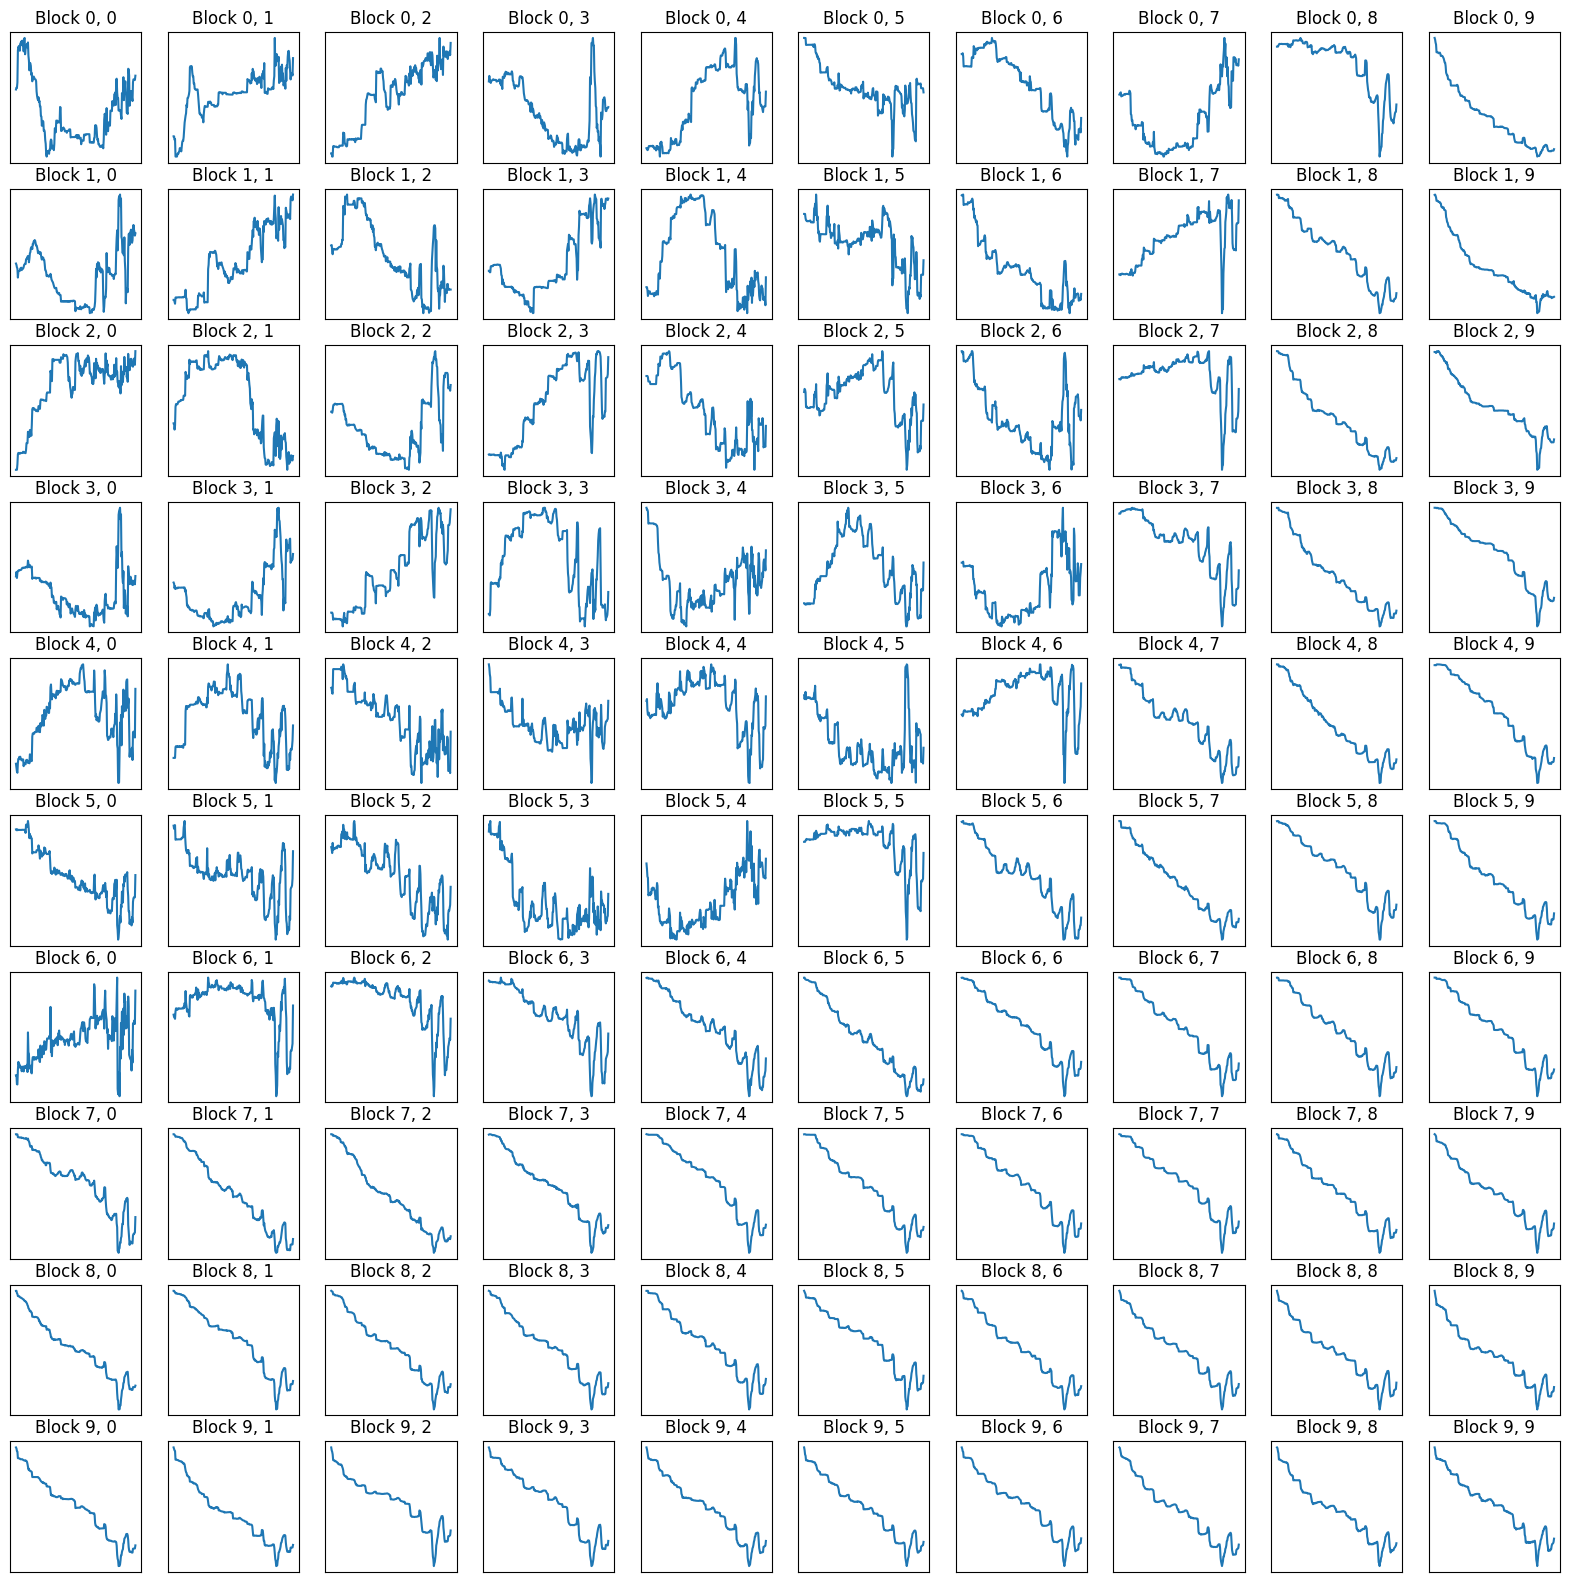

In [8]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(selected_frames[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



In [9]:
Su = selected_frames

In [10]:
# Define functions for Butterworth filter and FFT
def butterworth_filter(signal, sampling_rate, lowcut, highcut, order=2):
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def apply_fft(signal, sampling_rate, low_freq=0.5, high_freq=5.0):
    n = len(signal)
    freq = fftfreq(n, d=1/sampling_rate)
    fft_signal = fft(signal)

    # Identify indices corresponding to frequencies outside the desired range
    unwanted_indices = (freq < low_freq) | (freq > high_freq)
        
    # Set those frequency components to zero
    fft_signal[unwanted_indices] = 0
        
    # Apply inverse FFT to get the filtered signal
    filtered_signal = ifft(fft_signal)
    return filtered_signal.real


# Parameters for Butterworth filter
lowcut = 0.5  # Hz
highcut = 5.0  # Hz
sampling_rate = fps

# Apply Butterworth filter to each PPG signal
Sc = np.zeros_like(Su)
BF = np.zeros_like(Su)
for i in range(10):
    for j in range(10):
        signal = Su[i, j, :]
        filtered_signal = butterworth_filter(signal, sampling_rate, lowcut, highcut)
        BF[i, j, :] = filtered_signal
        fft_signal = apply_fft(filtered_signal, sampling_rate, lowcut, highcut)
        Sc[i, j, :] = fft_signal

#multiplying Sc with -1 to get SPPG
SPPG = -1 * Sc


In [11]:
SPPG.shape

(10, 10, 250)

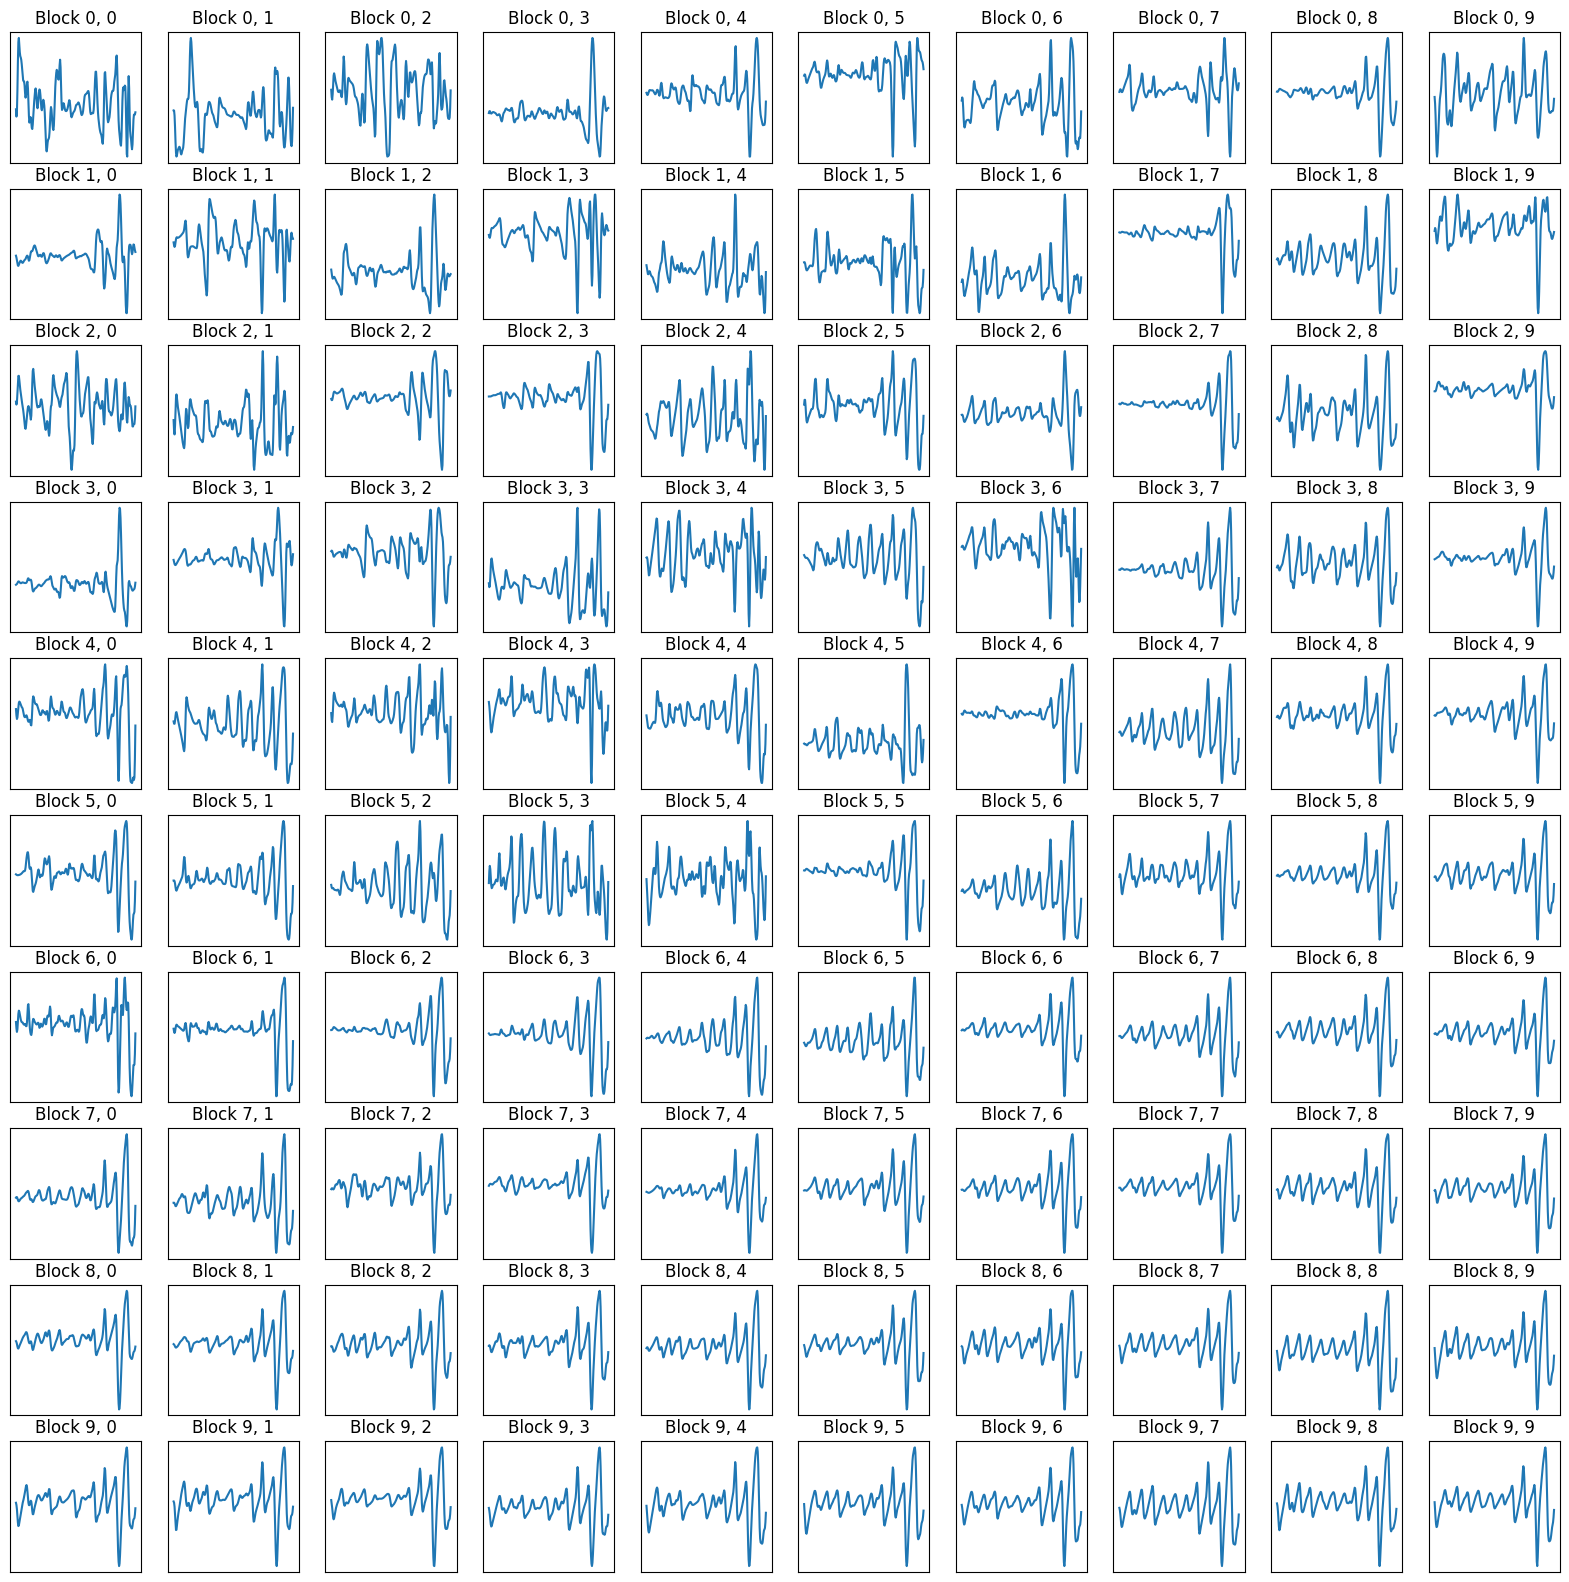

In [12]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(BF[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



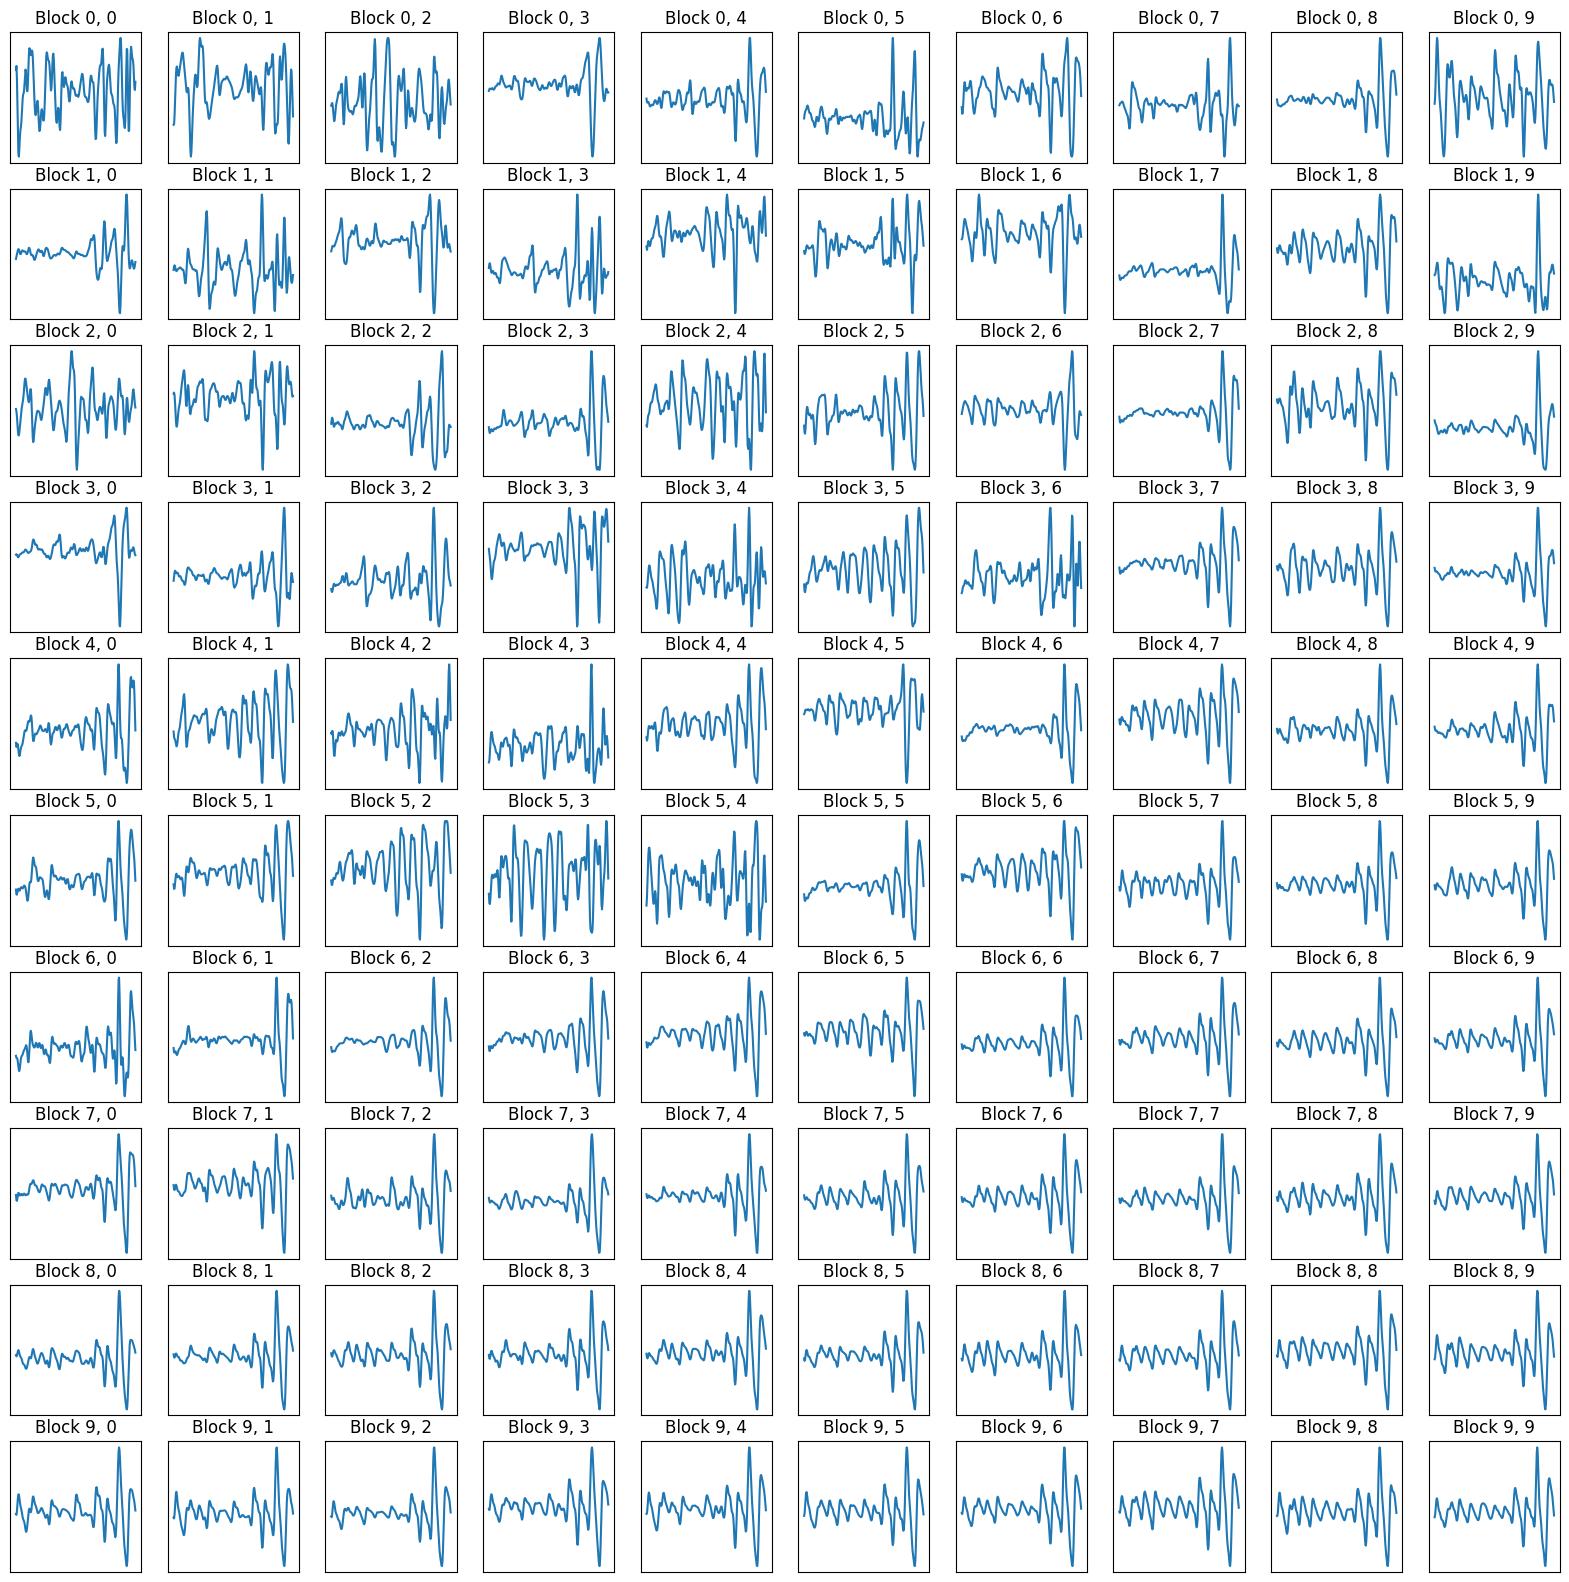

In [13]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(SPPG[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()

In [14]:
# Create a list to hold the average red values for the first block of each frame
first_block_avg_red = []
# Iterate through each frame
for i in range(Su.shape[2]):
    # Extract the average red value for the first block of the current frame
    avg_red = Su[0, 0, i]
    # Append the average red value to the list
    first_block_avg_red.append(avg_red)


# Create a list to hold the average red values for the first block of each frame
first_block_denoised = []
# Iterate through each frame
for i in range(SPPG.shape[2]):
    # Extract the average red value for the first block of the current frame
    avg_red_d = SPPG[0, 0, i]
    # Append the average red value to the list
    first_block_denoised.append(avg_red_d)



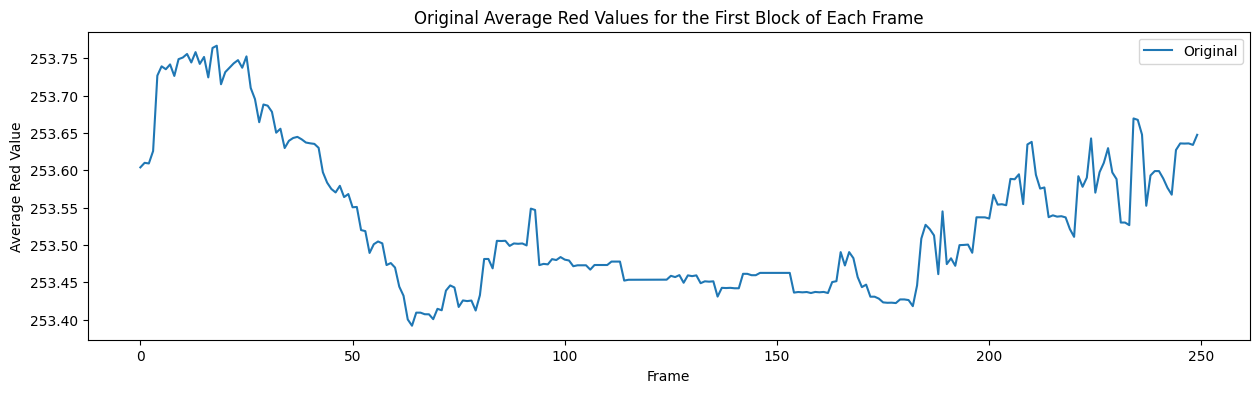

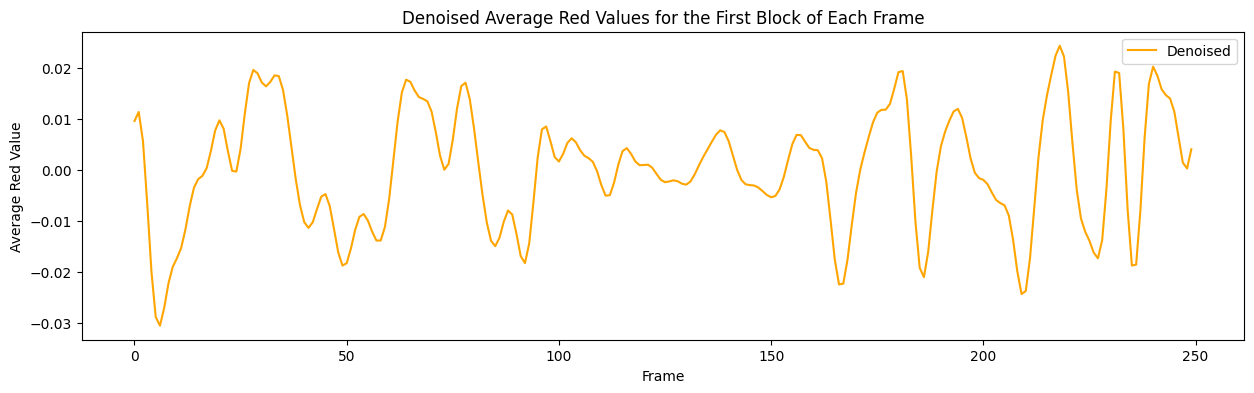

In [15]:
# Plot first_block_avg_red
plt.figure(figsize=(15, 4))
plt.plot(first_block_avg_red, label='Original')
plt.xlabel('Frame')
plt.ylabel('Average Red Value')
plt.title('Original Average Red Values for the First Block of Each Frame')
plt.legend()
plt.show()

# Plot first_block_denoised
plt.figure(figsize=(15, 4))
plt.plot(first_block_denoised, color='orange', label='Denoised')
plt.xlabel('Frame')
plt.ylabel('Relative Intensity')
plt.title('Denoised Average Red Values for the First Block of Each Frame')
plt.legend()
plt.show()


In [56]:
def get_expected_cycle_time(ppg_signal, sampling_rate):
    # Compute the FFT of the PPG signal
    fft_signal = fft(ppg_signal)
    
    # Compute the frequency spectrum and corresponding frequencies
    n = len(ppg_signal)
    freq = fftfreq(n, d=1/sampling_rate)
    
    # Find the index of the dominant frequency component
    dominant_freq_idx = np.argmax(np.abs(fft_signal))
    
    # Calculate the period of the dominant frequency component
    dominant_freq = freq[dominant_freq_idx]
    if dominant_freq == 0:
        # Avoid division by zero when the dominant frequency is 0 Hz
        return np.inf
    expected_period = 1 / dominant_freq
    
    # Convert period to cycle time (in seconds)
    expected_cycle_time = expected_period
    
    return expected_cycle_time


def detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate):
    ppg_cycles = []

    peaks, _ = find_peaks(sppg_signal)
    valleys, _ = find_peaks(-sppg_signal)

    # Ensure peaks and valleys are not empty
    if len(peaks) == 0 or len(valleys) == 0:
        return ppg_cycles

    # Plot the PPG signal
    plt.figure(figsize=(15,4))
    plt.plot(sppg_signal, label='PPG Signal')

    # # Mark peaks and valleys differently
    # plt.scatter(peaks, sppg_signal[peaks], color='red', marker='o', label='Peaks')
    # plt.scatter(valleys, sppg_signal[valleys], color='blue', marker='x', label='Valleys')

    # Mark start_point, systolic_peak, dicrotic_notch, diastolic_peak, and end_point
    for peak_idx in range(len(peaks) - 1):
        for valley_idx in range(len(valleys) - 1):
            start_idx = valleys[valley_idx]
            end_idx = valleys[valley_idx + 1]

            # Check if the current peak is within the current valley
            if start_idx < peaks[peak_idx] < end_idx:
                try:
                    systolic_peak = peaks[peak_idx]
                    diastolic_peak = peaks[peak_idx + 1]
                    start_point = start_idx
                    end_point = valleys[valley_idx + 2]
                    dicrotic_notch = valleys[valley_idx+1]

                    # Check conditions for valid PPG cycle
                    if (sppg_signal[systolic_peak] > sppg_signal[diastolic_peak]):
                        if (sppg_signal[dicrotic_notch] > sppg_signal[start_point] and sppg_signal[dicrotic_notch] > sppg_signal[end_point]):

                            # Calculate time elapsed for PPG cycle
                            cycle_time = (end_point - start_point) / sampling_rate
                            expected_cycle_time = get_expected_cycle_time(sppg_signal, sampling_rate)
                            error_margin = 0.2 * expected_cycle_time
                            # Check if time elapsed is within threshold
                            if abs(cycle_time - expected_cycle_time) <= error_margin:
                                
                                # Mark each systolic peak and diastolic peak with a different marker
                                plt.scatter(systolic_peak, sppg_signal[systolic_peak], color='green', marker='^')
                                plt.scatter(diastolic_peak, sppg_signal[diastolic_peak], color='pink', marker='d')
                                # Mark each dicrotic notch with a different marker
                                plt.scatter(dicrotic_notch, sppg_signal[dicrotic_notch], color='purple', marker='*')
                                ppg_cycles.append((start_point, systolic_peak, dicrotic_notch, diastolic_peak, end_point))
                                # Mark starting and ending point with a different marker
                                plt.scatter(start_point, sppg_signal[start_point], color='black', marker='P')
                                plt.scatter(end_point, sppg_signal[end_point], color='orange', marker='s')
                except IndexError:
                    pass
    # Plot the legend
    plt.legend()
    plt.legend(['PPG Signal', 'Systolic Peak', 'Diastolic Peak', 'Dicrotic Notch', 'Start Point', 'End Point'])
    plt.xlabel('Frame')
    plt.ylabel('PPG Signal Value')
    plt.title('Detected Cycles')
    plt.show()

    return ppg_cycles

# # Example usage
# sampling_rate = fps 
# sppg_signal = SPPG[0, 0, :]  # Assuming we are processing the first PPG signal
# ppg_cycles = detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate)
# print("Detected PPG cycles:", ppg_cycles)


In [60]:
def select_three_ppg_cycles(ppg_cycles):
    # Sort the detected PPG cycles based on descending systolic heights
    sorted_cycles = sorted(ppg_cycles, key=lambda cycle: cycle[1], reverse=True)
    print("Sorted PPG cycles:", sorted_cycles)

    # If at least three PPG cycles are detected, select the top three based on systolic heights
    if len(sorted_cycles) >= 3:
        selected_cycles = sorted_cycles[:3]
    elif len(sorted_cycles) > 0:
        # If less than three PPG cycles are detected, replicate the PPG cycle with maximum systolic height to get three cycles
        selected_cycles = sorted_cycles
        while len(selected_cycles) < 3:
            selected_cycles.append(sorted_cycles[0])
    else:
        # If no PPG cycles are detected, return an empty list
        selected_cycles = []    
    
    return selected_cycles


In [61]:
def merge_ppg_cycles(sppg_signal, selected_cycles):
    if len(selected_cycles) == 0:
        return None
    
    max_length = max(end_idx - start_idx + 1 for start_idx, _, _, _, end_idx in selected_cycles)
    merged_signal = np.zeros(max_length)
    num_cycles = len(selected_cycles)
    
    for cycle in selected_cycles:
        start_idx, systolic_peak_idx, dicrotic_notch_idx, diastolic_peak_idx, end_idx = cycle
        cycle_signal = sppg_signal[start_idx:end_idx+1]
        
        # Pad cycle signal if necessary
        if len(cycle_signal) < max_length:
            pad_length = max_length - len(cycle_signal)
            cycle_signal = np.pad(cycle_signal, (0, pad_length), mode='constant')
        
        merged_signal += cycle_signal
    
    # Take the average of the summed signals
    merged_signal /= num_cycles
    
    return merged_signal

In [62]:
def visualize_merged_signal(merged_signal, sampling_rate):
    if merged_signal is None:
        print("No merged signal to visualize.")
        return
    
    # Calculate time axis based on sampling rate
    time_axis = np.arange(len(merged_signal)) / sampling_rate
    
    # Plot the merged signal
    plt.figure()
    plt.plot(time_axis, merged_signal, color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('PPG Signal Value')
    plt.title('Merged PPG Signal')
    plt.grid(True)
    plt.show()

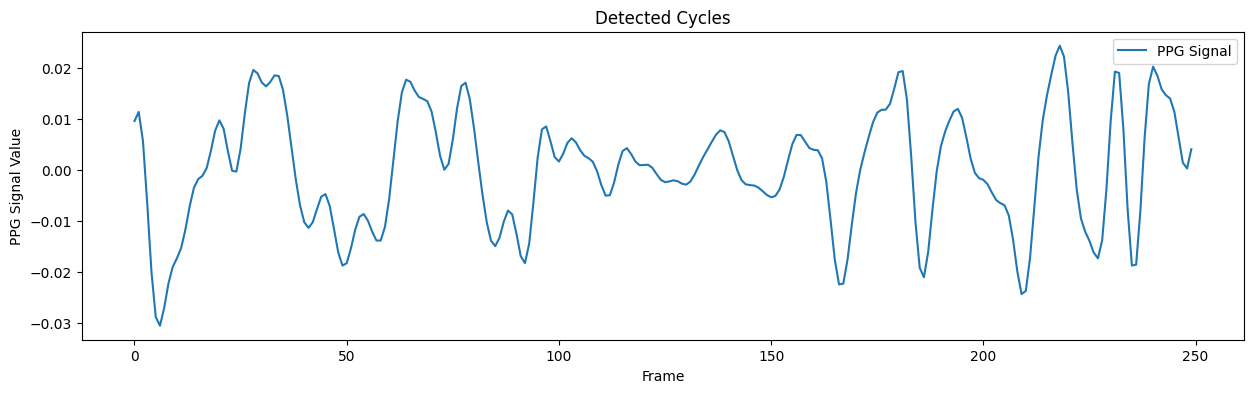

Detected PPG cycles for block 0, 0: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


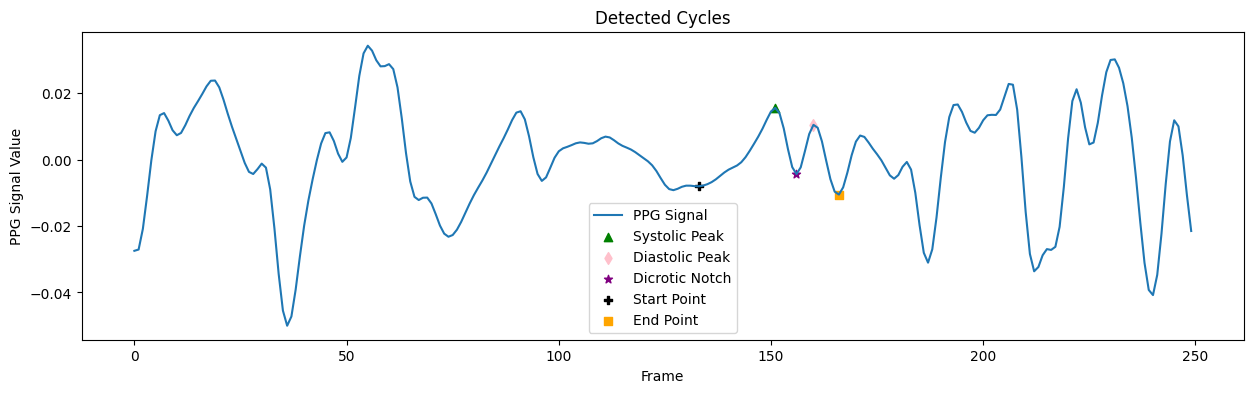

Detected PPG cycles for block 0, 1: [(133, 151, 156, 160, 166)]
Sorted PPG cycles: [(133, 151, 156, 160, 166)]
Selected PPG cycles {i}, {j}: [(133, 151, 156, 160, 166), (133, 151, 156, 160, 166), (133, 151, 156, 160, 166)]
Merged PPG signal: [-0.00802637 -0.00782768 -0.00741058 -0.00679002 -0.00594928 -0.00492676
 -0.00388719 -0.00303363 -0.0024054  -0.00177464 -0.00079126  0.00073025
  0.0026682   0.00476189  0.00692266  0.00931351  0.01200762  0.01449135
  0.01556427  0.01395906  0.00937407  0.0031215  -0.00226395 -0.00436811
 -0.00233925  0.00256414  0.00768995  0.01045505  0.00958751  0.00547788
 -0.00032121 -0.00590584 -0.00964708 -0.01052897]


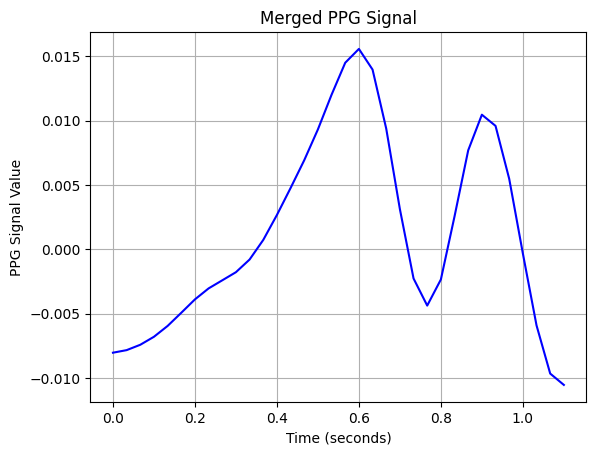

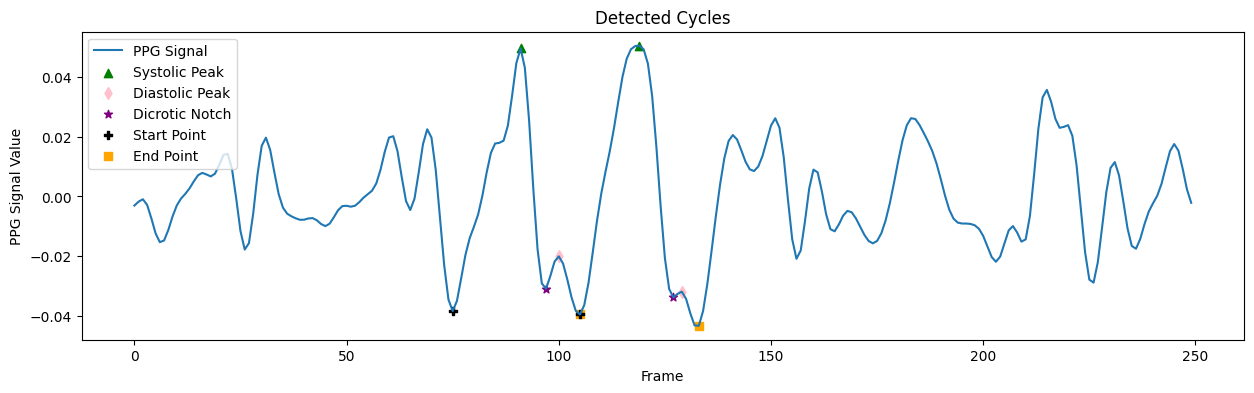

Detected PPG cycles for block 0, 2: [(75, 91, 97, 100, 105), (105, 119, 127, 129, 133)]
Sorted PPG cycles: [(105, 119, 127, 129, 133), (75, 91, 97, 100, 105)]
Selected PPG cycles {i}, {j}: [(105, 119, 127, 129, 133), (75, 91, 97, 100, 105), (105, 119, 127, 129, 133)]
Merged PPG signal: [-0.0391804  -0.03593546 -0.02844471 -0.01904697 -0.01011712 -0.0027854
  0.00350396  0.0101545   0.01791106  0.02597969  0.03262542  0.03677753
  0.03913242  0.04153721  0.04495787  0.04778282  0.04620813  0.03682047
  0.01954709 -0.00141868 -0.01968495 -0.03038098 -0.03288177 -0.030657
 -0.02854999 -0.02960727 -0.0336339  -0.03808607 -0.04015581 -0.01277925
 -0.01318785]


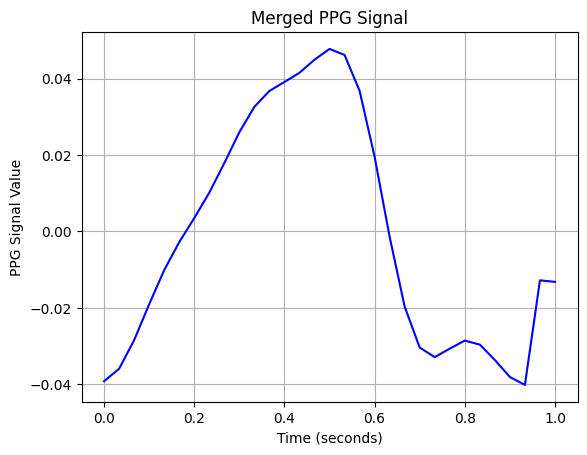

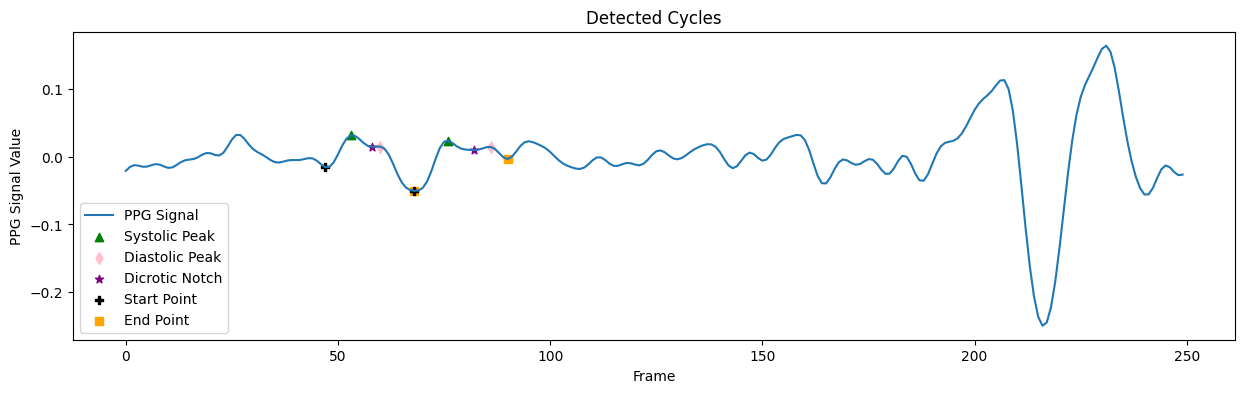

Detected PPG cycles for block 0, 3: [(47, 53, 58, 60, 68), (68, 76, 82, 86, 90)]
Sorted PPG cycles: [(68, 76, 82, 86, 90), (47, 53, 58, 60, 68)]
Selected PPG cycles {i}, {j}: [(68, 76, 82, 86, 90), (47, 53, 58, 60, 68), (68, 76, 82, 86, 90)]
Merged PPG signal: [-0.03887659 -0.03831515 -0.03345878 -0.02335251 -0.00895348  0.00650649
  0.01877845  0.02480832  0.02439434  0.02008635  0.01539582  0.01262748
  0.01185424  0.0115829   0.01032658  0.00771134  0.00433581  0.00078893
 -0.00305657 -0.00772005 -0.01306524 -0.01760187 -0.00234734]


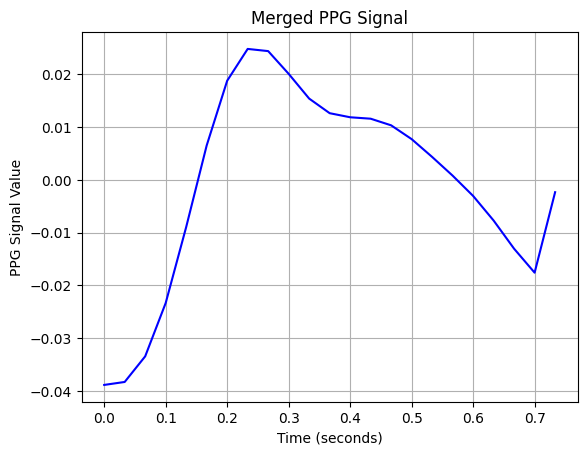

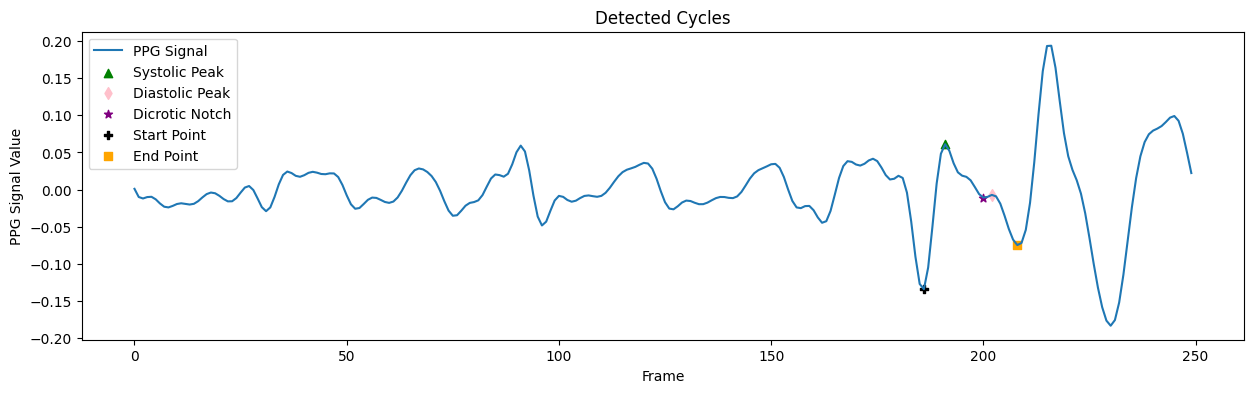

Detected PPG cycles for block 0, 4: [(186, 191, 200, 202, 208)]
Sorted PPG cycles: [(186, 191, 200, 202, 208)]
Selected PPG cycles {i}, {j}: [(186, 191, 200, 202, 208), (186, 191, 200, 202, 208), (186, 191, 200, 202, 208)]
Merged PPG signal: [-0.13416195 -0.10498712 -0.05017106  0.00808016  0.04829803  0.0610773
  0.05206208  0.03540942  0.02322394  0.01870933  0.01714853  0.01248752
  0.0033806  -0.006097   -0.01084901 -0.00981846 -0.00721597 -0.00917229
 -0.01903161 -0.03524042 -0.05299805 -0.06738256 -0.07479466]


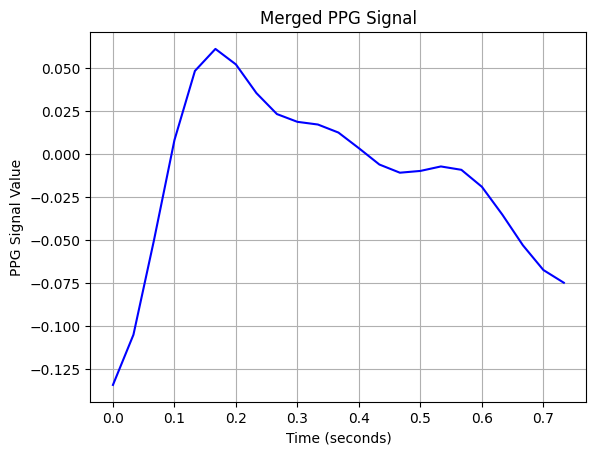

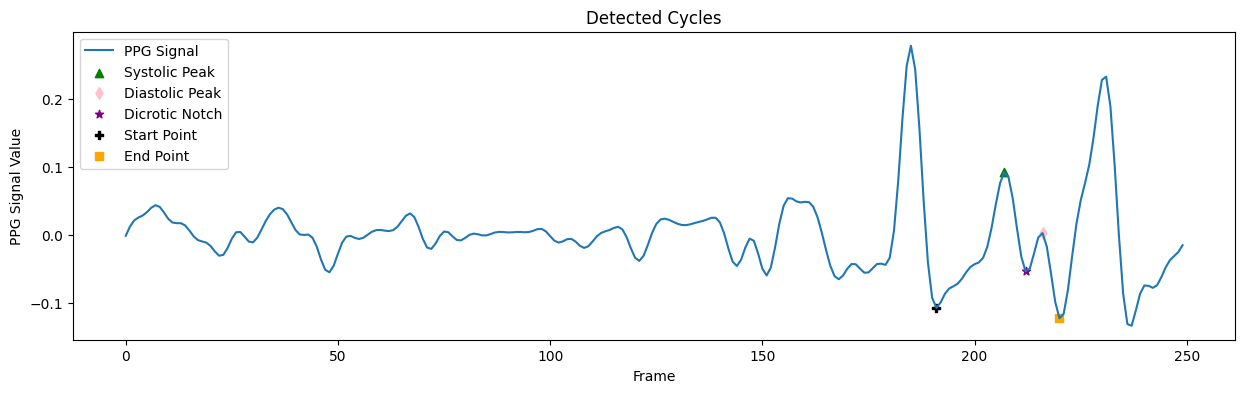

Detected PPG cycles for block 0, 5: [(191, 207, 212, 216, 220)]
Sorted PPG cycles: [(191, 207, 212, 216, 220)]
Selected PPG cycles {i}, {j}: [(191, 207, 212, 216, 220), (191, 207, 212, 216, 220), (191, 207, 212, 216, 220)]
Merged PPG signal: [-0.10691657 -0.09908324 -0.08643038 -0.0785771  -0.07528276 -0.07158873
 -0.06431869 -0.05483125 -0.04695281 -0.04281208 -0.04023716 -0.03356915
 -0.01717083  0.0105968   0.04512805  0.07629628  0.09216464  0.0844448
  0.05335038  0.00910233 -0.03158273 -0.05314285 -0.04931757 -0.02710087
 -0.00363148  0.00289087 -0.01655263 -0.05626234 -0.09837308 -0.1222576 ]


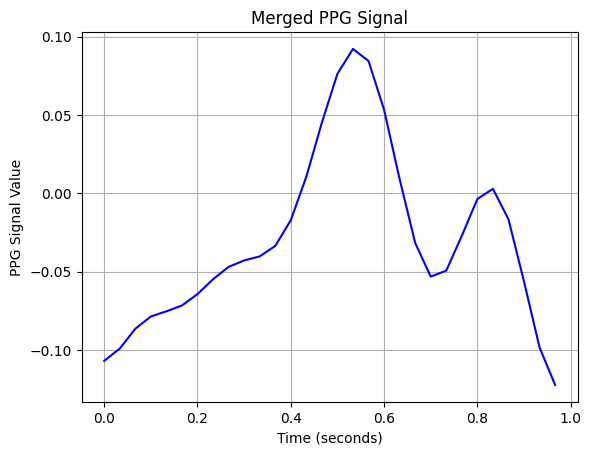

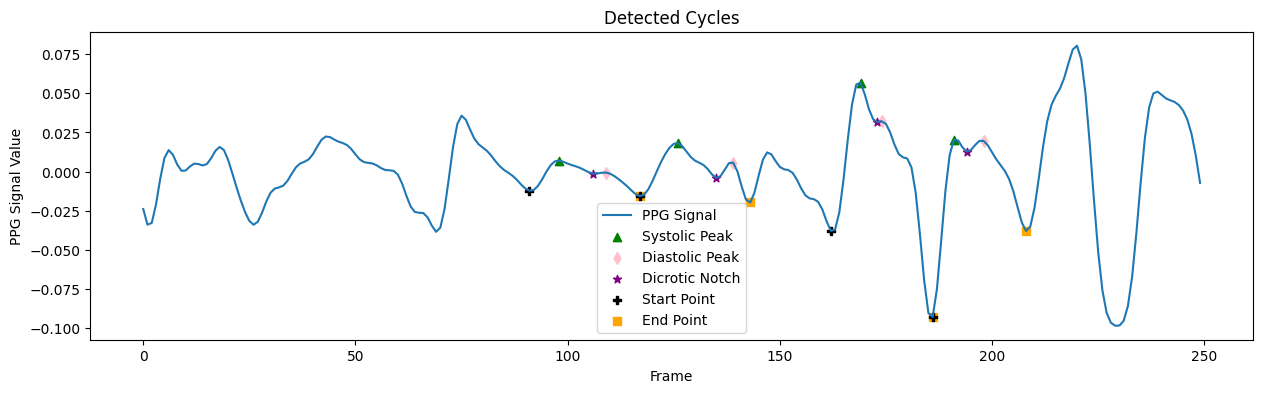

Detected PPG cycles for block 0, 6: [(91, 98, 106, 109, 117), (117, 126, 135, 139, 143), (162, 169, 173, 174, 186), (186, 191, 194, 198, 208)]
Sorted PPG cycles: [(186, 191, 194, 198, 208), (162, 169, 173, 174, 186), (117, 126, 135, 139, 143), (91, 98, 106, 109, 117)]
Selected PPG cycles {i}, {j}: [(186, 191, 194, 198, 208), (162, 169, 173, 174, 186), (117, 126, 135, 139, 143)]
Merged PPG signal: [-0.0487715  -0.04234822 -0.02724743 -0.0078127   0.01039383  0.02311564
  0.02893289  0.02918097  0.02663056  0.02385946  0.02215982  0.02134533
  0.02033067  0.01806148  0.0142859   0.00974364  0.00562166  0.00255992
 -0.00011896 -0.00426441 -0.01167028 -0.02241708 -0.03395486 -0.03011446
 -0.03412797 -0.00596293 -0.00658486]


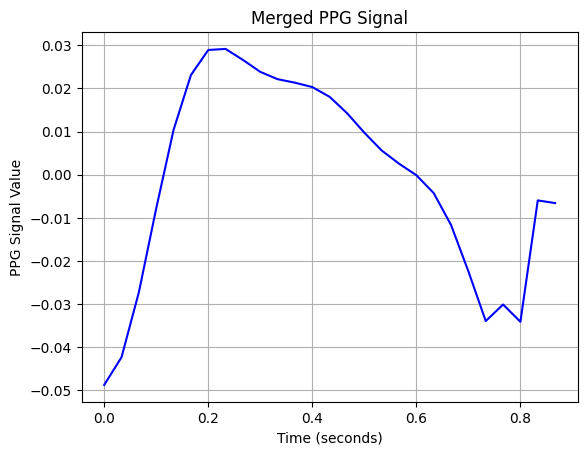

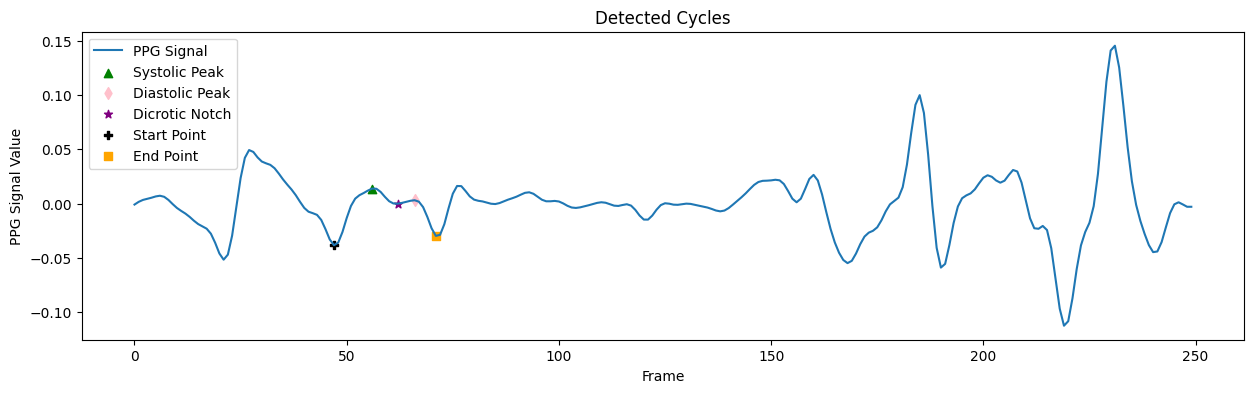

Detected PPG cycles for block 0, 7: [(47, 56, 62, 66, 71)]
Sorted PPG cycles: [(47, 56, 62, 66, 71)]
Selected PPG cycles {i}, {j}: [(47, 56, 62, 66, 71), (47, 56, 62, 66, 71), (47, 56, 62, 66, 71)]
Merged PPG signal: [-3.83950051e-02 -3.59889665e-02 -2.62482575e-02 -1.33459910e-02
 -2.24181958e-03  4.51020564e-03  7.69414101e-03  9.69802602e-03
  1.19470939e-02  1.37967461e-02  1.36046290e-02  1.06755270e-02
  6.15303106e-03  2.13939122e-03  5.85140264e-05 -1.46502178e-04
  5.87414305e-04  1.54207423e-03  2.51269002e-03  3.04531500e-03
  1.71509167e-03 -3.28942440e-03 -1.23271638e-02 -2.28082720e-02
 -2.97925686e-02]


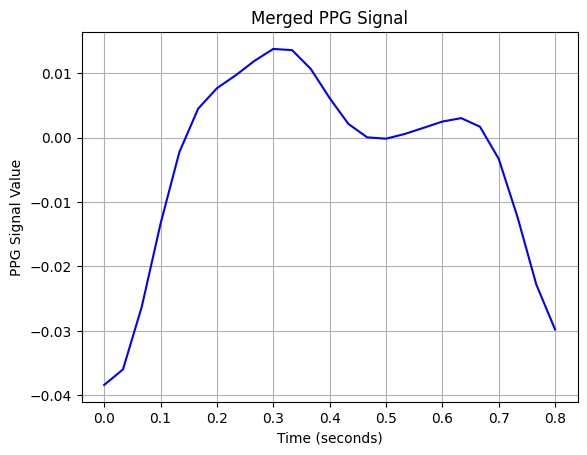

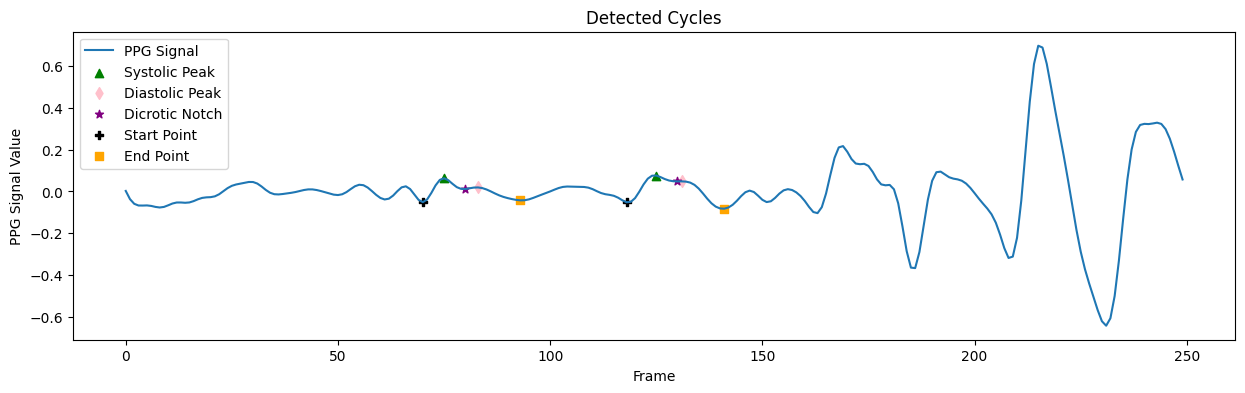

Detected PPG cycles for block 0, 8: [(70, 75, 80, 83, 93), (118, 125, 130, 131, 141)]
Sorted PPG cycles: [(118, 125, 130, 131, 141), (70, 75, 80, 83, 93)]
Selected PPG cycles {i}, {j}: [(118, 125, 130, 131, 141), (70, 75, 80, 83, 93), (118, 125, 130, 131, 141)]
Merged PPG signal: [-0.05163635 -0.04623943 -0.02400748  0.00862059  0.04041891  0.06143472
  0.06781244  0.06254532  0.05235376  0.04336629  0.03846303  0.03729548
  0.03791016  0.03821886  0.03645466  0.03105333  0.02083161  0.00568127
 -0.01286756 -0.03196178 -0.04859511 -0.06076955 -0.06775579 -0.06940845]


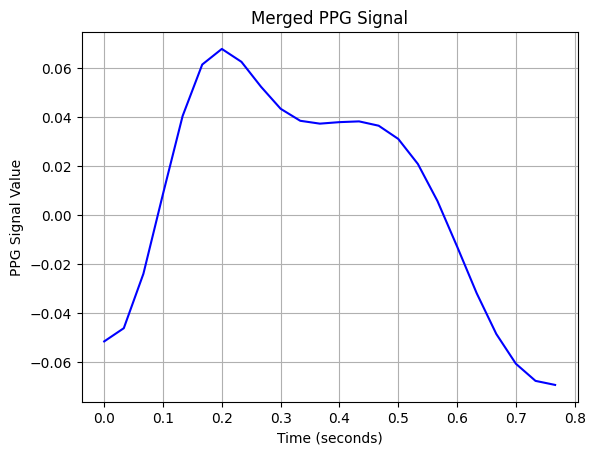

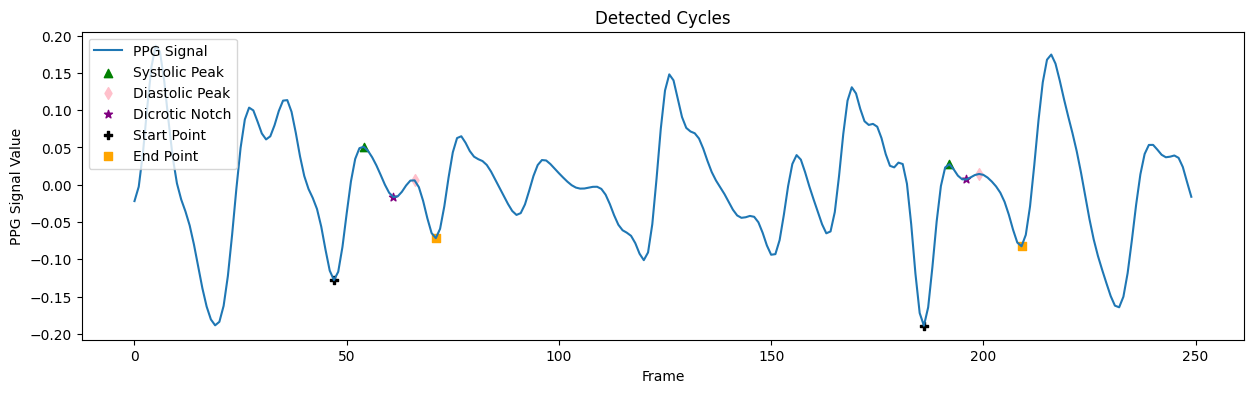

Detected PPG cycles for block 0, 9: [(47, 54, 61, 66, 71), (186, 192, 196, 199, 209)]
Sorted PPG cycles: [(186, 192, 196, 199, 209), (47, 54, 61, 66, 71)]
Selected PPG cycles {i}, {j}: [(186, 192, 196, 199, 209), (47, 54, 61, 66, 71), (186, 192, 196, 199, 209)]
Merged PPG signal: [-0.16859853 -0.14842409 -0.10125311 -0.04559515  0.00039237  0.02696612
  0.03472231  0.03084252  0.0233483   0.0171495   0.01337329  0.01097693
  0.00869637  0.00605831  0.0033657   0.00117841 -0.00030364 -0.00180508
 -0.00525486 -0.01330037 -0.02773908 -0.04736139 -0.06661542 -0.07659176
 -0.02385507]


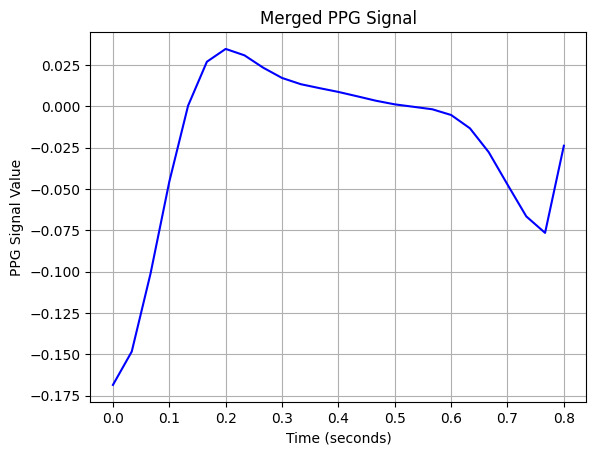

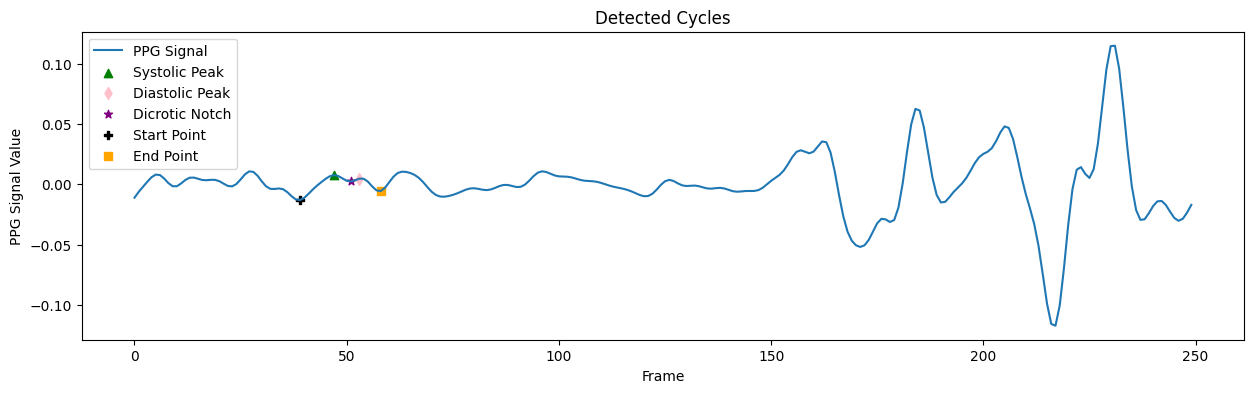

Detected PPG cycles for block 1, 0: [(39, 47, 51, 53, 58)]
Sorted PPG cycles: [(39, 47, 51, 53, 58)]
Selected PPG cycles {i}, {j}: [(39, 47, 51, 53, 58), (39, 47, 51, 53, 58), (39, 47, 51, 53, 58)]
Merged PPG signal: [-0.01303805 -0.01120445 -0.00789036 -0.00429319 -0.00107256  0.00180252
  0.00449983  0.00671616  0.0076997   0.00694845  0.00491655  0.00295924
  0.00239636  0.00341245  0.0047661   0.00467218  0.00223624 -0.00169345
 -0.00496945 -0.00557671]


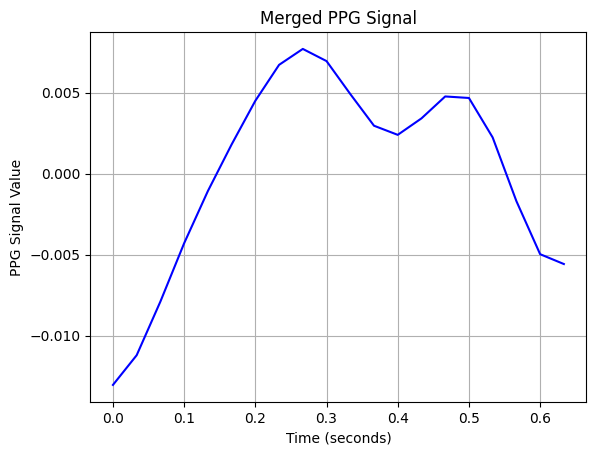

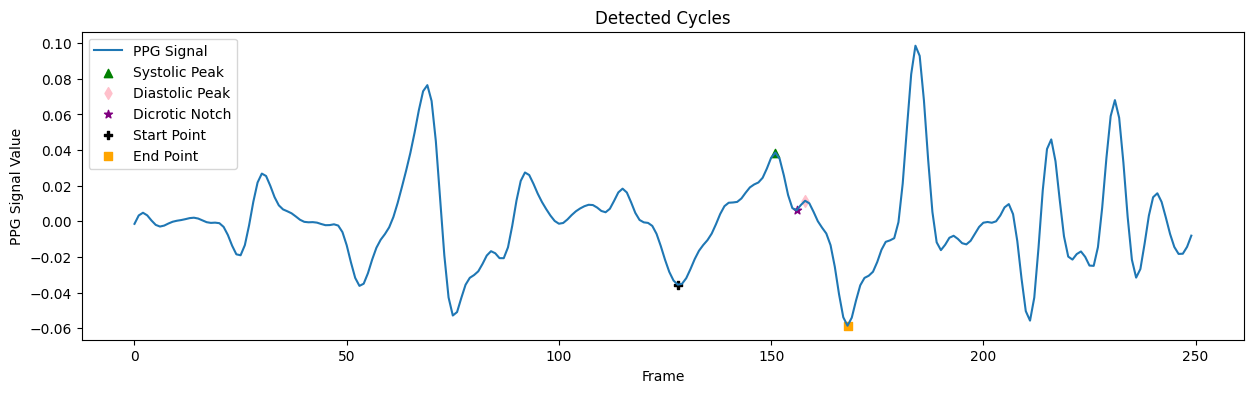

Detected PPG cycles for block 1, 1: [(128, 151, 156, 158, 168)]
Sorted PPG cycles: [(128, 151, 156, 158, 168)]
Selected PPG cycles {i}, {j}: [(128, 151, 156, 158, 168), (128, 151, 156, 158, 168), (128, 151, 156, 158, 168)]
Merged PPG signal: [-3.55454633e-02 -3.50791756e-02 -3.18984215e-02 -2.67712401e-02
 -2.11616743e-02 -1.65218952e-02 -1.32923101e-02 -1.05564665e-02
 -6.86251263e-03 -1.63065185e-03  4.12277352e-03  8.51783909e-03
  1.04415108e-02  1.05933853e-02  1.09115412e-02  1.28443669e-02
  1.60907804e-02  1.90668117e-02  2.07075381e-02  2.18156164e-02
  2.44448834e-02  2.96517133e-02  3.56865063e-02  3.85957168e-02
  3.51479186e-02  2.57538502e-02  1.47382452e-02  7.42193200e-03
  6.24878251e-03  9.15413548e-03  1.15411953e-02  1.01309609e-02
  5.32539423e-03  7.92881308e-05 -3.54547887e-03 -6.82435045e-03
 -1.33733101e-02 -2.54505137e-02 -4.09171917e-02 -5.38425156e-02
 -5.85885269e-02]


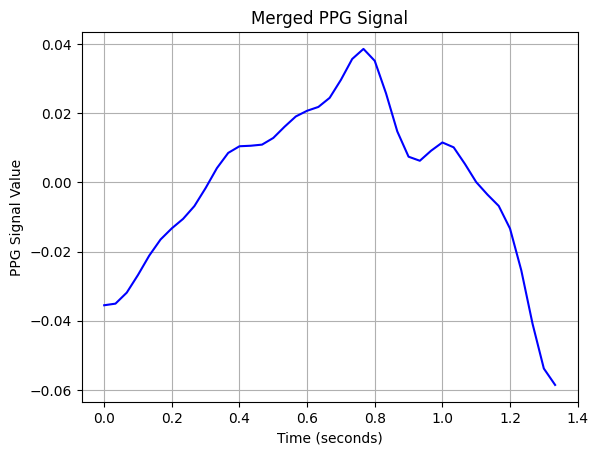

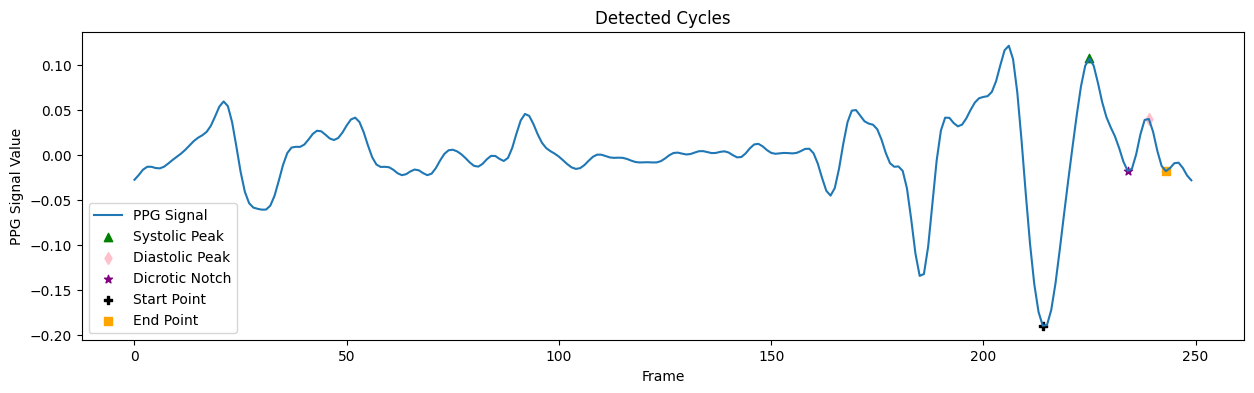

Detected PPG cycles for block 1, 2: [(214, 225, 234, 239, 243)]
Sorted PPG cycles: [(214, 225, 234, 239, 243)]
Selected PPG cycles {i}, {j}: [(214, 225, 234, 239, 243), (214, 225, 234, 239, 243), (214, 225, 234, 239, 243)]
Merged PPG signal: [-0.19004052 -0.18916304 -0.17244032 -0.14284016 -0.10569038 -0.06648833
 -0.02835409  0.00842108  0.04403326  0.07610608  0.09906703  0.10719267
  0.09914163  0.08000639  0.05863148  0.04192801  0.03072028  0.02065593
  0.00752117 -0.0075653  -0.01774307 -0.0155508   0.00037177  0.02260296
  0.03886031  0.03989238  0.02551662  0.00436347 -0.01231922 -0.01808916]


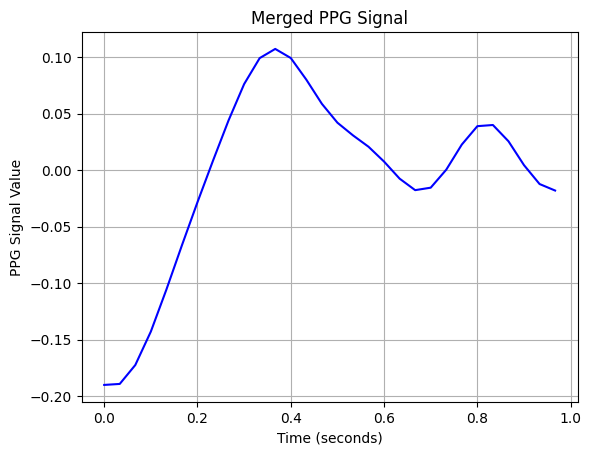

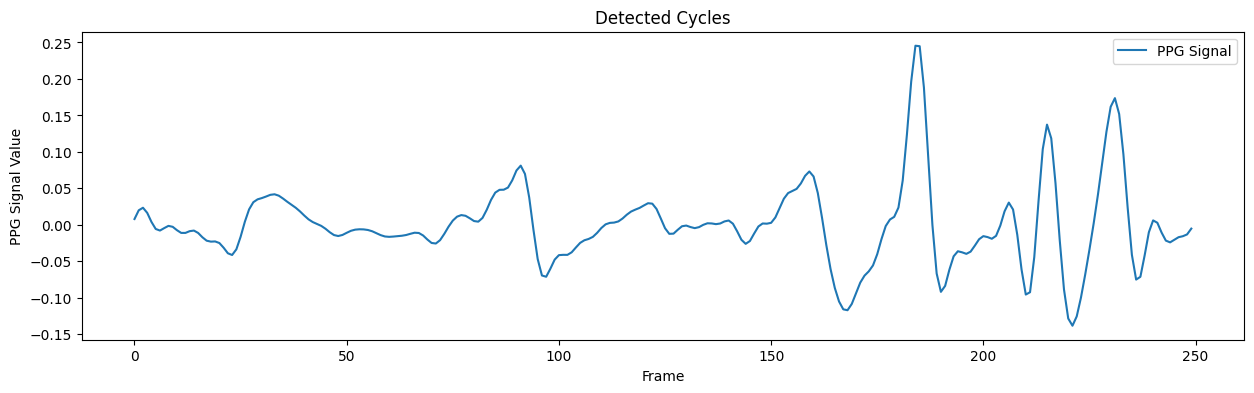

Detected PPG cycles for block 1, 3: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


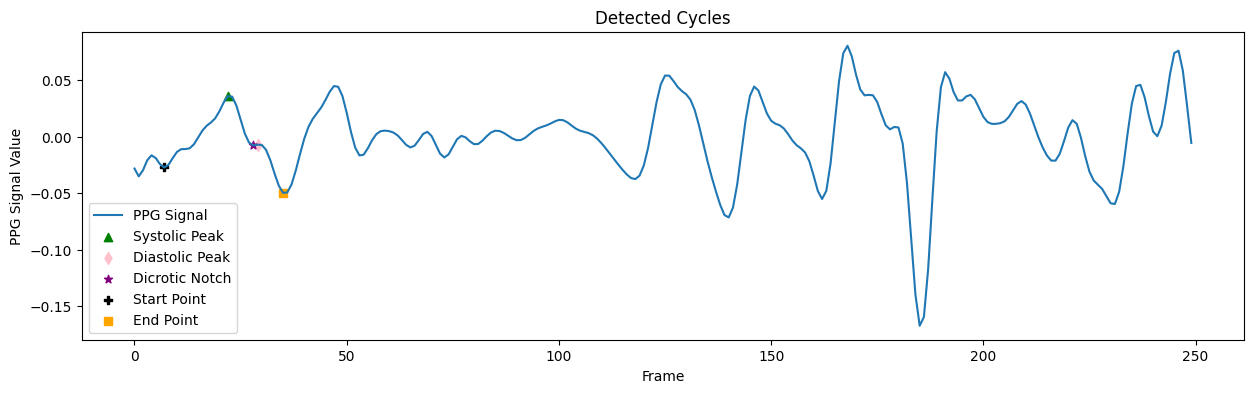

Detected PPG cycles for block 1, 4: [(7, 22, 28, 29, 35)]
Sorted PPG cycles: [(7, 22, 28, 29, 35)]
Selected PPG cycles {i}, {j}: [(7, 22, 28, 29, 35), (7, 22, 28, 29, 35), (7, 22, 28, 29, 35)]
Merged PPG signal: [-0.02734025 -0.02501934 -0.01910829 -0.01360466 -0.01115512 -0.01105404
 -0.01036748 -0.00683662 -0.00083297  0.00527583  0.00956223  0.01241333
  0.01608116  0.02229188  0.03005958  0.03571666  0.0353119   0.02755172
  0.01499823  0.0025967  -0.00538466 -0.00784239 -0.0071646  -0.00742068
 -0.01180047 -0.0209037  -0.0326406  -0.04342074 -0.04974699]


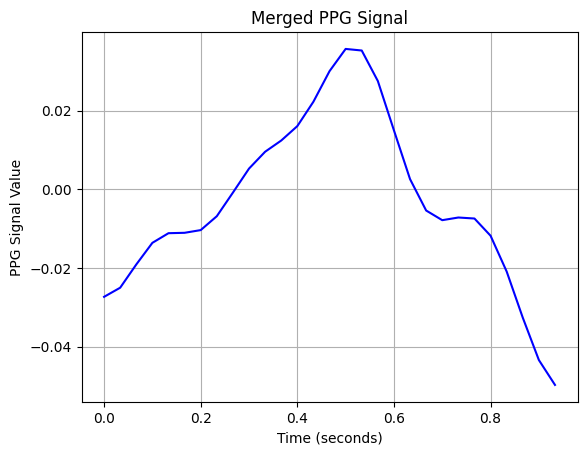

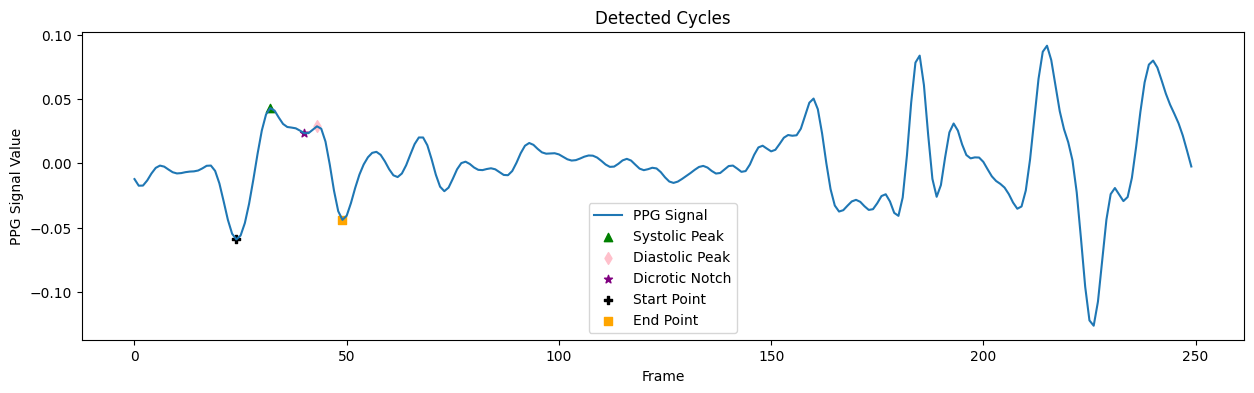

Detected PPG cycles for block 1, 5: [(24, 32, 40, 43, 49)]
Sorted PPG cycles: [(24, 32, 40, 43, 49)]
Selected PPG cycles {i}, {j}: [(24, 32, 40, 43, 49), (24, 32, 40, 43, 49), (24, 32, 40, 43, 49)]
Merged PPG signal: [-0.05920578 -0.05621799 -0.0465301  -0.03146326 -0.01266962  0.0074771
  0.02561771  0.03817775  0.04307265  0.04109897  0.03566097  0.03070989
  0.02833267  0.02787618  0.02729209  0.02548584  0.02352764  0.02353786
  0.02614892  0.02885615  0.02700052  0.01696665 -0.00076853 -0.02116623
 -0.03724867 -0.04398878]


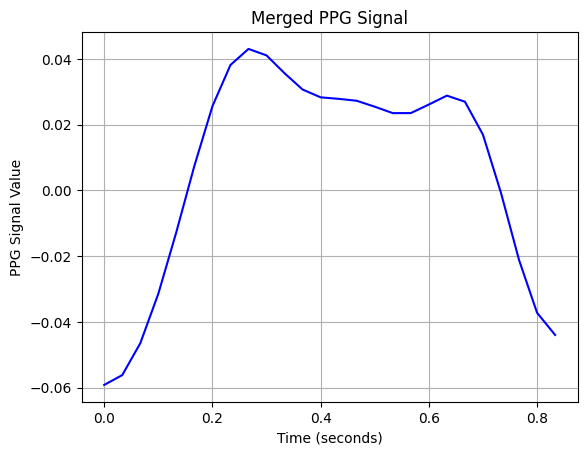

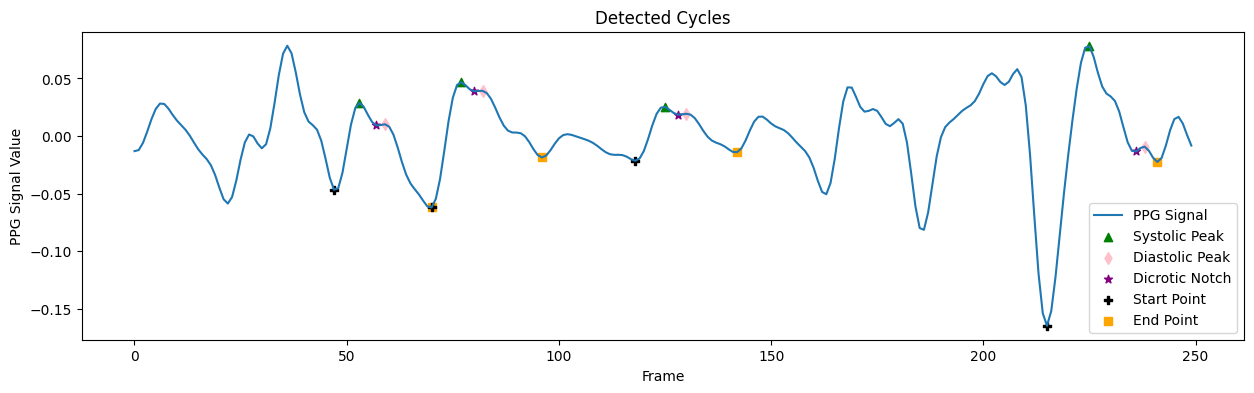

Detected PPG cycles for block 1, 6: [(47, 53, 57, 59, 70), (70, 77, 80, 82, 96), (118, 125, 128, 130, 142), (215, 225, 236, 238, 241)]
Sorted PPG cycles: [(215, 225, 236, 238, 241), (118, 125, 128, 130, 142), (70, 77, 80, 82, 96), (47, 53, 57, 59, 70)]
Selected PPG cycles {i}, {j}: [(215, 225, 236, 238, 241), (118, 125, 128, 130, 142), (70, 77, 80, 82, 96)]
Merged PPG signal: [-0.08277288 -0.07537588 -0.0576157  -0.03376542 -0.00915684  0.0119495
  0.02756436  0.03775505  0.04352417  0.04579042  0.04513454  0.04215937
  0.03778198  0.03298043  0.02820285  0.02310562  0.01703731  0.00994165
  0.00283921 -0.00268357 -0.00567182 -0.00667333 -0.0074267  -0.00947119
 -0.01275078 -0.01183587 -0.01373639]


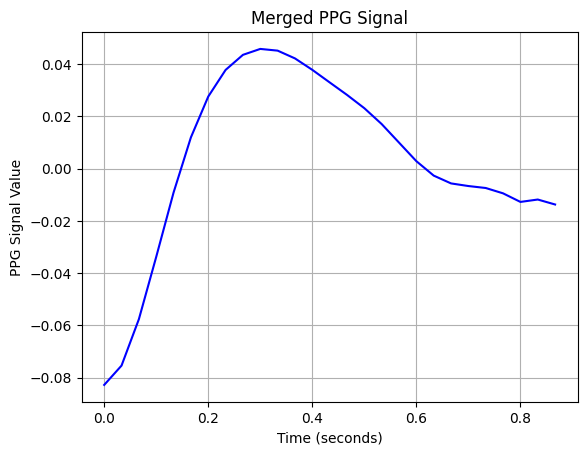

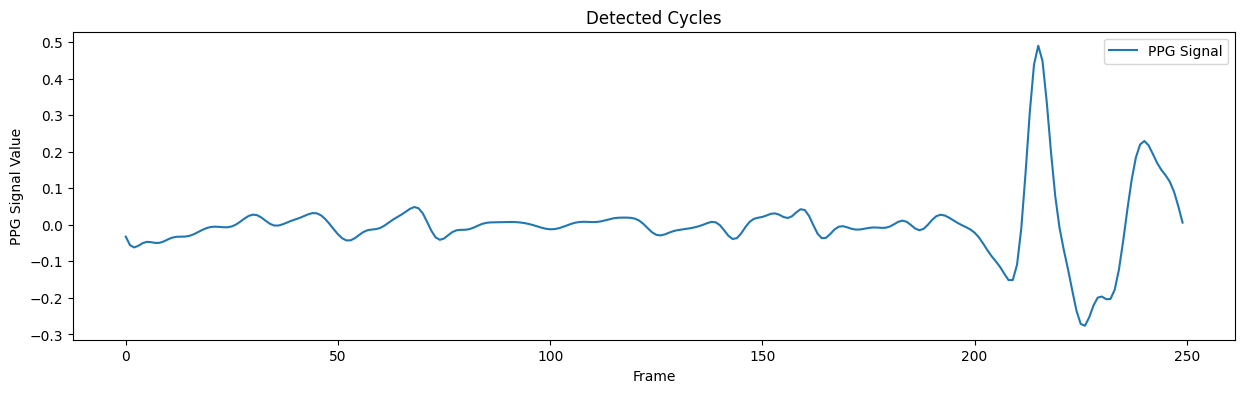

Detected PPG cycles for block 1, 7: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


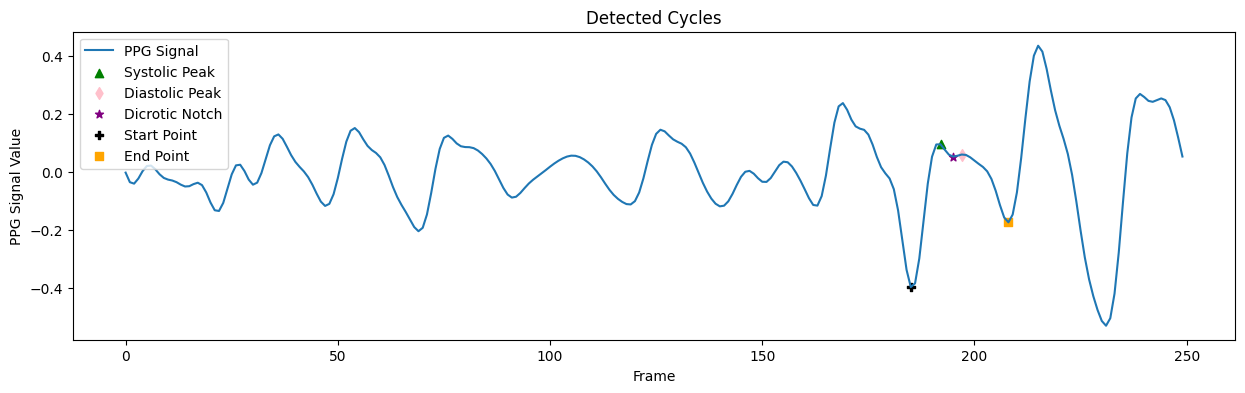

Detected PPG cycles for block 1, 8: [(185, 192, 195, 197, 208)]
Sorted PPG cycles: [(185, 192, 195, 197, 208)]
Selected PPG cycles {i}, {j}: [(185, 192, 195, 197, 208), (185, 192, 195, 197, 208), (185, 192, 195, 197, 208)]
Merged PPG signal: [-0.39725462 -0.38440851 -0.29878021 -0.16963621 -0.04050648  0.05226457
  0.09441846  0.09509081  0.07633226  0.05888635  0.05263538  0.05560971
  0.05975976  0.0583462   0.05013839  0.03858288  0.02751258  0.01689588
  0.00177871 -0.02459407 -0.0651668  -0.11433851 -0.15721659 -0.17392183]


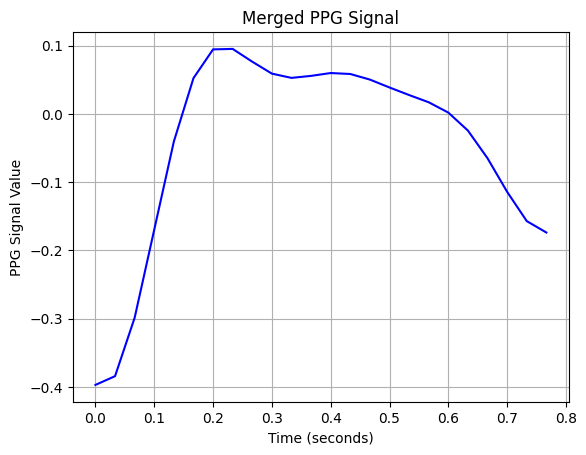

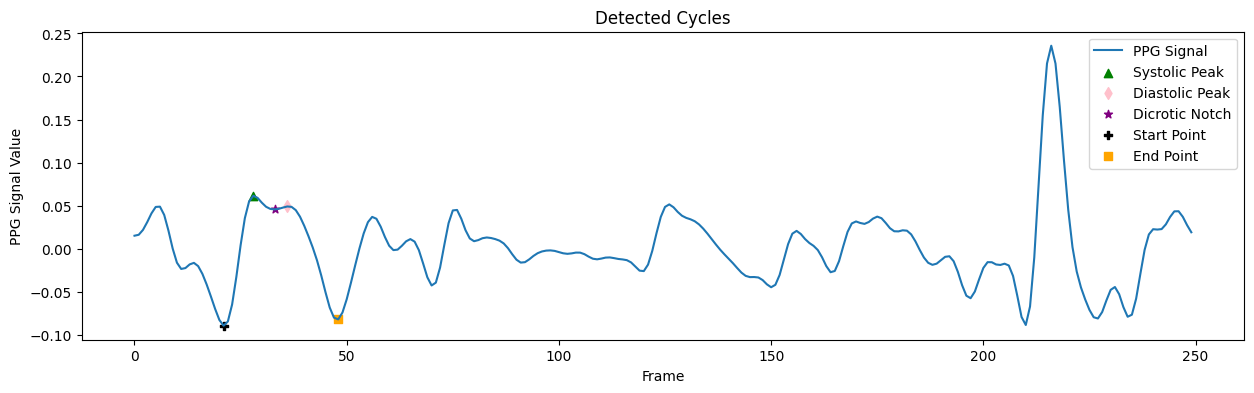

Detected PPG cycles for block 1, 9: [(21, 28, 33, 36, 48)]
Sorted PPG cycles: [(21, 28, 33, 36, 48)]
Selected PPG cycles {i}, {j}: [(21, 28, 33, 36, 48), (21, 28, 33, 36, 48), (21, 28, 33, 36, 48)]
Merged PPG signal: [-0.08941714 -0.08446737 -0.06476063 -0.0326562   0.00400065  0.03545743
  0.05492317  0.06143553  0.05904932  0.05345017  0.04871356  0.04622325
  0.04564856  0.04634447  0.04778118  0.04905709  0.0485999   0.04480876
  0.03715568  0.0265544   0.01443826  0.00134792 -0.01350589 -0.03104885
 -0.05045497 -0.06834123 -0.08002686 -0.08206358]


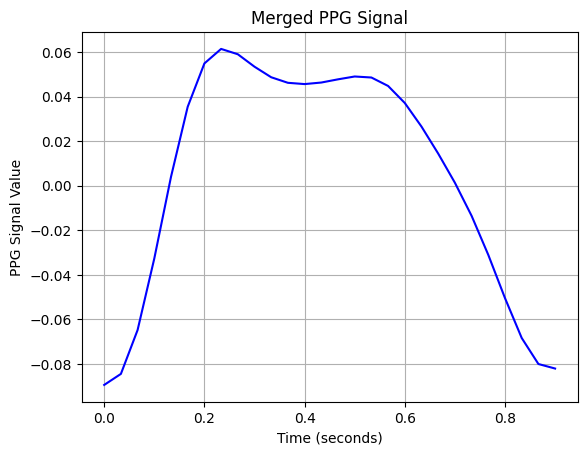

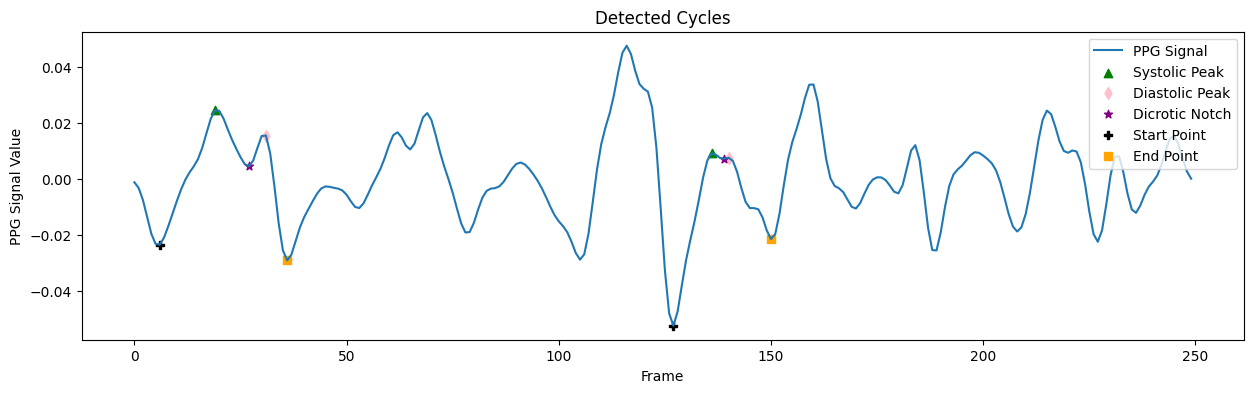

Detected PPG cycles for block 2, 0: [(6, 19, 27, 31, 36), (127, 136, 139, 140, 150)]
Sorted PPG cycles: [(127, 136, 139, 140, 150), (6, 19, 27, 31, 36)]
Selected PPG cycles {i}, {j}: [(127, 136, 139, 140, 150), (6, 19, 27, 31, 36), (127, 136, 139, 140, 150)]
Merged PPG signal: [-0.04261878 -0.03838834 -0.03078955 -0.02329924 -0.01704603 -0.01123022
 -0.00501119  0.00115717  0.0059195   0.00848889  0.00952685  0.01047265
  0.0120022   0.01321532  0.01244268  0.00894263  0.00383083 -0.00071616
 -0.00327656 -0.00429427 -0.00540231 -0.00759046 -0.00999603 -0.01054892
  0.00511781  0.00516704  0.00306255 -0.00086463 -0.00524627 -0.00847782
 -0.00965473]


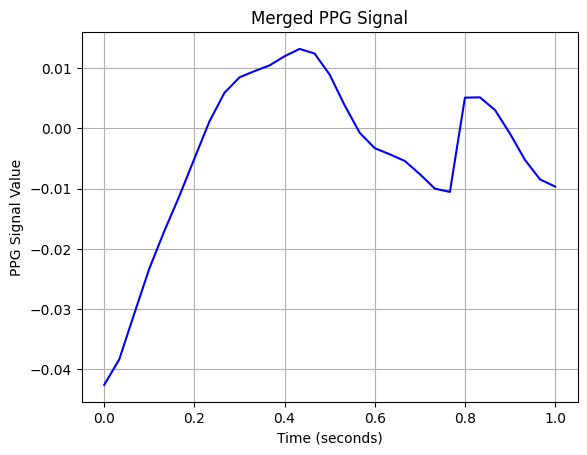

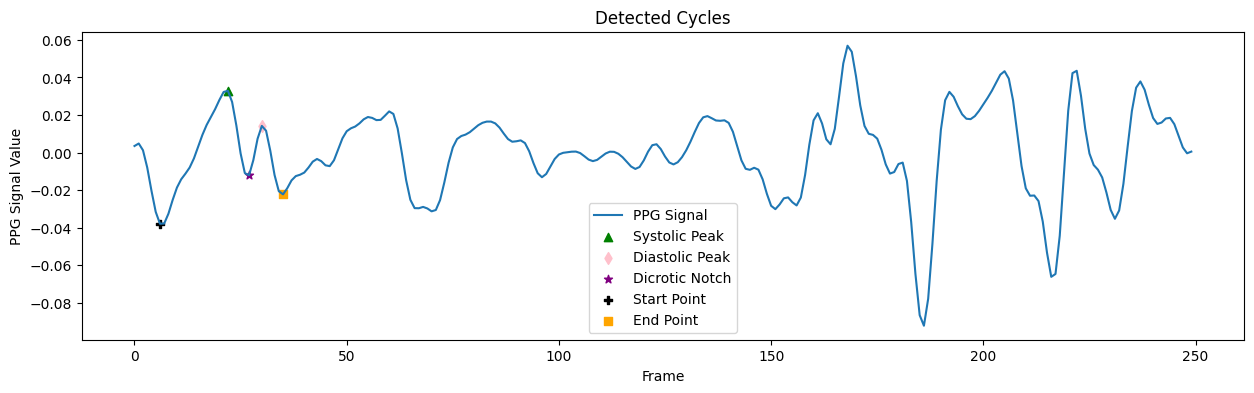

Detected PPG cycles for block 2, 1: [(6, 22, 27, 30, 35)]
Sorted PPG cycles: [(6, 22, 27, 30, 35)]
Selected PPG cycles {i}, {j}: [(6, 22, 27, 30, 35), (6, 22, 27, 30, 35), (6, 22, 27, 30, 35)]
Merged PPG signal: [-0.03794535 -0.0378289  -0.03257321 -0.02522085 -0.01869503 -0.01427754
 -0.01128085 -0.00799472 -0.00316955  0.00304571  0.0093827   0.0146715
  0.01890869  0.02312096  0.02796414  0.03223566  0.03286254  0.02691165
  0.01438964 -0.00047108 -0.01098261 -0.01209919 -0.00405155  0.00732578
  0.01415642  0.01161239  0.00089831 -0.01198218 -0.02060756 -0.02228634]


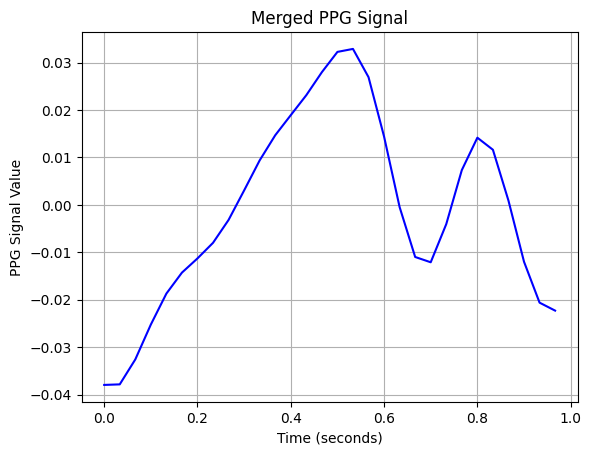

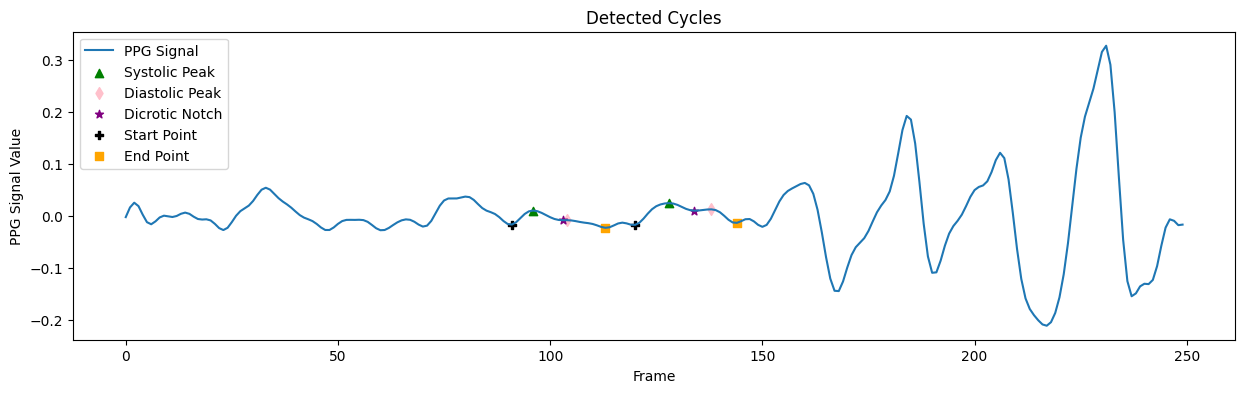

Detected PPG cycles for block 2, 2: [(91, 96, 103, 104, 113), (120, 128, 134, 138, 144)]
Sorted PPG cycles: [(120, 128, 134, 138, 144), (91, 96, 103, 104, 113)]
Selected PPG cycles {i}, {j}: [(120, 128, 134, 138, 144), (91, 96, 103, 104, 113), (120, 128, 134, 138, 144)]
Merged PPG signal: [-0.01681846 -0.01264284 -0.00463038  0.00441413  0.0117367   0.01611805
  0.01792584  0.01809297  0.0171675   0.0152141   0.01235756  0.00917835
  0.00649123  0.00479477  0.00402001  0.0038058   0.00389245  0.00410682
  0.00396402  0.0025032  -0.00113178 -0.00667265 -0.01228081 -0.00823415
 -0.00873312]


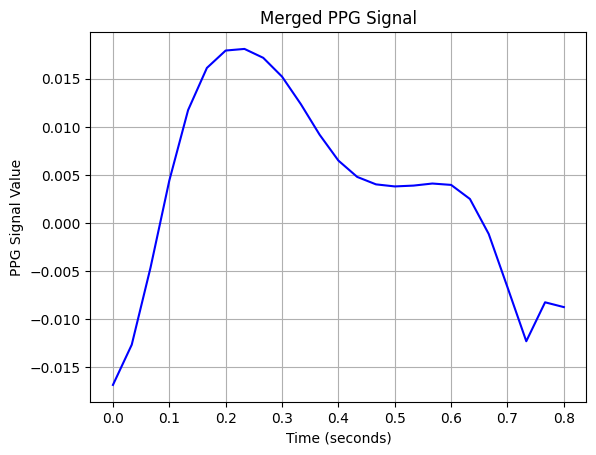

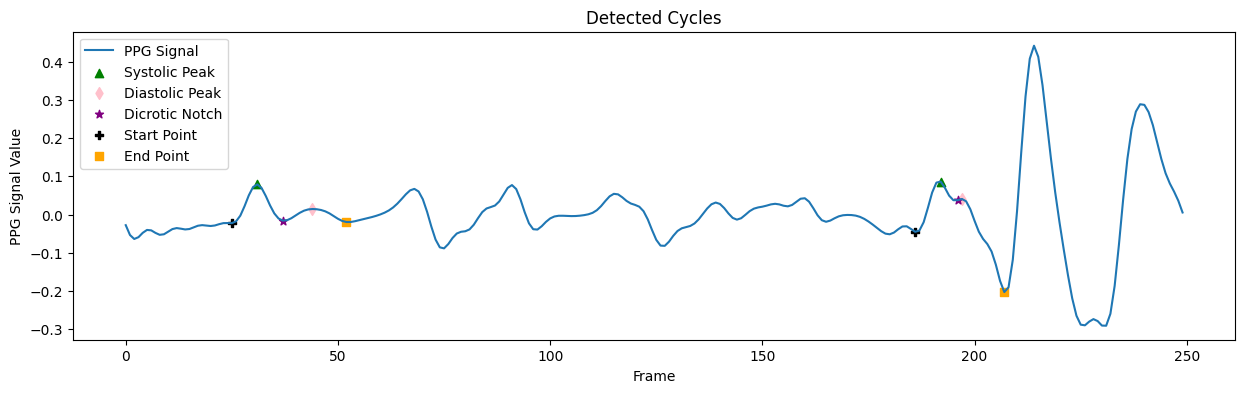

Detected PPG cycles for block 2, 3: [(25, 31, 37, 44, 52), (186, 192, 196, 197, 207)]
Sorted PPG cycles: [(186, 192, 196, 197, 207), (25, 31, 37, 44, 52)]
Selected PPG cycles {i}, {j}: [(186, 192, 196, 197, 207), (25, 31, 37, 44, 52), (186, 192, 196, 197, 207)]
Merged PPG signal: [-0.0375612  -0.03374274 -0.01424851  0.01912145  0.05523393  0.07970492
  0.08384235  0.06997315  0.04916026  0.03305347  0.02607968  0.02375582
  0.01792974  0.00426047 -0.01431188 -0.03078725 -0.04099959 -0.0480356
 -0.0600056  -0.08244132 -0.11112587 -0.13121209  0.00282451  0.0010237
 -0.00129672 -0.0036959  -0.0055756  -0.00651212]


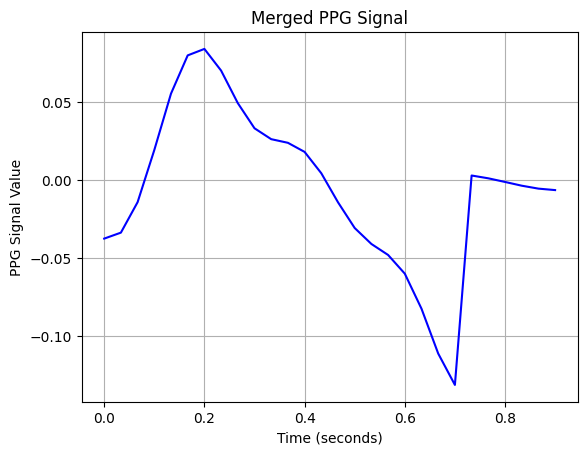

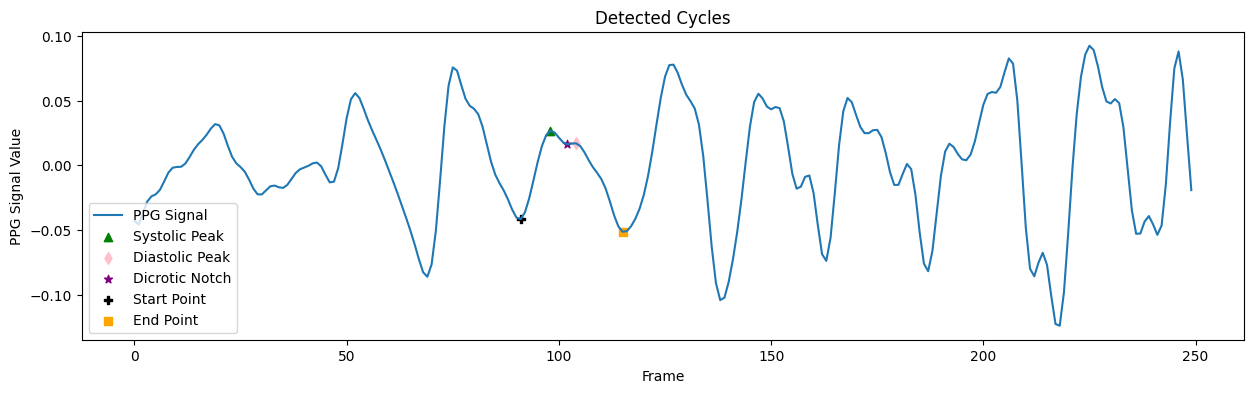

Detected PPG cycles for block 2, 4: [(91, 98, 102, 104, 115)]
Sorted PPG cycles: [(91, 98, 102, 104, 115)]
Selected PPG cycles {i}, {j}: [(91, 98, 102, 104, 115), (91, 98, 102, 104, 115), (91, 98, 102, 104, 115)]
Merged PPG signal: [-0.04142073 -0.03615416 -0.02541048 -0.01157464  0.00267107  0.01494259
  0.02330884  0.0266476   0.025308    0.0213568   0.0176803   0.01622966
  0.01672877  0.01703394  0.0149756   0.01014542  0.00406769 -0.00137223
 -0.0057739  -0.0106169  -0.01781796 -0.02775172 -0.03851332 -0.04705858
 -0.0511953 ]


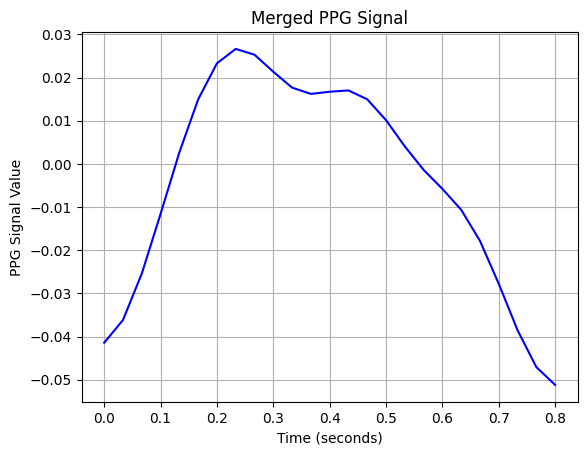

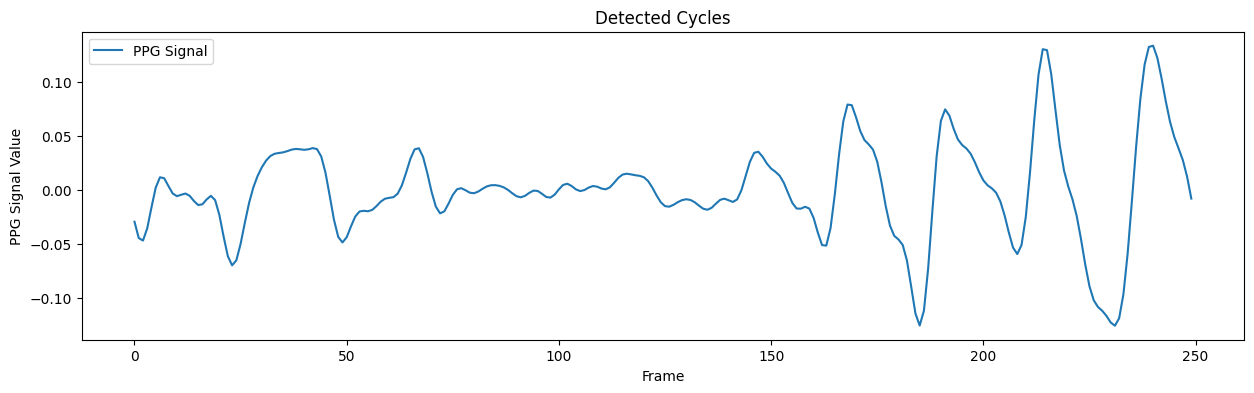

Detected PPG cycles for block 2, 5: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


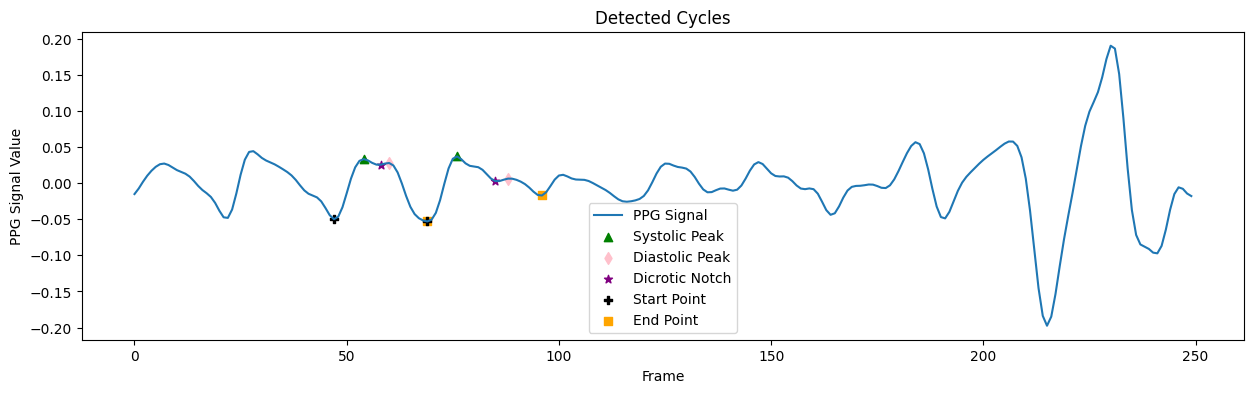

Detected PPG cycles for block 2, 6: [(47, 54, 58, 60, 69), (69, 76, 85, 88, 96)]
Sorted PPG cycles: [(69, 76, 85, 88, 96), (47, 54, 58, 60, 69)]
Selected PPG cycles {i}, {j}: [(69, 76, 85, 88, 96), (47, 54, 58, 60, 69), (69, 76, 85, 88, 96)]
Merged PPG signal: [-0.05196218 -0.04920245 -0.03855716 -0.02033331  0.00152401  0.02093933
  0.03284409  0.03584442  0.03259093  0.02767182  0.02459638  0.02395301
  0.02379827  0.02165324  0.01646086  0.00916694  0.00180511 -0.00395751
 -0.00769272 -0.01006145 -0.0120266  -0.01412811 -0.01623453 -0.00086115
 -0.00403777 -0.00781312 -0.01086531 -0.0113771 ]


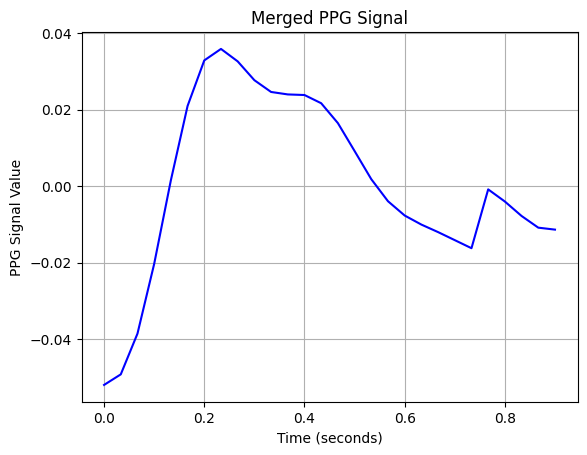

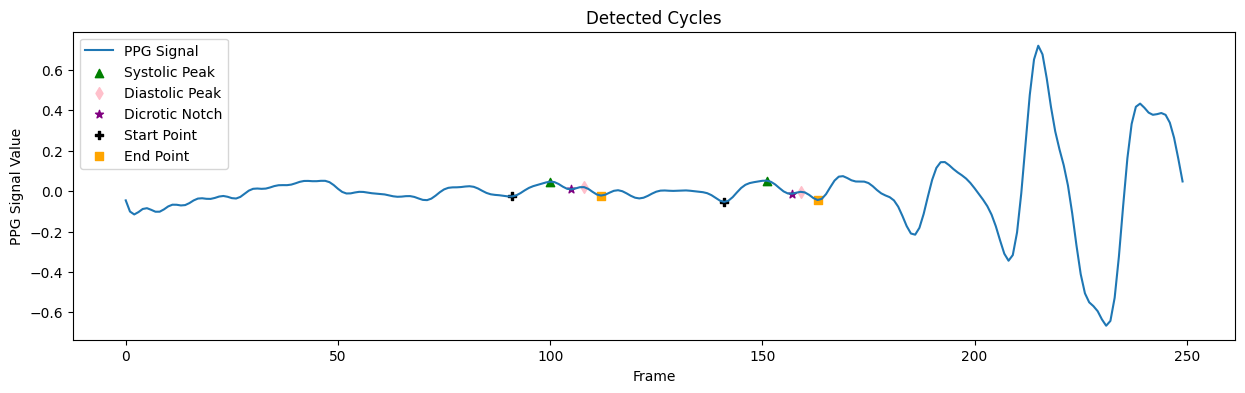

Detected PPG cycles for block 2, 7: [(91, 100, 105, 108, 112), (141, 151, 157, 159, 163)]
Sorted PPG cycles: [(141, 151, 157, 159, 163), (91, 100, 105, 108, 112)]
Selected PPG cycles {i}, {j}: [(141, 151, 157, 159, 163), (91, 100, 105, 108, 112), (141, 151, 157, 159, 163)]
Merged PPG signal: [-0.0442861  -0.03860238 -0.02324977 -0.00299757  0.01579633  0.02903673
  0.03674461  0.04169691  0.04620647  0.04976979  0.04944849  0.04256413
  0.02946045  0.01410183  0.00197693 -0.00324055 -0.00199706  0.00138174
  0.00133295 -0.00546813 -0.0177947  -0.03006401 -0.02923764]


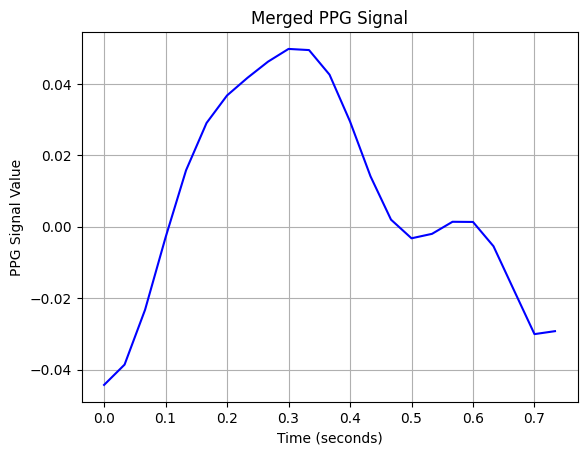

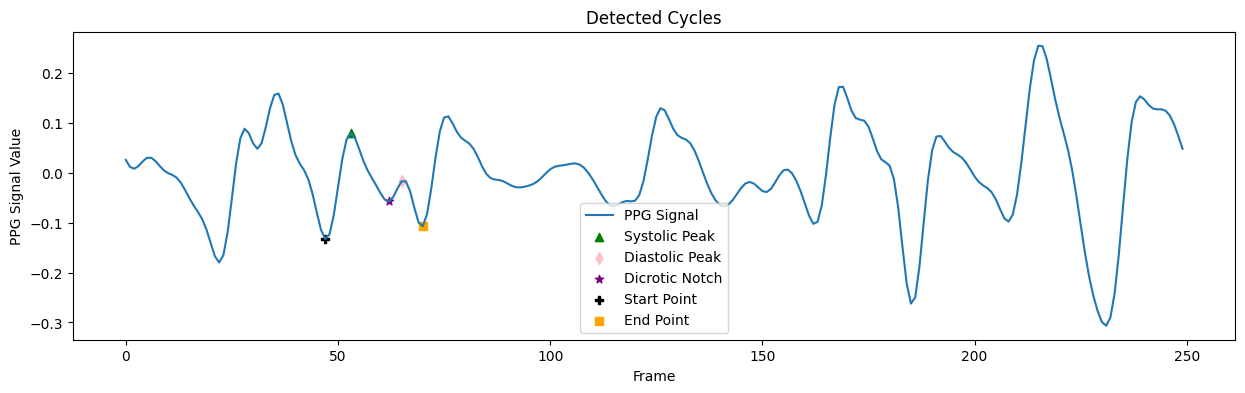

Detected PPG cycles for block 2, 8: [(47, 53, 62, 65, 70)]
Sorted PPG cycles: [(47, 53, 62, 65, 70)]
Selected PPG cycles {i}, {j}: [(47, 53, 62, 65, 70), (47, 53, 62, 65, 70), (47, 53, 62, 65, 70)]
Merged PPG signal: [-0.1327214  -0.12348448 -0.08573735 -0.02993204  0.02615832  0.06544797
  0.07912307  0.06957101  0.04717784  0.02331536  0.00415939 -0.01082712
 -0.02534    -0.04083883 -0.05376591 -0.0577418  -0.04919838 -0.03205699
 -0.01739564 -0.01744761 -0.03740404 -0.07045163 -0.09979831 -0.10711759]


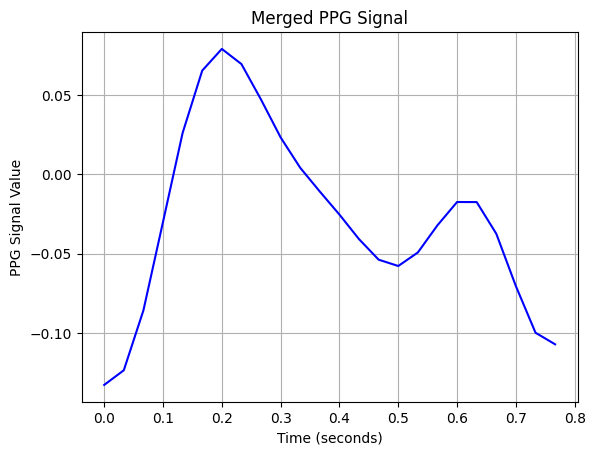

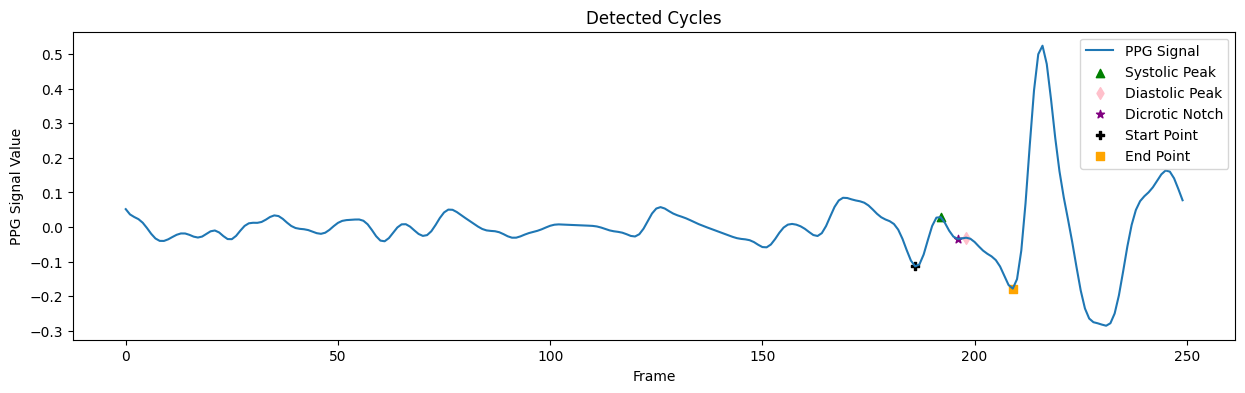

Detected PPG cycles for block 2, 9: [(186, 192, 196, 198, 209)]
Sorted PPG cycles: [(186, 192, 196, 198, 209)]
Selected PPG cycles {i}, {j}: [(186, 192, 196, 198, 209), (186, 192, 196, 198, 209), (186, 192, 196, 198, 209)]
Merged PPG signal: [-0.11345624 -0.10774431 -0.07917378 -0.03698261  0.00331623  0.0273043
  0.02879476  0.01237162 -0.01022725 -0.02742521 -0.03404769 -0.03277722
 -0.03063644 -0.03357958 -0.04298471 -0.05587917 -0.06796794 -0.07703323
 -0.08463584 -0.09534065 -0.11375229 -0.14027155 -0.16720501 -0.17773763]


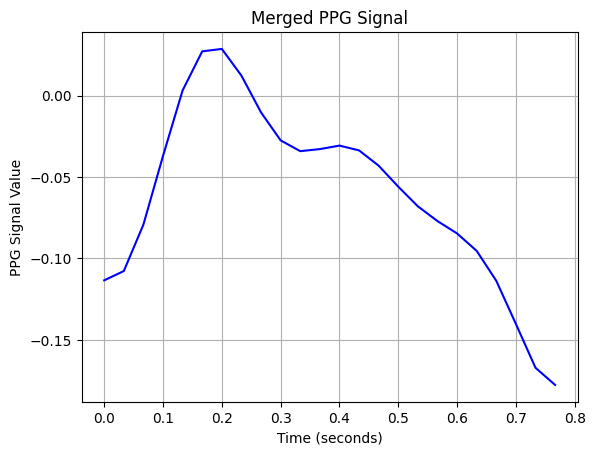

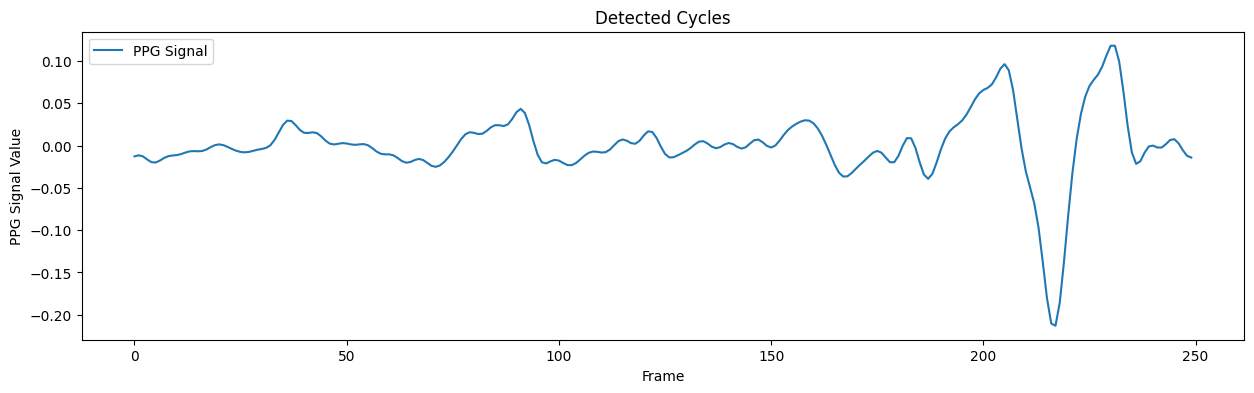

Detected PPG cycles for block 3, 0: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


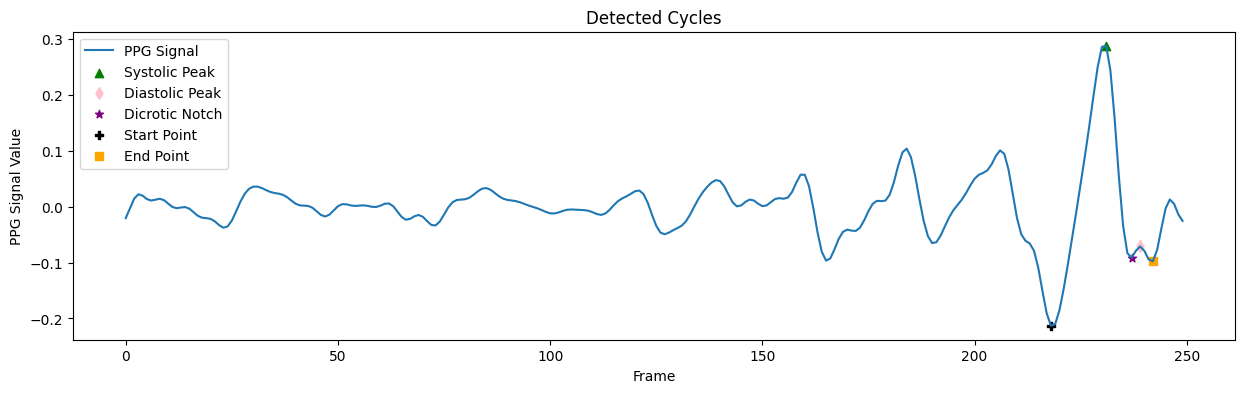

Detected PPG cycles for block 3, 1: [(218, 231, 237, 239, 242)]
Sorted PPG cycles: [(218, 231, 237, 239, 242)]
Selected PPG cycles {i}, {j}: [(218, 231, 237, 239, 242), (218, 231, 237, 239, 242), (218, 231, 237, 239, 242)]
Merged PPG signal: [-0.21289907 -0.20981806 -0.18494162 -0.146582   -0.1021837  -0.05553451
 -0.00776761  0.04082456  0.09052551  0.14251177  0.1970232   0.24900255
  0.28509587  0.28712847  0.2427108   0.15654972  0.05296706 -0.03486072
 -0.08327314 -0.09138297 -0.0791449  -0.07129943 -0.07921674 -0.09435971
 -0.09782664]


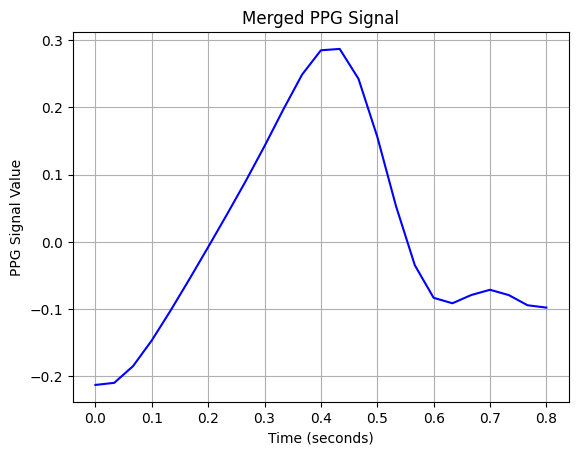

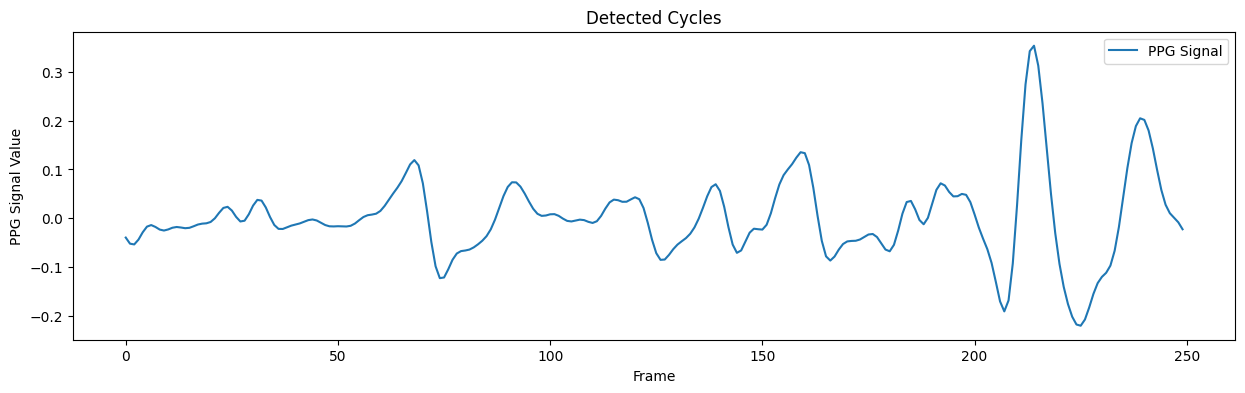

Detected PPG cycles for block 3, 2: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


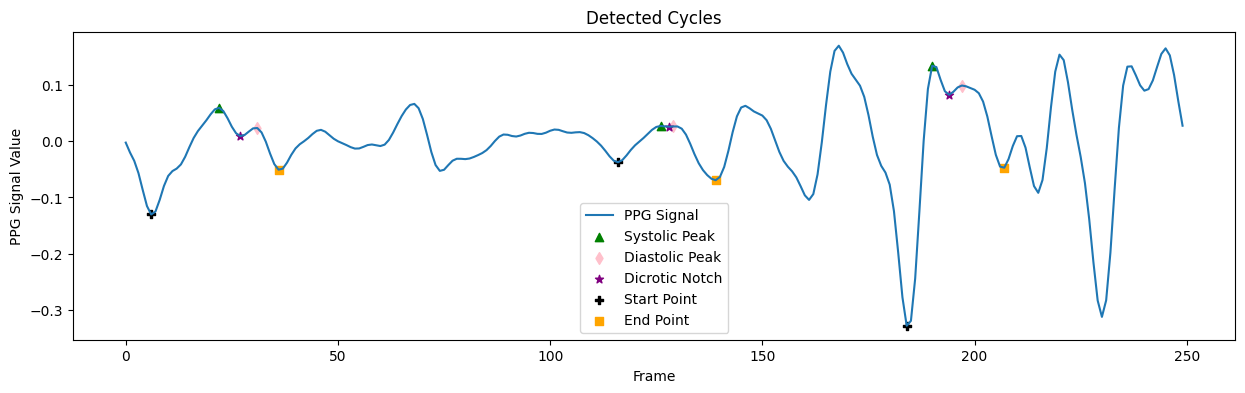

Detected PPG cycles for block 3, 3: [(6, 22, 27, 31, 36), (116, 126, 128, 129, 139), (184, 190, 194, 197, 207)]
Sorted PPG cycles: [(184, 190, 194, 197, 207), (116, 126, 128, 129, 139), (6, 22, 27, 31, 36)]
Selected PPG cycles {i}, {j}: [(184, 190, 194, 197, 207), (116, 126, 128, 129, 139), (6, 22, 27, 31, 36)]
Merged PPG signal: [-0.16524008 -0.15936413 -0.12460576 -0.07320553 -0.02284556  0.01288833
  0.03023248  0.03432853  0.03365708  0.03441372  0.03830371  0.04394181
  0.04947747  0.05398922  0.05704709  0.05765009  0.05401468  0.0445597
  0.02921857  0.01000491 -0.00949221 -0.02521186 -0.03373424 -0.03322662
  0.00754575  0.00775604  0.00515398 -0.00031575 -0.0073364  -0.01360189
 -0.01690173]


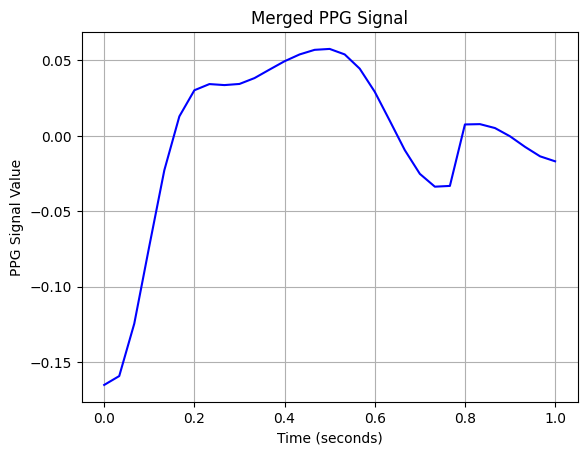

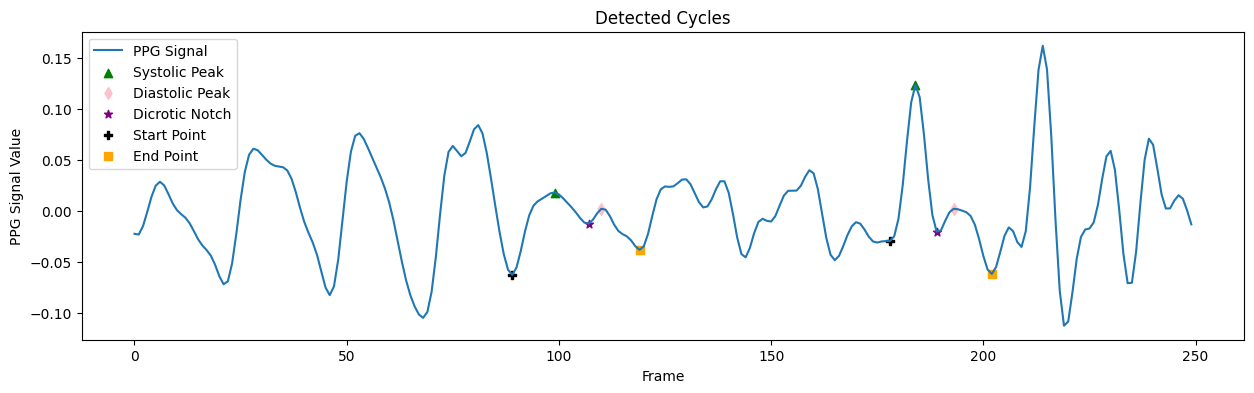

Detected PPG cycles for block 3, 4: [(89, 99, 107, 110, 119), (178, 184, 189, 193, 202)]
Sorted PPG cycles: [(178, 184, 189, 193, 202), (89, 99, 107, 110, 119)]
Selected PPG cycles {i}, {j}: [(178, 184, 189, 193, 202), (89, 99, 107, 110, 119), (178, 184, 189, 193, 202)]
Merged PPG signal: [-0.04053548 -0.03506765 -0.01831872  0.01003104  0.04398191  0.07268466
  0.08560843  0.07831569  0.05504515  0.0263388   0.00325637 -0.00811763
 -0.00863604 -0.00386372  0.00027367  0.00090933 -0.00118713 -0.00359951
 -0.00493144 -0.00614744 -0.00977178 -0.01765933 -0.02897947 -0.03992495
 -0.04560615 -0.00653026 -0.00757516 -0.00829135 -0.00961267 -0.01151335
 -0.01270103]


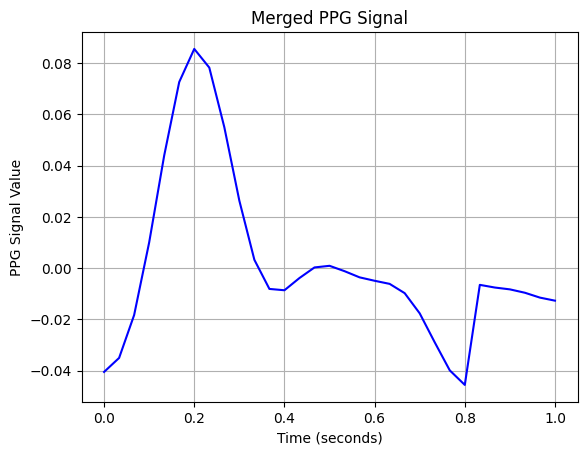

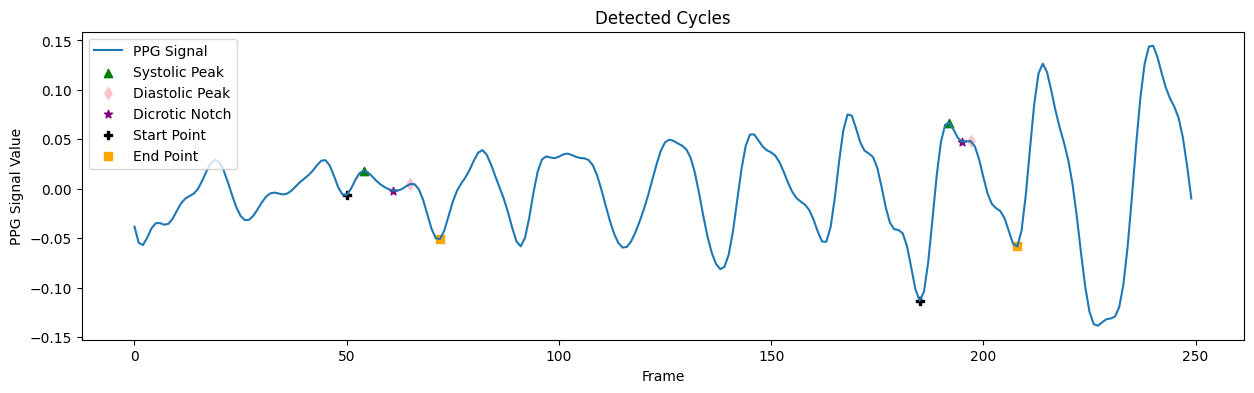

Detected PPG cycles for block 3, 5: [(50, 54, 61, 65, 72), (185, 192, 195, 197, 208)]
Sorted PPG cycles: [(185, 192, 195, 197, 208), (50, 54, 61, 65, 72)]
Selected PPG cycles {i}, {j}: [(185, 192, 195, 197, 208), (50, 54, 61, 65, 72), (185, 192, 195, 197, 208)]
Merged PPG signal: [-0.07746964 -0.06962312 -0.04691536 -0.01578844  0.01470935  0.03690558
  0.04729033  0.04715022  0.0411585   0.03474164  0.03140612  0.03125162
  0.03145174  0.02847462  0.0206767   0.00948349 -0.00176249 -0.01047351
 -0.0168911  -0.02374066 -0.03349535 -0.04529538 -0.05408033 -0.03892907]


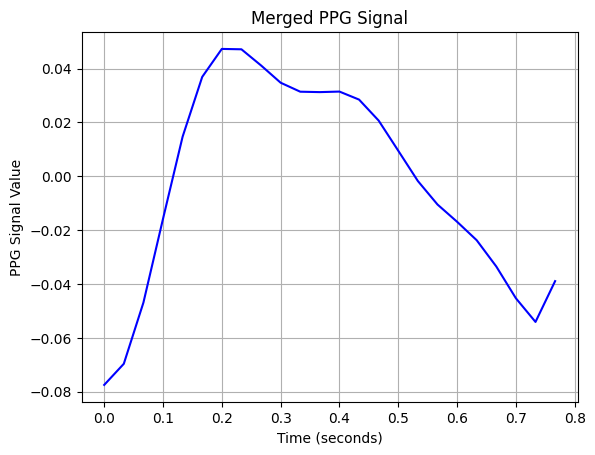

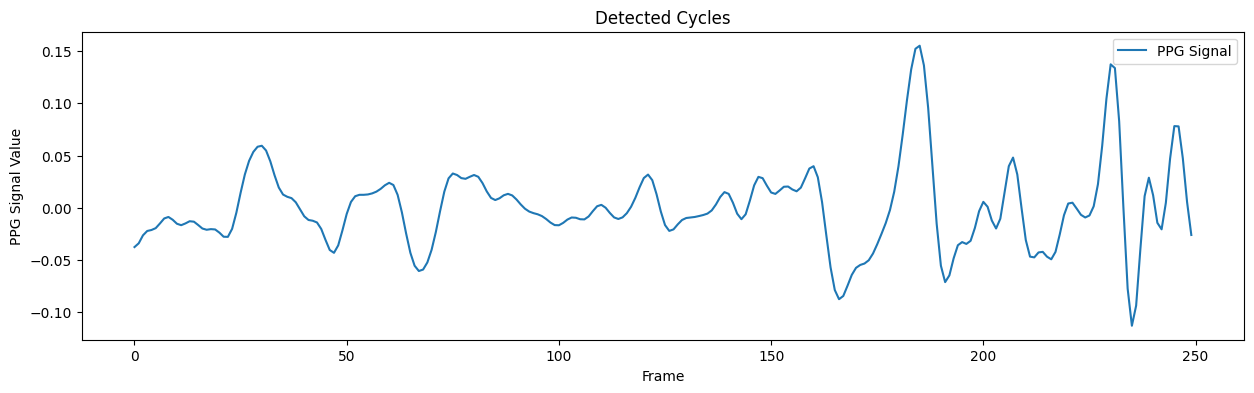

Detected PPG cycles for block 3, 6: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


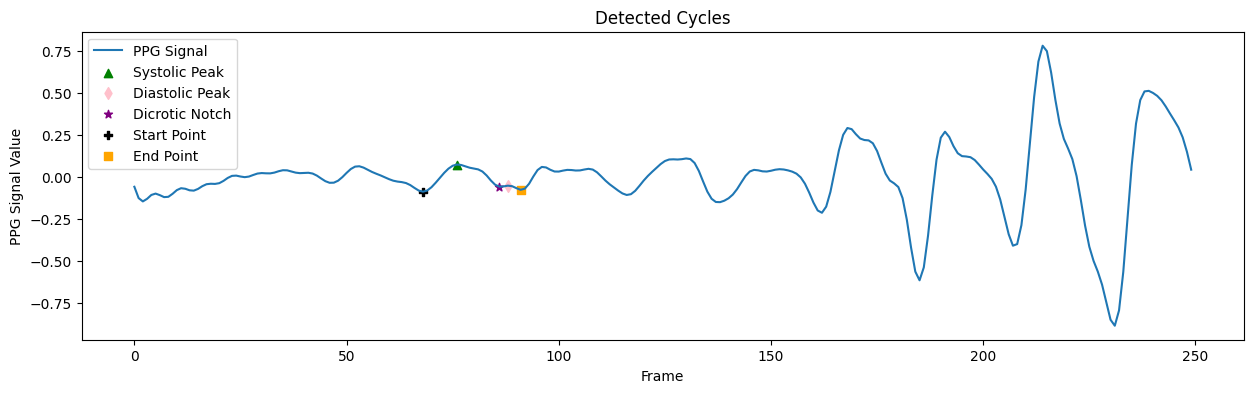

Detected PPG cycles for block 3, 7: [(68, 76, 86, 88, 91)]
Sorted PPG cycles: [(68, 76, 86, 88, 91)]
Selected PPG cycles {i}, {j}: [(68, 76, 86, 88, 91), (68, 76, 86, 88, 91), (68, 76, 86, 88, 91)]
Merged PPG signal: [-0.08783464 -0.08089561 -0.06155895 -0.03452711 -0.00480855  0.02395063
  0.04874074  0.06615946  0.07336236  0.07058721  0.06226835  0.05441687
  0.04966041  0.04444821  0.03182989  0.00824967 -0.02155452 -0.04664702
 -0.05812397 -0.05663436 -0.05213032 -0.05519594 -0.06699448 -0.07680871]


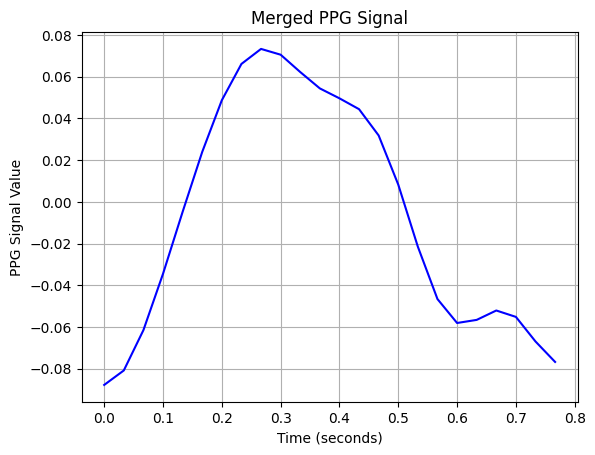

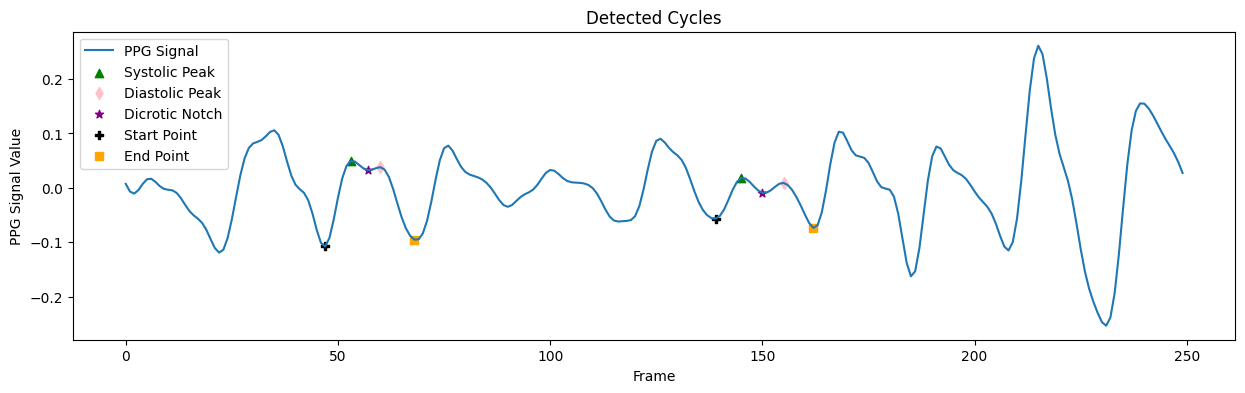

Detected PPG cycles for block 3, 8: [(47, 53, 57, 60, 68), (139, 145, 150, 155, 162)]
Sorted PPG cycles: [(139, 145, 150, 155, 162), (47, 53, 57, 60, 68)]
Selected PPG cycles {i}, {j}: [(139, 145, 150, 155, 162), (47, 53, 57, 60, 68), (139, 145, 150, 155, 162)]
Merged PPG signal: [-0.07352054 -0.06482991 -0.0456331  -0.02065674  0.00337116  0.02063204
  0.0284402   0.02765271  0.02147324  0.01374023  0.00764521  0.00507449
  0.00627731  0.00974321  0.01259274  0.01173636  0.00539443 -0.00603061
 -0.02047351 -0.03572418 -0.0505354  -0.0641299  -0.04293977 -0.04902362]


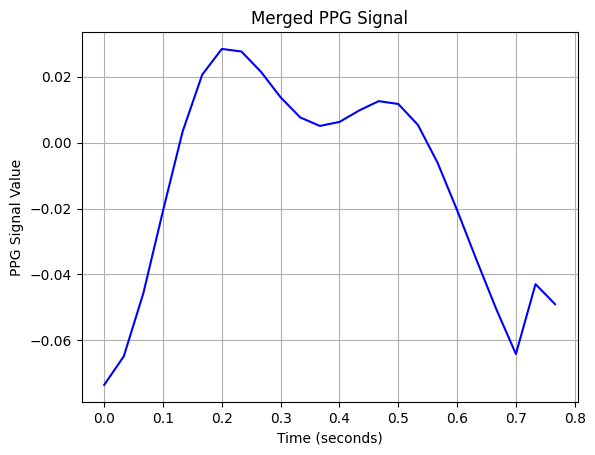

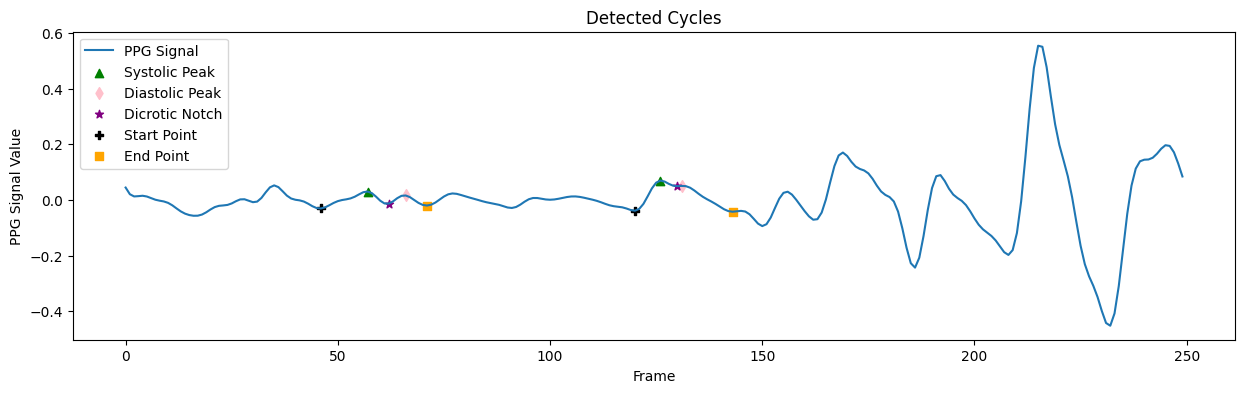

Detected PPG cycles for block 3, 9: [(46, 57, 62, 66, 71), (120, 126, 130, 131, 143)]
Sorted PPG cycles: [(120, 126, 130, 131, 143), (46, 57, 62, 66, 71)]
Selected PPG cycles {i}, {j}: [(120, 126, 130, 131, 143), (46, 57, 62, 66, 71), (120, 126, 130, 131, 143)]
Merged PPG signal: [-3.59883371e-02 -3.04615435e-02 -1.58388612e-02  5.13112446e-03
  2.63201001e-02  4.13794302e-02  4.73185975e-02  4.59992215e-02
  4.24077157e-02  4.09307656e-02  4.23663411e-02  4.38165028e-02
  4.13679210e-02  3.33618169e-02  2.17405177e-02  1.05938178e-02
  3.21281915e-03 -4.42361813e-05 -1.60892642e-03 -4.64330678e-03
 -1.07403797e-02 -1.89815163e-02 -2.67836620e-02 -3.17473523e-02
 -5.92106782e-03 -6.69680332e-03]


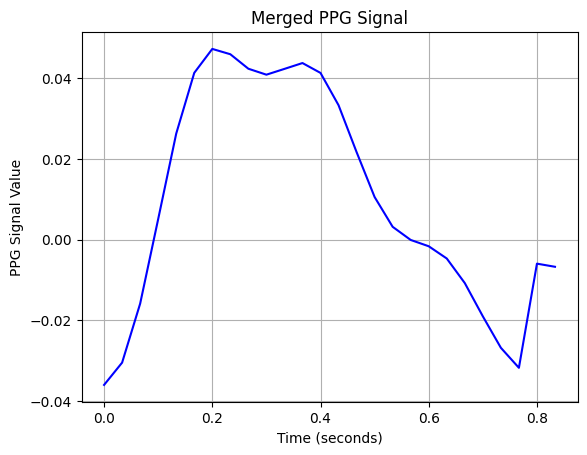

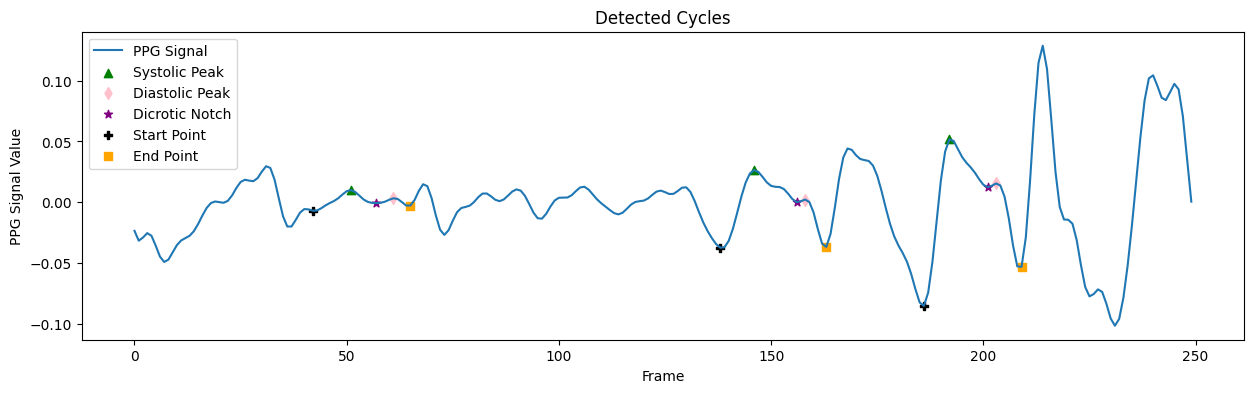

Detected PPG cycles for block 4, 0: [(42, 51, 57, 61, 65), (138, 146, 156, 158, 163), (186, 192, 201, 203, 209)]
Sorted PPG cycles: [(186, 192, 201, 203, 209), (138, 146, 156, 158, 163), (42, 51, 57, 61, 65)]
Selected PPG cycles {i}, {j}: [(186, 192, 201, 203, 209), (138, 146, 156, 158, 163), (42, 51, 57, 61, 65)]
Merged PPG signal: [-0.04308525 -0.03927992 -0.02852977 -0.01308013  0.00297047  0.0158511
  0.02372037  0.02681121  0.02646112  0.02405356  0.02059006  0.01681474
  0.01336672  0.01067575  0.00880697  0.00756203  0.0067509   0.00620558
  0.0053573   0.00288535 -0.00274194 -0.01168168 -0.02118885 -0.02585625
 -0.01132569 -0.01221799]


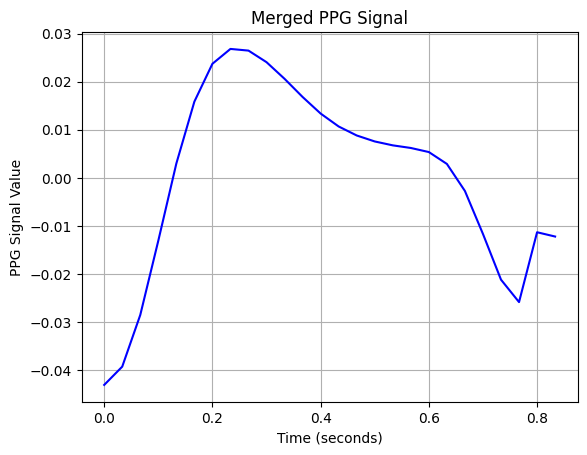

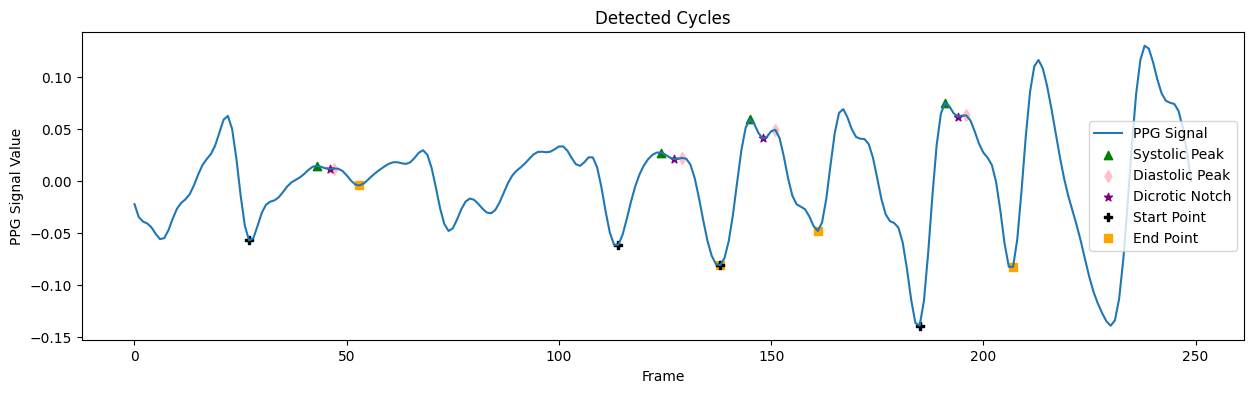

Detected PPG cycles for block 4, 1: [(27, 43, 46, 47, 53), (114, 124, 127, 129, 138), (138, 145, 148, 151, 161), (185, 191, 194, 196, 207)]
Sorted PPG cycles: [(185, 191, 194, 196, 207), (138, 145, 148, 151, 161), (114, 124, 127, 129, 138), (27, 43, 46, 47, 53)]
Selected PPG cycles {i}, {j}: [(185, 191, 194, 196, 207), (138, 145, 148, 151, 161), (114, 124, 127, 129, 138)]
Merged PPG signal: [-0.09407851 -0.08063947 -0.05482891 -0.02240237  0.00917687  0.03332033
  0.04669381  0.05021347  0.04800171  0.04479333  0.0433217   0.04329371
  0.04247159  0.03886216  0.03224793  0.02392596  0.01506451  0.00527759
 -0.00715297 -0.02339015 -0.04195757 -0.058243   -0.06624531 -0.04281076
 -0.02709804]


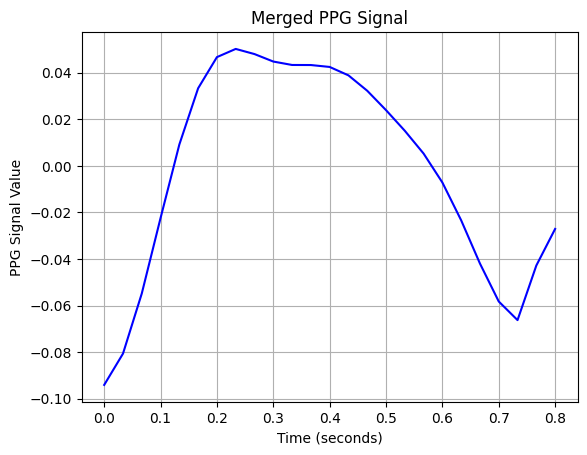

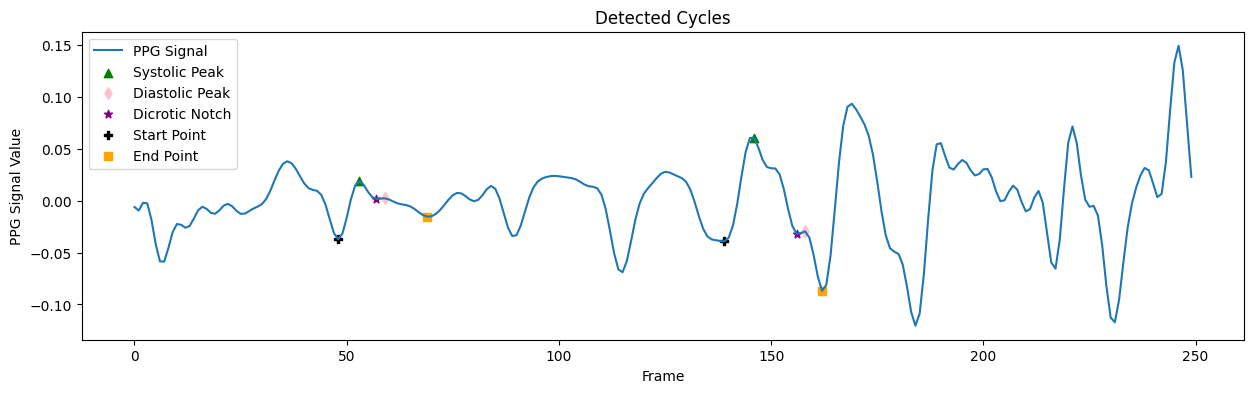

Detected PPG cycles for block 4, 2: [(48, 53, 57, 59, 69), (139, 146, 156, 158, 162)]
Sorted PPG cycles: [(139, 146, 156, 158, 162), (48, 53, 57, 59, 69)]
Selected PPG cycles {i}, {j}: [(139, 146, 156, 158, 162), (48, 53, 57, 59, 69), (139, 146, 156, 158, 162)]
Merged PPG signal: [-0.03852609 -0.03433886 -0.02157489 -0.00164551  0.02029842  0.03758472
  0.04540211  0.04329754  0.03519548  0.02685472  0.02231258  0.02157553
  0.0210699   0.01655694  0.00649734 -0.0065585  -0.01766485 -0.02314198
 -0.02352447 -0.02345396 -0.02831037 -0.03982518 -0.04885816 -0.05787948]


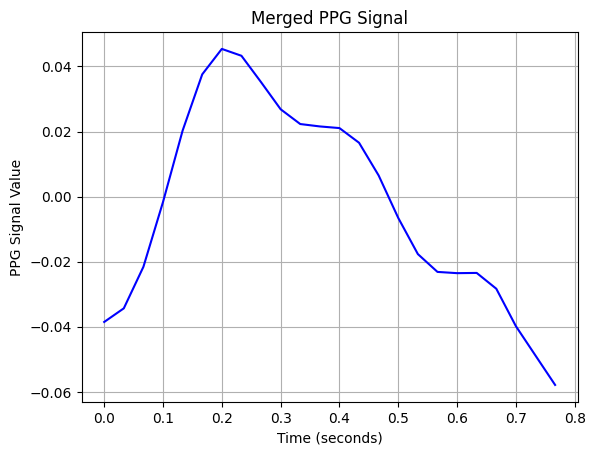

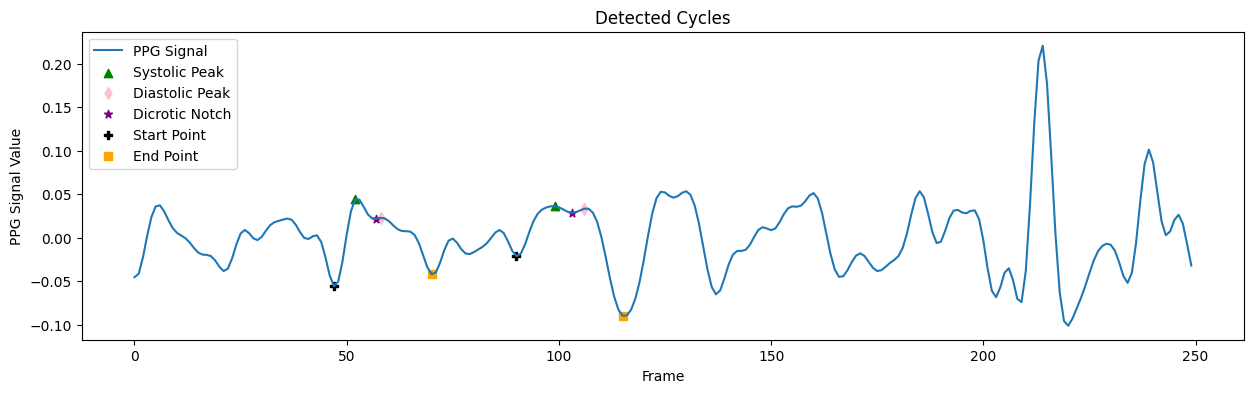

Detected PPG cycles for block 4, 3: [(47, 52, 57, 58, 70), (90, 99, 103, 106, 115)]
Sorted PPG cycles: [(90, 99, 103, 106, 115), (47, 52, 57, 58, 70)]
Selected PPG cycles {i}, {j}: [(90, 99, 103, 106, 115), (47, 52, 57, 58, 70), (90, 99, 103, 106, 115)]
Merged PPG signal: [-0.03287654 -0.02933833 -0.01465492  0.00515969  0.02256809  0.03285779
  0.03591243  0.03477446  0.03274553  0.03137677  0.03042272  0.02908706
  0.0271584   0.02520975  0.02404154  0.02400835  0.02462307  0.02445558
  0.02132775  0.012994   -0.00164117 -0.02130643 -0.04214777 -0.05913054
 -0.05510418 -0.05986979]


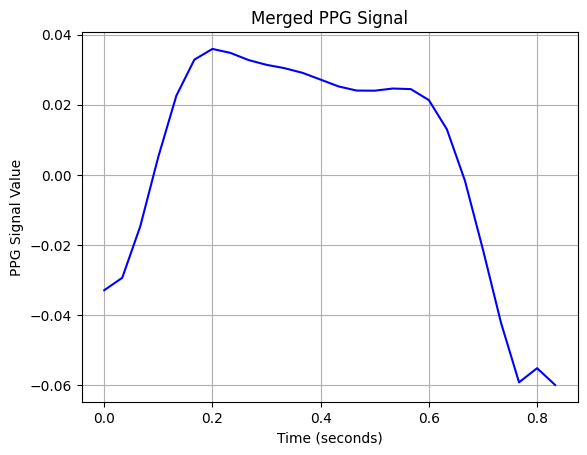

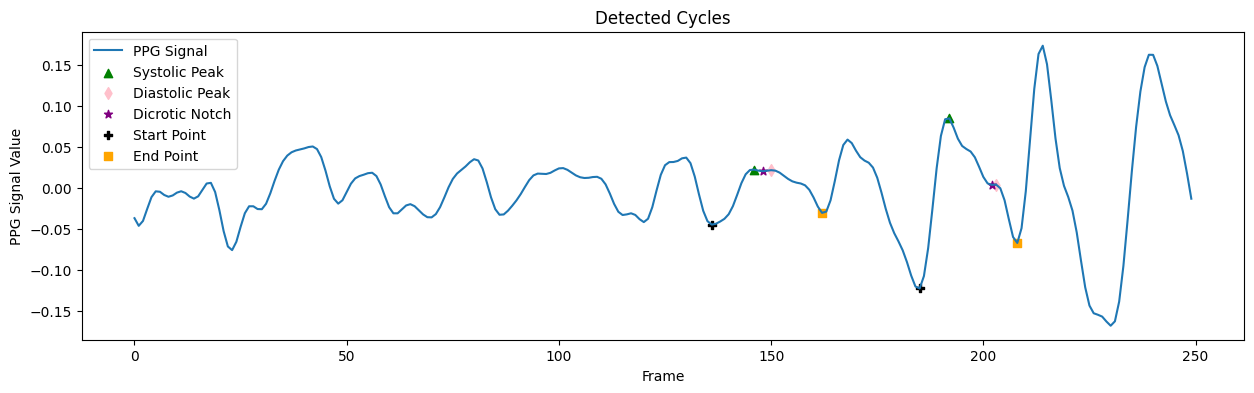

Detected PPG cycles for block 4, 4: [(136, 146, 148, 150, 162), (185, 192, 202, 203, 208)]
Sorted PPG cycles: [(185, 192, 202, 203, 208), (136, 146, 148, 150, 162)]
Selected PPG cycles {i}, {j}: [(185, 192, 202, 203, 208), (136, 146, 148, 150, 162), (185, 192, 202, 203, 208)]
Merged PPG signal: [-0.09628976 -0.08586487 -0.06221314 -0.02934354  0.0057644   0.0352806
  0.05342716  0.05885587  0.0549775   0.04772641  0.04199111  0.03905515
  0.03678664  0.03227743  0.02474578  0.01634901  0.01029128  0.00784369
  0.00679895  0.00275947 -0.00753849 -0.02318842 -0.03847455 -0.04512967
 -0.00376226 -0.00745538 -0.01001399]


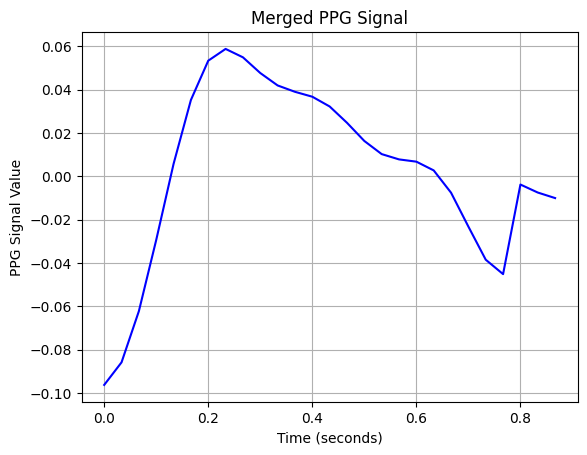

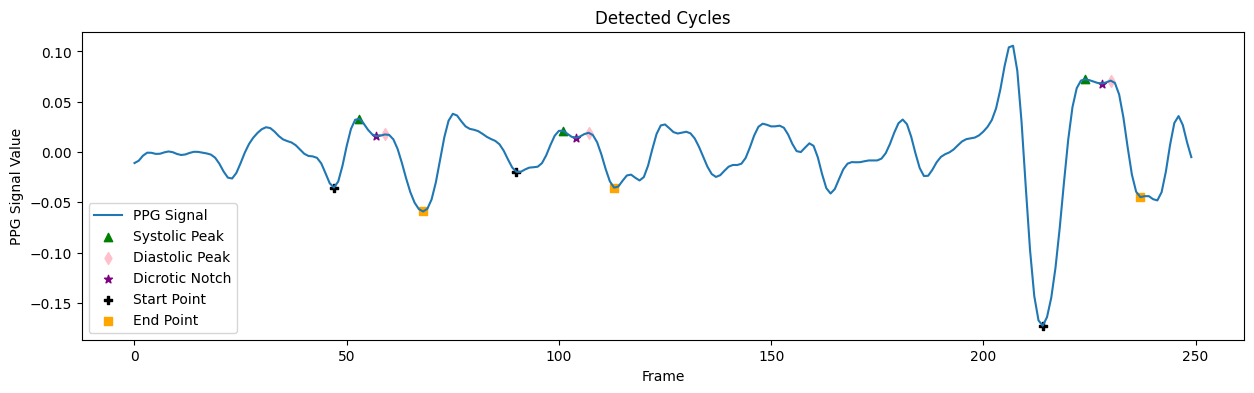

Detected PPG cycles for block 4, 5: [(47, 53, 57, 59, 68), (90, 101, 104, 107, 113), (214, 224, 228, 230, 237)]
Sorted PPG cycles: [(214, 224, 228, 230, 237), (90, 101, 104, 107, 113), (47, 53, 57, 59, 68)]
Selected PPG cycles {i}, {j}: [(214, 224, 228, 230, 237), (90, 101, 104, 107, 113), (47, 53, 57, 59, 68)]
Merged PPG signal: [-0.07583819 -0.07099462 -0.05858833 -0.04142756 -0.02243906 -0.00416877
  0.0114502   0.02324539  0.03091723  0.03498189  0.03643887  0.03629289
  0.03523067  0.03361977  0.03165605  0.02931875  0.02605236  0.02057598
  0.01137679 -0.00205697 -0.0180439  -0.03270352 -0.02282265 -0.02669156]


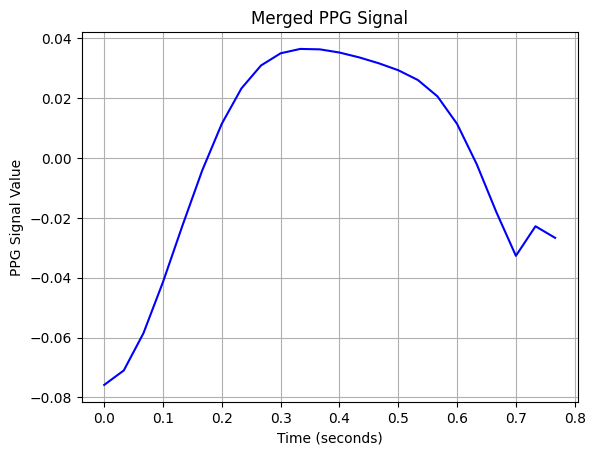

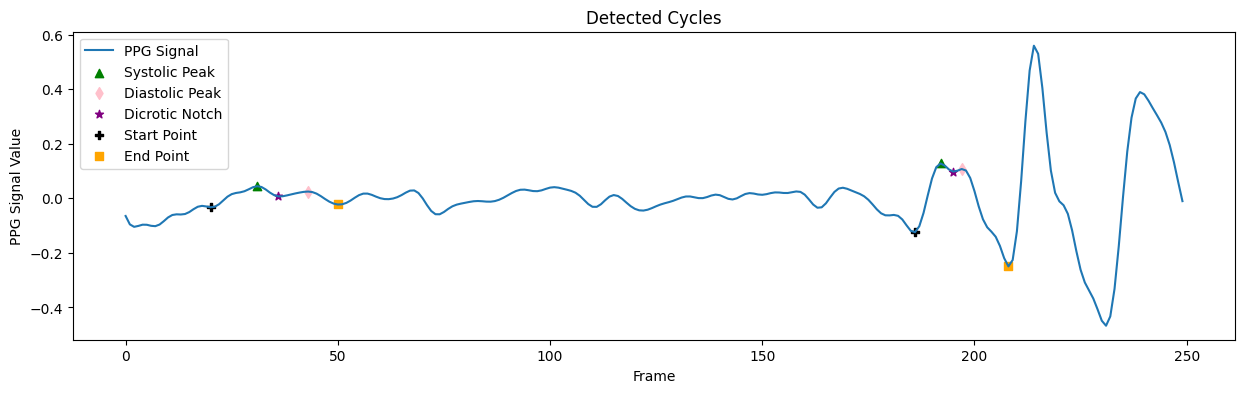

Detected PPG cycles for block 4, 6: [(20, 31, 36, 43, 50), (186, 192, 195, 197, 208)]
Sorted PPG cycles: [(186, 192, 195, 197, 208), (20, 31, 36, 43, 50)]
Selected PPG cycles {i}, {j}: [(186, 192, 195, 197, 208), (20, 31, 36, 43, 50), (186, 192, 195, 197, 208)]
Merged PPG signal: [-0.09352351 -0.07852695 -0.04294448  0.00492315  0.05067678  0.08127108
  0.09179935  0.08740669  0.07915726  0.07651519  0.08123553  0.08651942
  0.08189377  0.0606038   0.02467189 -0.01579215 -0.04878991 -0.06822979
 -0.07801278 -0.08905525 -0.11031228 -0.13921903 -0.15839227  0.00829338
  0.00765558  0.00572194  0.00267985 -0.00084076 -0.00407185 -0.00641308
 -0.00752888]


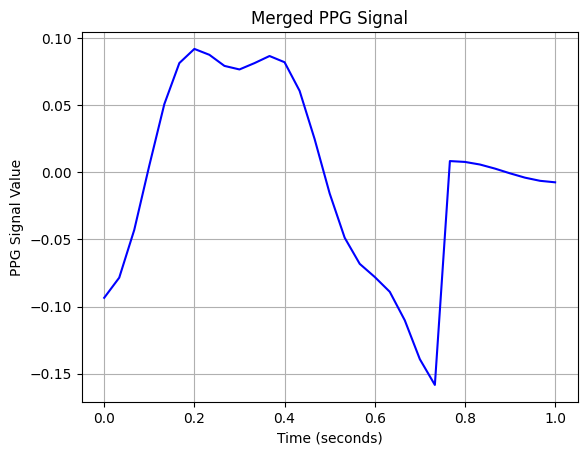

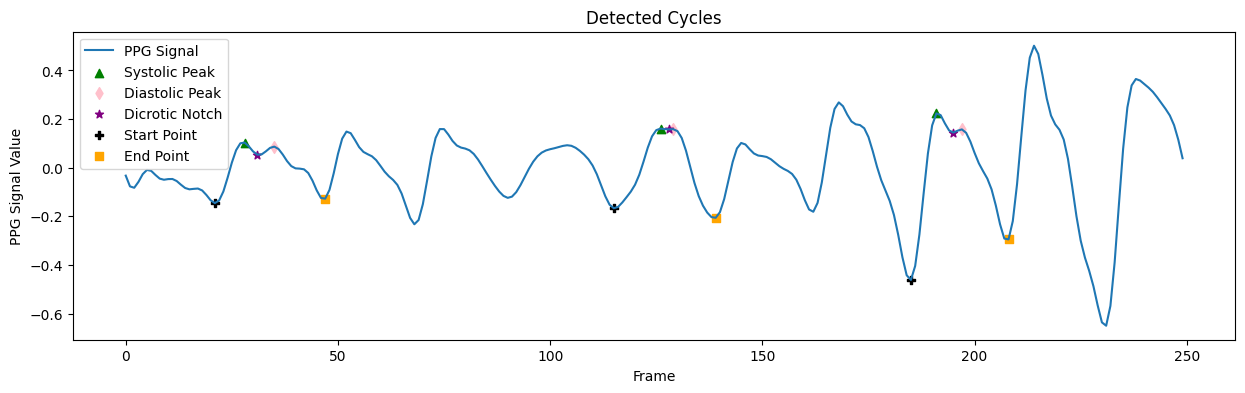

Detected PPG cycles for block 4, 7: [(21, 28, 31, 35, 47), (115, 126, 128, 129, 139), (185, 191, 195, 197, 208)]
Sorted PPG cycles: [(185, 191, 195, 197, 208), (115, 126, 128, 129, 139), (21, 28, 31, 35, 47)]
Selected PPG cycles {i}, {j}: [(185, 191, 195, 197, 208), (115, 126, 128, 129, 139), (21, 28, 31, 35, 47)]
Merged PPG signal: [-0.25801777 -0.23341811 -0.17189349 -0.08918256 -0.00651572  0.058547
  0.09814674  0.11477371  0.1174394   0.11614619  0.11741369  0.12238239
  0.12758238  0.12747195  0.11742424  0.09585662  0.06461808  0.02756552
 -0.01174701 -0.05168824 -0.09214005 -0.13197157 -0.1659795  -0.1838519
 -0.09984767 -0.04153783 -0.04245483]


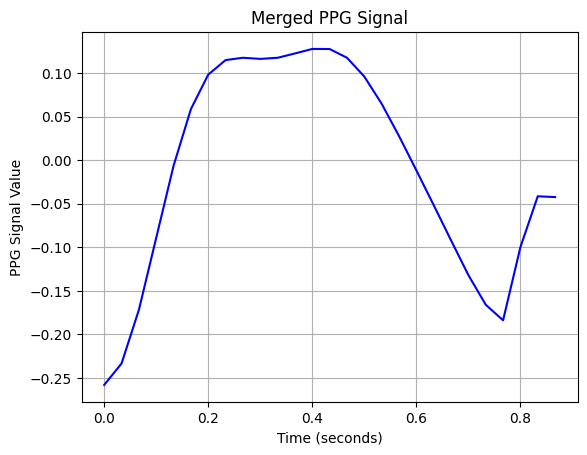

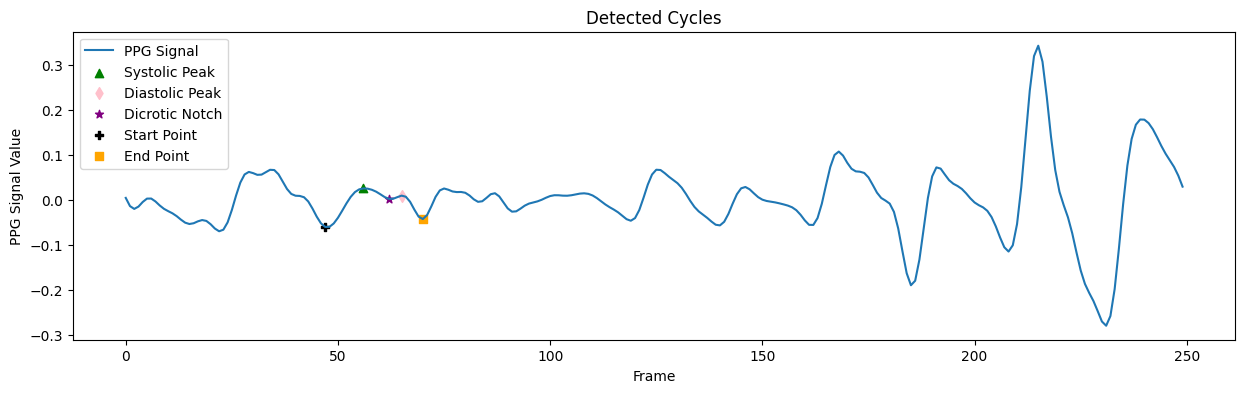

Detected PPG cycles for block 4, 8: [(47, 56, 62, 65, 70)]
Sorted PPG cycles: [(47, 56, 62, 65, 70)]
Selected PPG cycles {i}, {j}: [(47, 56, 62, 65, 70), (47, 56, 62, 65, 70), (47, 56, 62, 65, 70)]
Merged PPG signal: [-0.06072859 -0.06047937 -0.05303651 -0.04037425 -0.02472554 -0.00846296
  0.00598205  0.01664438  0.02274296  0.0248626   0.02425051  0.02177813
  0.01757978  0.01179796  0.00568105  0.00166247  0.00178886  0.00549828
  0.00881421  0.00632086 -0.00490806 -0.02221892 -0.03783827 -0.04319662]


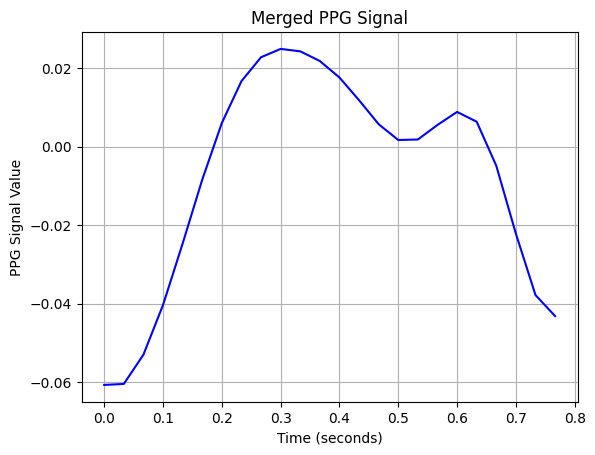

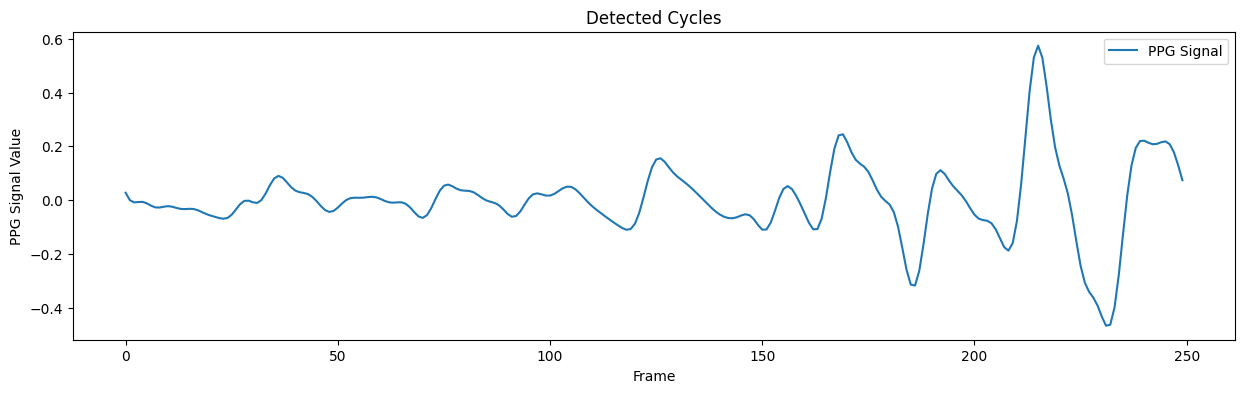

Detected PPG cycles for block 4, 9: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


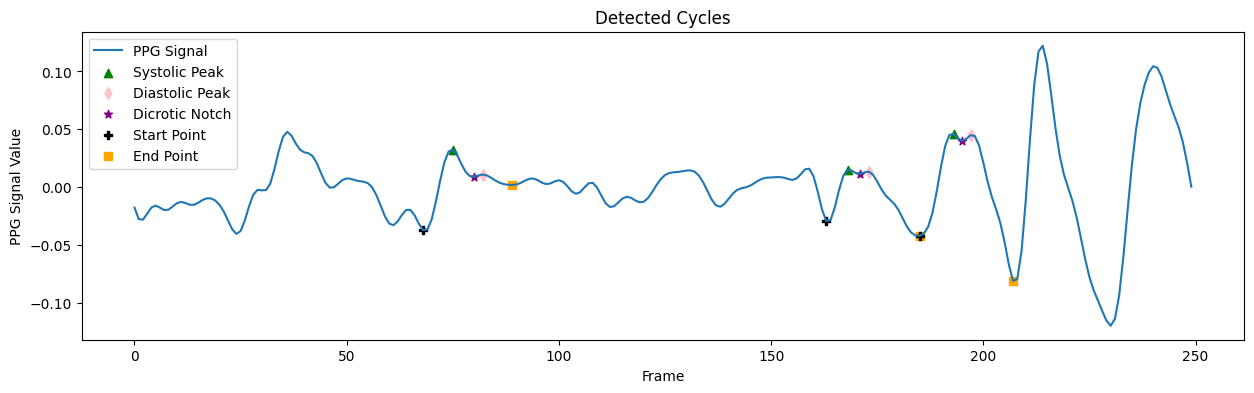

Detected PPG cycles for block 5, 0: [(68, 75, 80, 82, 89), (163, 168, 171, 173, 185), (185, 193, 195, 197, 207)]
Sorted PPG cycles: [(185, 193, 195, 197, 207), (163, 168, 171, 173, 185), (68, 75, 80, 82, 89)]
Selected PPG cycles {i}, {j}: [(185, 193, 195, 197, 207), (163, 168, 171, 173, 185), (68, 75, 80, 82, 89)]
Merged PPG signal: [-0.0363187  -0.03522441 -0.02681939 -0.01268265  0.00356388  0.01772689
  0.02673867  0.02978326  0.02831493  0.02499198  0.02213193  0.02055953
  0.01947332  0.01731796  0.01301324  0.00668598 -0.00056549 -0.00762318
 -0.01421909 -0.02096271 -0.02839773 -0.03575065 -0.04113055]


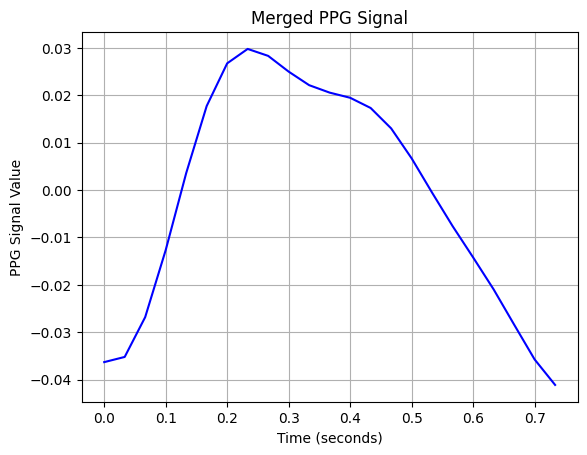

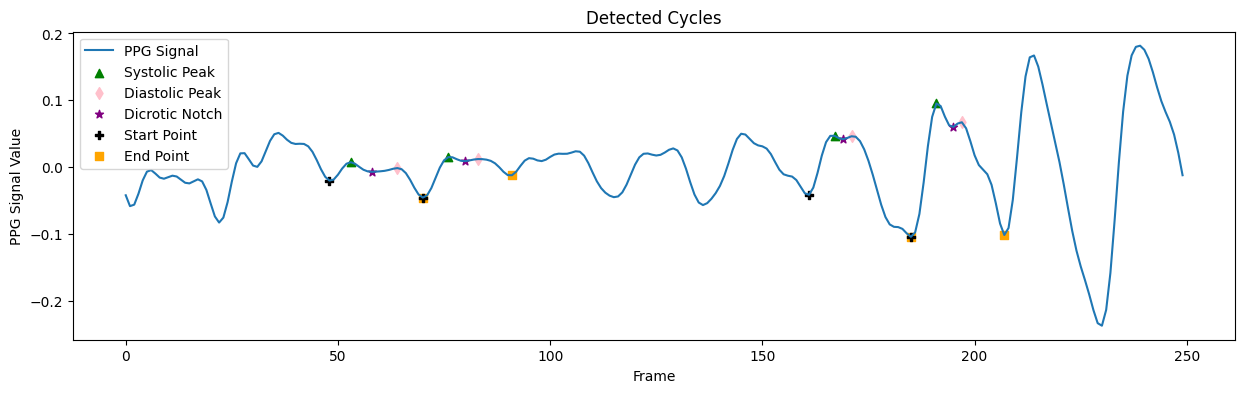

Detected PPG cycles for block 5, 1: [(48, 53, 58, 64, 70), (70, 76, 80, 83, 91), (161, 167, 169, 171, 185), (185, 191, 195, 197, 207)]
Sorted PPG cycles: [(185, 191, 195, 197, 207), (161, 167, 169, 171, 185), (70, 76, 80, 83, 91), (48, 53, 58, 64, 70)]
Selected PPG cycles {i}, {j}: [(185, 191, 195, 197, 207), (161, 167, 169, 171, 185), (70, 76, 80, 83, 91)]
Merged PPG signal: [-0.06391749 -0.05695738 -0.03679161 -0.00734783  0.02259949  0.0439719
  0.05229797  0.04974738  0.04298464  0.03844512  0.03835878  0.04012004
  0.03903863  0.03210217  0.0199262   0.00575223 -0.00729493 -0.01833086
 -0.02866207 -0.03990039 -0.05193244 -0.06227839 -0.06479365 -0.03309497
 -0.03483285]


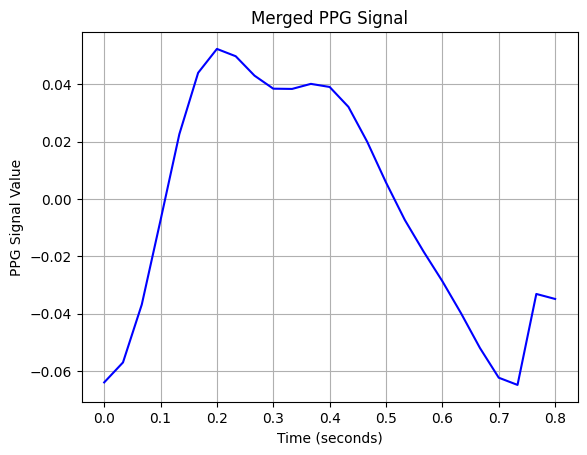

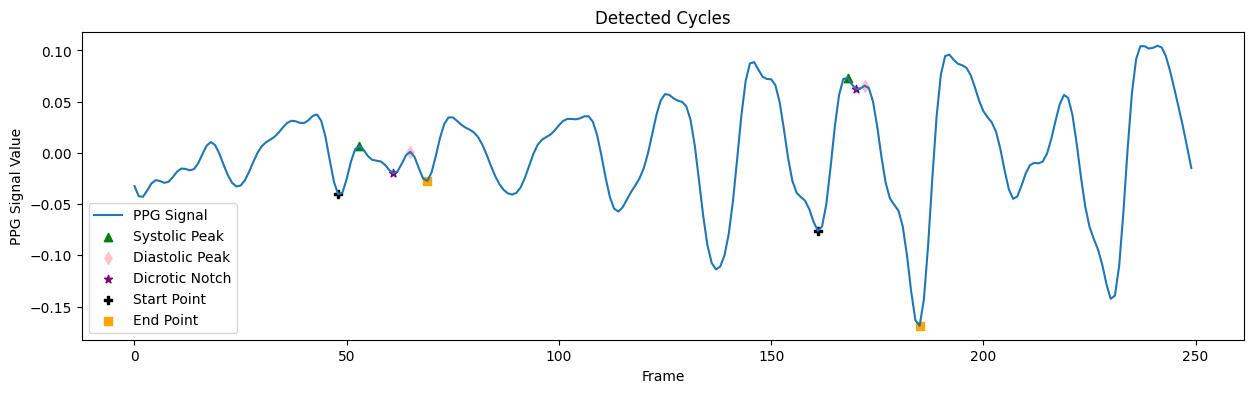

Detected PPG cycles for block 5, 2: [(48, 53, 61, 65, 69), (161, 168, 170, 172, 185)]
Sorted PPG cycles: [(161, 168, 170, 172, 185), (48, 53, 61, 65, 69)]
Selected PPG cycles {i}, {j}: [(161, 168, 170, 172, 185), (48, 53, 61, 65, 69), (161, 168, 170, 172, 185)]
Merged PPG signal: [-0.06411577 -0.06075418 -0.04183337 -0.01226543  0.01814278  0.03998859
  0.04906906  0.04776771  0.04247214  0.03899877  0.03906602  0.0398935
  0.03681776  0.02691358  0.01116153 -0.0061607  -0.02032183 -0.02928388
 -0.03509243 -0.04256374 -0.0559657  -0.07562063 -0.09016411 -0.10894396
 -0.11244243]


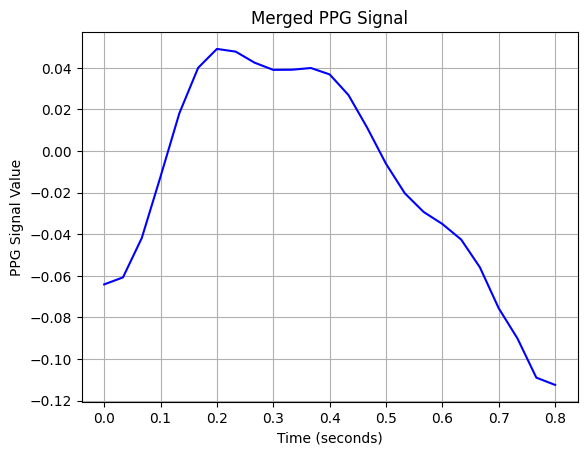

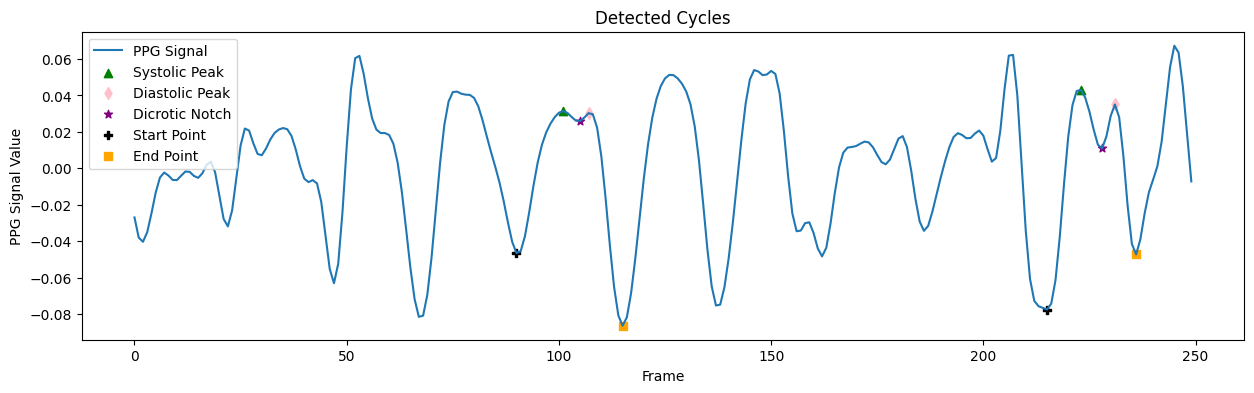

Detected PPG cycles for block 5, 3: [(90, 101, 105, 107, 115), (215, 223, 228, 231, 236)]
Sorted PPG cycles: [(215, 223, 228, 231, 236), (90, 101, 105, 107, 115)]
Selected PPG cycles {i}, {j}: [(215, 223, 228, 231, 236), (90, 101, 105, 107, 115), (215, 223, 228, 231, 236)]
Merged PPG signal: [-0.06709587 -0.06460054 -0.05327902 -0.0332042  -0.00907495  0.01261104
  0.02744533  0.03486094  0.03680316  0.03520123  0.03087274  0.02461698
  0.01874369  0.01669961  0.02043521  0.02777302  0.03263799  0.0287643
  0.01430782 -0.00638359 -0.025497   -0.0369508  -0.01403406 -0.02169358
 -0.02689317 -0.02877429]


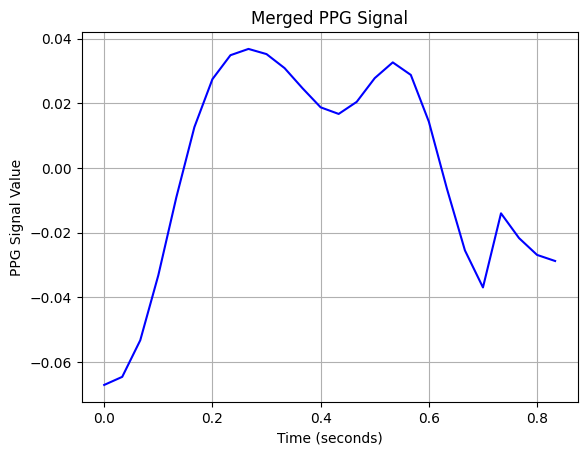

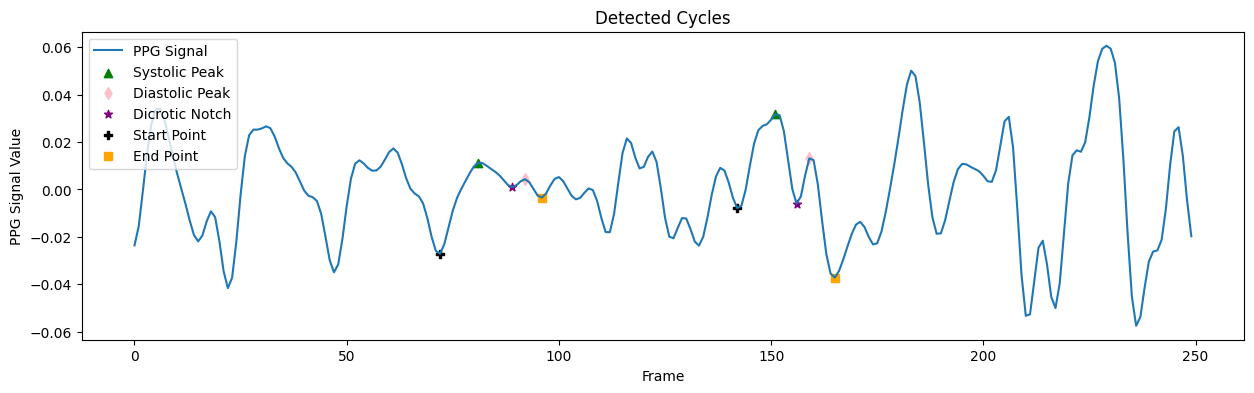

Detected PPG cycles for block 5, 4: [(72, 81, 89, 92, 96), (142, 151, 156, 159, 165)]
Sorted PPG cycles: [(142, 151, 156, 159, 165), (72, 81, 89, 92, 96)]
Selected PPG cycles {i}, {j}: [(142, 151, 156, 159, 165), (72, 81, 89, 92, 96), (142, 151, 156, 159, 165)]
Merged PPG signal: [-0.01428092 -0.01230583 -0.00540011  0.00376217  0.01180142  0.01674758
  0.01904555  0.02064295  0.02288531  0.02500266  0.02457323  0.01971132
  0.01118153  0.00254545 -0.00202586 -0.00071106  0.00451051  0.00907548
  0.00883124  0.00261401 -0.00733529 -0.01712496 -0.02360144 -0.02567985
 -0.0011511 ]


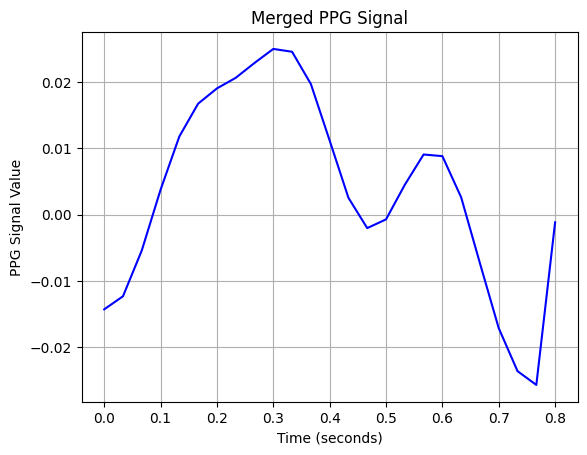

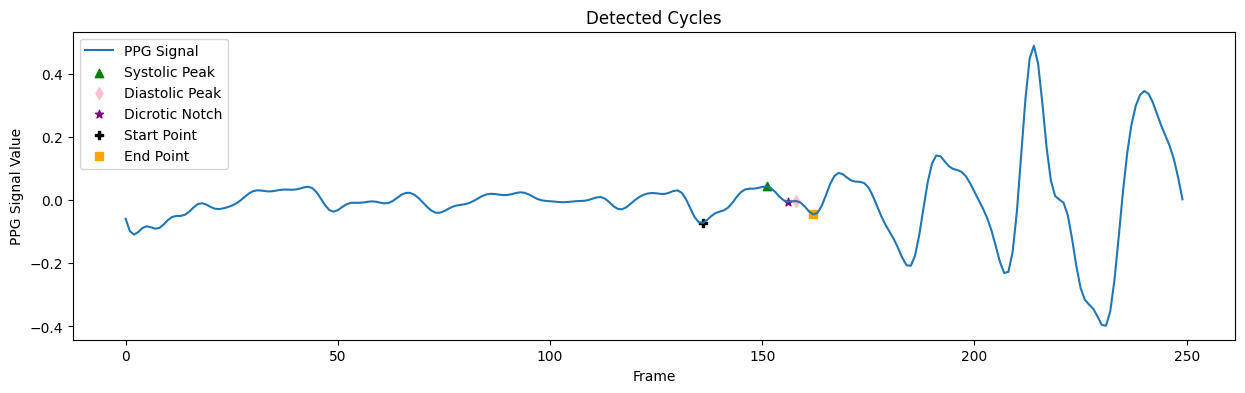

Detected PPG cycles for block 5, 5: [(136, 151, 156, 158, 162)]
Sorted PPG cycles: [(136, 151, 156, 158, 162)]
Selected PPG cycles {i}, {j}: [(136, 151, 156, 158, 162), (136, 151, 156, 158, 162), (136, 151, 156, 158, 162)]
Merged PPG signal: [-7.18974495e-02 -6.27658781e-02 -5.01091824e-02 -4.07751632e-02
 -3.60609918e-02 -3.18754957e-02 -2.29713830e-02 -7.68477054e-03
  1.05374251e-02  2.57932260e-02  3.41865580e-02  3.64354379e-02
  3.66564336e-02  3.85159274e-02  4.19980132e-02  4.34223077e-02
  3.86575310e-02  2.69084354e-02  1.19995996e-02  2.55377716e-05
 -4.96144096e-03 -4.01654675e-03 -2.74720984e-03 -7.32647932e-03
 -1.97137049e-02 -3.53640945e-02 -4.51405151e-02]


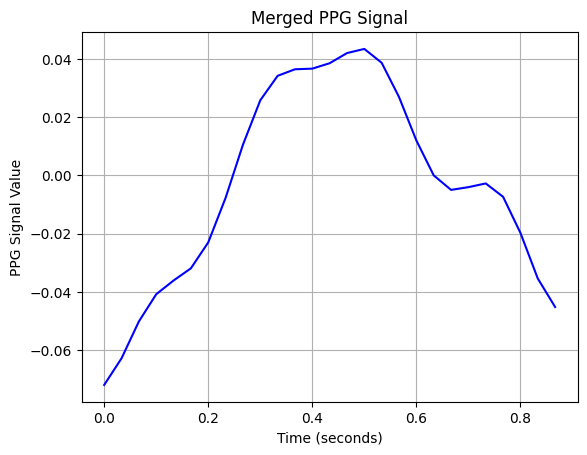

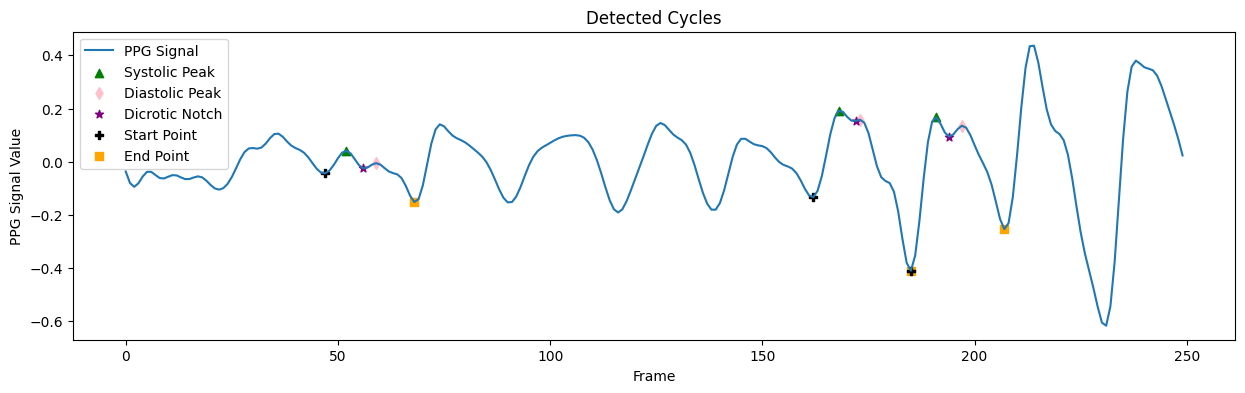

Detected PPG cycles for block 5, 6: [(47, 52, 56, 59, 68), (162, 168, 172, 173, 185), (185, 191, 194, 197, 207)]
Sorted PPG cycles: [(185, 191, 194, 197, 207), (162, 168, 172, 173, 185), (47, 52, 56, 59, 68)]
Selected PPG cycles {i}, {j}: [(185, 191, 194, 197, 207), (162, 168, 172, 173, 185), (47, 52, 56, 59, 68)]
Merged PPG signal: [-0.19556909 -0.1654573  -0.09670295 -0.00914942  0.07009611  0.11880253
  0.12958383  0.11239888  0.08781612  0.07448476  0.07820437  0.08961097
  0.09215042  0.07481678  0.04034415  0.00254691 -0.02533625 -0.0421585
 -0.06062493 -0.09688864 -0.15519903 -0.2193455  -0.21137119 -0.13663   ]


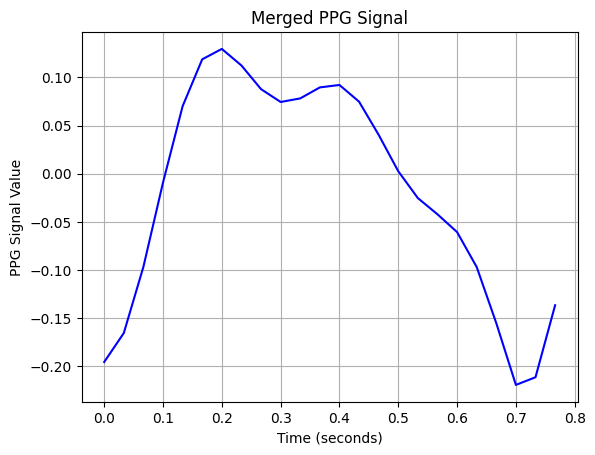

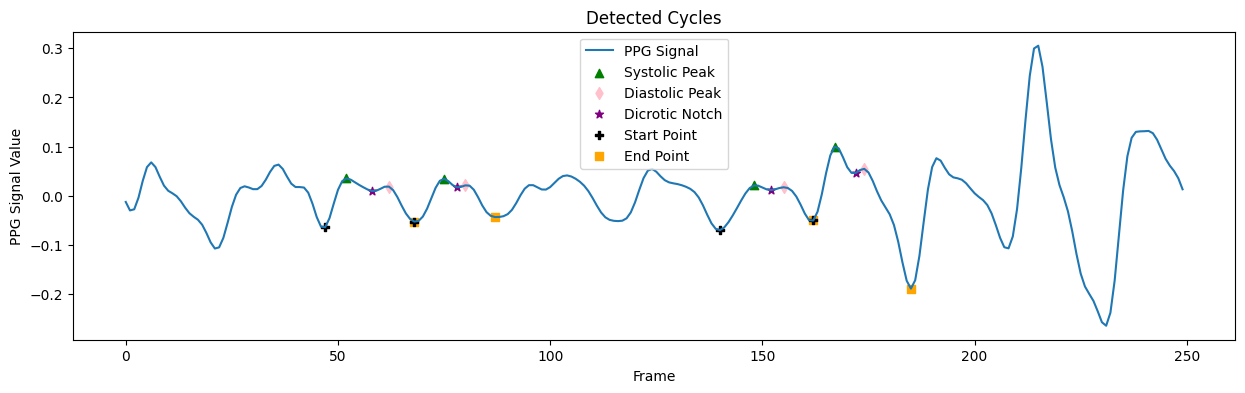

Detected PPG cycles for block 5, 7: [(47, 52, 58, 62, 68), (68, 75, 78, 80, 87), (140, 148, 152, 155, 162), (162, 167, 172, 174, 185)]
Sorted PPG cycles: [(162, 167, 172, 174, 185), (140, 148, 152, 155, 162), (68, 75, 78, 80, 87), (47, 52, 58, 62, 68)]
Selected PPG cycles {i}, {j}: [(162, 167, 172, 174, 185), (140, 148, 152, 155, 162), (68, 75, 78, 80, 87)]
Merged PPG signal: [-0.05722449 -0.04900191 -0.03080031 -0.00662994  0.01751901  0.0356286
  0.04401624  0.04295494  0.03643623  0.02989729  0.02708855  0.02802681
  0.0294157   0.02724737  0.01970163  0.00819721 -0.00415622 -0.01539868
 -0.0264293  -0.03995346 -0.0429625  -0.0614591  -0.07409204 -0.06277524]


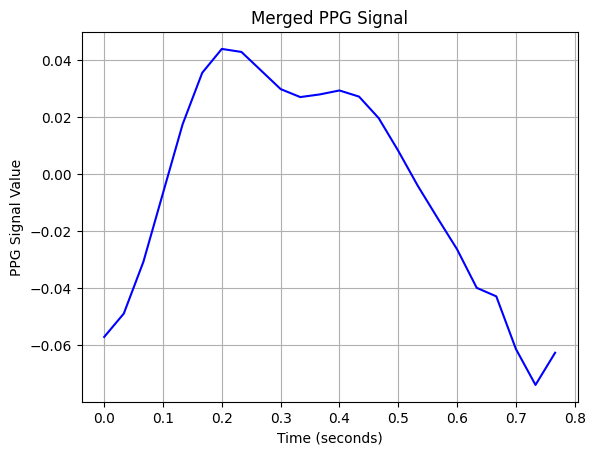

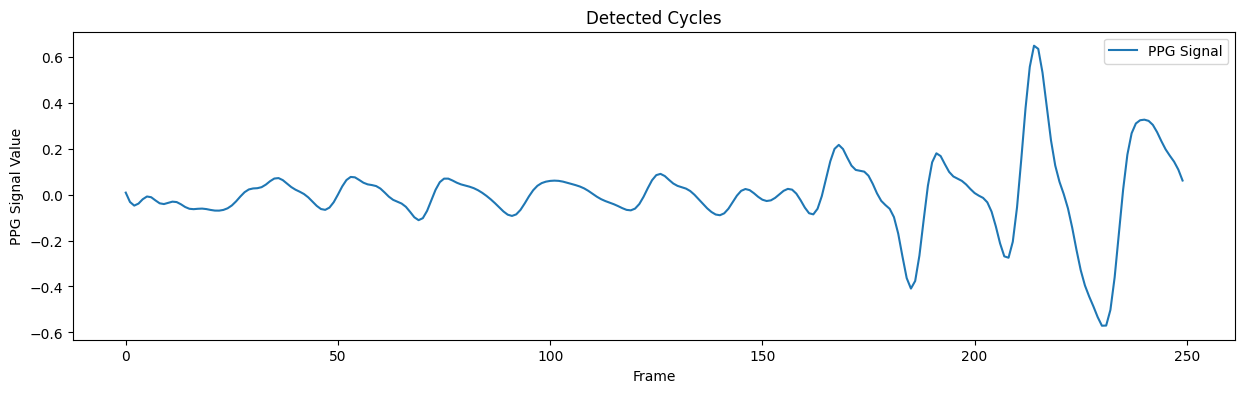

Detected PPG cycles for block 5, 8: []
Sorted PPG cycles: []
Selected PPG cycles {i}, {j}: []
Merged PPG signal: None
No merged signal to visualize.


: 

In [63]:
all_ppg_cycles = []
all_selected_cycles = []
all_merged_signals = []

for i in range(10):
    for j in range(10):
        sppg_signal = SPPG[i, j, :]
        ppg_cycles = detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate)
        all_ppg_cycles.extend(ppg_cycles)
        print(f"Detected PPG cycles for block {i}, {j}:", ppg_cycles)

        selected_cycles = select_three_ppg_cycles(ppg_cycles)
        all_selected_cycles.extend(selected_cycles)
        print("Selected PPG cycles {i}, {j}:", selected_cycles)

        merged_signal = merge_ppg_cycles(sppg_signal, selected_cycles)
        print("Merged PPG signal:", merged_signal)
        visualize_merged_signal(merged_signal, sampling_rate)
        all_merged_signals.append(merged_signal)